### Now that I have full imaging code, it's time to clean it up and start documenting things

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# It's optimal if this is a power of 2.  For CPU use 16K appears best.
blocklenk = 16
blocklen = (blocklenk * 1024)

# hilbert_filter_terms has a direct impact on filter delays
hilbert_filter_terms = 1024
# typically the most delay added is 128 (NTSC chroma bandpass) but best to be safe for now
blockcut = hilbert_filter_terms + 192

In [3]:
# charting/graphing code carried over from earlier development efforts
# (will probably be moved back into a ldutils2 package)

def doplot(B, A, freq = 40):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')
    
    return 20 * np.log10(abs(h))
    
    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()
    
    return db

# Draws a uint16 image, downscaled to uint8
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [4]:
# System default specs for NTSC and PAL.

# IEC 60857 9.2.2: the range from -40 to 100 IRE is 1.7mhz, with 0 at 8.1mhz.  Maximum is 110IRE.
NTSC_hz_ire = 1700000 / 140.0

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match legacy ld-decode scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    # (note:  i don't know how to handle these values perfectly yet!)
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters are important with DD v3.0+ boards
    'audio_filtwidth': 150000,
    'audio_filtorder': 2,

    # This BPF similar but not *quite* identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz or even a bit higher. 
    # A sharp 4.8-5.0 is probably the maximum before the audio carriers bleed into 0IRE.
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    
    # The PAL spec does not use IRE but rather voltage.
    'videorf_0ire': 7100000, # the sync signal peaks about here at full saturation
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Load up default parameters

params = {'freq': 40}

for p in [SysParams_NTSC]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 2
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5


In [6]:
# (mostly the) old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140

hz_ire_scale = 1700000 / 140

# NTSC
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [7]:
hz0ire = params['videorf_0ire']

In [8]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

# crude zero-crossing calculator.

def iretohz(ire):
    return hz0ire + (hz_ire_scale * ire)

def hztoire(hz):
    return (hz - hz0ire) / hz_ire_scale

m20ire = iretohz(-20)

def calczc(data, _start_offset, target, _count=10):
    start_offset = int(_start_offset)
    count = int(_count + 1)
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [9]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

# This converts a regular B, A filter to an FFT of our selected block length
def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [10]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

#doplot(tf_b, tf_a)

In [11]:
# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['hilbert_filter_terms'] = hilbert_filter_terms
    
    # build up a couple more constants
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
    
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF filter, which will get the audio notch filters added if needed
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    # If there is analog audio, it must be filtered well especially with DD >=3.0-beta RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # The above is multiplied with a Hilbert transform to get (partway) to demodulation
    
    # The 4.2-4.6mhz (NTSC)/5.x mhz (PAL) demodulated lowpass filter
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low')) # standard 4.Xmhz

    # The deemphasis filter.  This math is probably still quite wrong, but with the right values it works
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10), -SP['deemp'][0]*(10**-10), SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # The direct opposite of the above, used in test signal generation
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10)/2.0, -SP['deemp'][1]*(10**-10)/2.0, SP['deemp'][1] / SP['deemp'][0])
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][0]*(10**-10), -SP['deemp'][1]*(10**-10), SP['deemp'][1] / SP['deemp'][0])
    SP['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))
    
    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(4, 0.5/freq_half, 'low')) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        SP['Fburst_len'] = 256
        SP['Fburst_delay'] = SP['Fburst_len'] // 2
        bf = sps.firwin(SP['Fburst_len'] + 1, [(SP['fsc_mhz'] * .975)/freq_half, (SP['fsc_mhz'] * 1.025)/freq_half], pass_zero=False)
        SP['Fburst'] = filtfft((bf, [1.0]))
        SP['imglen'] = (int)((SP['freq_hz'] / 59.976) * 1.25)
    else:
        # For PAL this is a 3.75mhz filter
        SP['Fburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        SP['imglen'] = (int)((SP['freq_hz'] / 50) * 1.25)
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [12]:
# The actual video demodulation code

def dodemod(paramsc, data, usemtf = False, cutarf = False, return_fft = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    # NTSC: filtering for vsync pulses from -55 to -25ire seems to work well even on rotted disks
    output_sync = (out_video > (params['videorf_0ire'] + (params['hz_ire'] * -55))) & (out_video < (params['videorf_0ire'] + (params['hz_ire'] * -25)))
    # Perform FFT convolution of above filter
    output_syncf = np.fft.ifft(np.fft.fft(output_sync) * filterset['FPsync']).real
    
    rv = np.rec.array([out_video, out_video05, output_syncf, out_videoburst], names=['demod', 'demod_05', 'demod_sync', 'demod_burst'])
    if return_fft:
        return rv, demod_fft
    else:
        return rv
    #return out_video, out_video05, out_videoburst

In [13]:
def lineplot(output, param):
    plt.plot(np.clip(output, 7400000, 9450000))
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [267]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [268]:
sample = 30002

In [280]:
def load_packed_data(infile, sample):
    start = (sample // 3) * 4
    offset = sample % 3
    start, offset

    infile.seek(start)

    # we need another word in case offset != 0
    needed = int(np.ceil(blocklen * 3 / 4) * 4) + 4

    inbuf = infile.read(needed)
    indata = np.fromstring(inbuf, 'uint32', len(inbuf) // 4)

    unpacked = np.zeros(len(indata) * 3, dtype=np.int16)

    np.bitwise_and(indata, 0x3ff, out = unpacked[0::3])
    np.bitwise_and(np.right_shift(indata, 10), 0x3ff, out = unpacked[1::3])
    np.bitwise_and(np.right_shift(indata, 20), 0x3ff, out = unpacked[2::3])

    return unpacked[offset:offset + blocklen]

In [90]:
def loaddata(infile, sample):

    if sampletype == 3:
        return load_packed_data

    infile.seek(sample * sampletype, 0)
    inbuf = infile.read(blocklen * sampletype)
    
    if sampletype == 1:
        indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
    elif sampletype == 2:
        indata = np.fromstring(inbuf, 'uint8', len(inbuf))

    if len(indata) < blocklen:
        return None
    
    return indata


In [91]:
def demod(infile, _start, _end, filterset, usemtf = False, retraw = False):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = int(_end)
    
    if (_start > blockcut):
        start = int(_start - blockcut)
    else:
        start = 0 # should this be an error?  prolly.

    #print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(start, end, blocklen - blockcut):
        #print(i, start, end)
        indata = loaddata(infile, i)
        if indata is None:
            break
        
        tmp = dodemod(filterset, indata, usemtf=usemtf)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        
        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut

        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)
            
        output[output_slice] = tmp[tmp_slice]

    #print(output.shape)
    if retraw:
        return output, indata
    else:
        return output
    

In [66]:
# since the filter parameters can cause many different effects, it is essential 
# to determine filter delays etc automatically

In [67]:
def genwave(rate, freq, initialphase = 0):
    out = np.zeros(len(rate), dtype=np.double)
    
    angle = initialphase
    
    for i in range(0, len(rate)):
        angle += np.pi * (rate[i] / freq)
        if angle > np.pi:
            angle -= tau
        
        out[i] = np.sin(angle)
        
    return out

In [68]:
# generate a fake signal and (try to ) decode it correctly :)
def calc_demodgaps(filterset):
    # generate a fake signal and (try to ) decode it correctly :)
    #def calc_demodgaps(filterset):
    fakeoutput = np.zeros(blocklen, dtype=np.double)

    # set base level to black
    fakeoutput[:] = 8100000

    # sync
    fakeoutput[1000:1300] = 7600000

    # color burst

    burstlen = int(18 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[1500:1500+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    burstlen = int(64 * ((filterset['freq'] / 2) / (315/88)) )
    rate = np.full(burstlen, (315/88.0), dtype=np.double)
    fakeoutput[0:0+burstlen] = 8100000 + (genwave(rate, filterset['freq'] / 2) * 250000)

    # white
    fakeoutput[2000:3000] = 9100000

    #[tf_b, tf_a] = sps.zpk2tf(-filterset['deemp'][1]*(10**-10)/2.0, -filterset['deemp'][0]*(10**-10)/2.0, filterset['deemp'][0] / filterset['deemp'][1])
    #filterset['Femp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/(filterset['freq_hz'] / 2.0)))

    tmp = np.fft.fft(fakeoutput)
    tmp2 = tmp * filterset['Fvideo_lpf']
    tmp3 = tmp2 * filterset['Femp']

    fakeoutput_lpf = np.fft.ifft(tmp2).real
    fakeoutput_emp = np.fft.ifft(tmp3).real

    fakesignal = genwave(fakeoutput_emp, filterset['freq_hz'] / 2)
    fakedecode = dodemod(filterset, fakesignal)

    # Determine filter lag (mostly the length of the hilbert filter)
    filterset['dgap'] = calczc(fakedecode['demod'], 950, iretohz(-20), 256 + hilbert_filter_terms) - calczc(fakeoutput_emp, 950, iretohz(-20), 500)

    # Now use above to calc the lag of the 0.5mhz filter
    dgap05_1 = calczc(fakedecode['demod_05'], 900 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 900 + filterset['dgap'], iretohz(-20), 500)
    dgap05_2 = calczc(fakedecode['demod_05'], 1250 + filterset['dgap'], iretohz(-20), 500) - calczc(fakedecode['demod'], 1250 + filterset['dgap'], iretohz(-20), 500)
    filterset['dgap_05'] = (dgap05_1 + dgap05_2) / 2

    fdburst_adj = fakedecode['demod_burst'][filterset['Fburst_delay']:]

    # find the last bottom of the emulated burst, then it's zero crossing
    c17_5 = 1500 + np.argmax(-fdburst_adj[1500:])
    c16_5 = c17_5 - ((filterset['freq'] / 2) / (315/88)) 

    c17 = calczc(fdburst_adj, int(c16_5), 0)
    c17_orig = 1500 + 17 * ((filterset['freq'] / 2) / (315/88)) 

    # find the *phase* difference of the peak (which is actually in the middle of the burst)
    # and the demodulated wave

    c17_demod = calczc(fakedecode['demod'], int(c16_5), 8100000)
    filterset['dgap_burst'] = (c17 - c17_demod)

    # not what we actually want ;)
    #filterset['dgap_burst'] = (c17 - c17_orig) - filterset['dgap']

    return fakeoutput, fakedecode

Below this is the less developed code to deal with NTSC framing and syncs.

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

In [69]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        #endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
        endsync1 = center + np.where(syncf[center:center + scanarea] > .95)[0][-1]
        endsync = endsync1 + np.where(syncf[endsync1:endsync1 + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')
        return None

    try:
        scanstart = (startsync - (ilinepx * 8))
        lastlinepresync = scanstart + np.where(syncf[scanstart: startsync] > .6)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line", startsync)
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .6)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line", endsync)
        nextline = None
        postsync_eqlen = None

    #print(lastlinepresync, nextline, presync_eqlen, postsync_eqlen)
    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

#findburstfromsync(rdata['demod_sync'], 190301)

In [70]:
def findsync(output_sync, loc = 0, limit = 40 * 2800):
    loc = int(loc)

    # find the next sync point.  should be > .9
    syncloc = np.argmax(output_sync[loc:loc+limit]) + loc

    if np.max(output_sync[loc:loc+limit]) < .9:
        #print("oops.  can't find a good sync")
        return (None, None, None)
    
    rv = findburstfromsync(output_sync, syncloc)
    if rv is None:
        return None, None, None
    
    prevline, nextline, pregap, postgap = rv

    #print(np.max(output_sync[loc:loc+imglen]), pregap, postgap)
    
    if pregap >= 3.75:
        firstfield = True
    else:
        firstfield = False
    
    return syncloc, firstfield, nextline

In [71]:
def findfirstframe(infile, start = 0):

    readlen = int(128 * filterset['line_px'])

    loc = start
    while (loc - start) < filterset['freq_hz']:
        print(loc)
        data = demod(infile, loc, loc + readlen, filterset)
        
        if np.max(data['demod_sync']) > .9:
            if (np.argmax(data['demod_sync']) / filterset['line_px']) > 100:
                loc += np.argmax(data['demod_sync']) - int(16 * filterset['line_px'])
                print('a')
                continue
        else:
            loc += int(120 * filterset['line_px'])
            print('b')
            continue
                
        #print(loc, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        syncloc, firstfield, nextline = findsync(data['demod_sync'])
        
        #print(loc, loc + syncloc, firstfield, np.max(data['demod_sync']), np.mean(data['demod_sync']))
        
        if syncloc and firstfield:
            loc += int(240 * filterset['line_px'])
            print('c')
            #return loc + nextline, data
        elif syncloc and not firstfield:
            return loc + nextline, data
        else:
            loc += int(120 * filterset['line_px'])
    
    return None

In [72]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]

In [73]:
def downscale_field(data, lineinfo, outwidth=1820):
    ilinepx = int(filterset['line_px'])
    dsout = np.zeros((len(lineinfo) * outwidth), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
        try:
            scaled = scale(data, lineinfo[l][0], lineinfo[l][1], outwidth)
            sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / outwidth)
        except:
            scaled = scale(data, lineinfo[l], lineinfo[l + 1], outwidth)
            sfactor.append((lineinfo[l + 1] - lineinfo[l]) / outwidth)

        dsout[l * outwidth:(l + 1)*outwidth] = scaled
        
    return dsout, sfactor

In [74]:
def phasecorrect(sdata, lineinfo, mult = 0.25, outfsc = 8):
    # NTSC only!
    outwidth = int(227.5 * outfsc)
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * outwidth: (l + 1) * outwidth][int(outfsc*1.25):int(outfsc*15)]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [75]:
def calcerr(subset):
    black = np.mean(subset)
    
    subseta = np.abs(subset - black)
    
    peaks = np.where(subseta > 80000)[0]
    toffset = 0
    noffsets = 0

    for p in range(0, len(peaks) - 1):
        if np.abs(subseta[peaks[p]] - subseta[peaks[p + 1]]) < 40000:
            zp = calczc(subset, peaks[p], black)

            if zp is not None:
                #print(peaks[p], subset[peaks[p]] - 8100000, zp, (zp - peaks[p] - 0))

                offset = (zp - peaks[p] - 1)
                toffset += offset
                noffsets += 1
            else:
                offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [76]:
# first round of building up line locations using the low-passed sync status
def buildlinelocs_sync(field, filterset, start):
    output = field['demod']
    output_sync = field['demod_sync']
    ilinepx = int(filterset['line_px'])

    syncloc1, firstfield, curloc = findsync(frame['demod_sync'], start)

    lineinfo = [curloc]
    for i in range(0, 253):
        prevloc = curloc

        curloc += int(filterset['line_px'] * .9)
        offset = np.argmax(output_sync[curloc:curloc + int(filterset['line_px'] * .2)])
        curloc += offset 

        # if the sync detection burst doesn't look good, reuse the last one
        is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
        validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
        if (i >= 3) and (((output_sync[curloc] < .7) and not is_validlinegap) or not validaftersync):
            if i < 252:
                print("bad sync", i, curloc)
            curloc = prevloc + (lineinfo[-1] - lineinfo[-2])

    #    print(curloc, output[curloc], output[curloc+8])

        lineinfo.append(curloc)
    
    return lineinfo

# now use low pass filtering to find the -15 IRE crossover point
def buildlinelocs_rise(field, lineinfo, filterset):
    output_lp = frame['demod_05']
    crossire = iretohz(-15)

    lineinfo2 = []
    for l in lineinfo:
        zc = calczc(output_lp, l - 5, crossire, 40) 

        if zc is None:
            # make a wild guess?  FIXME?
            lineinfo2.append(l + (2 * ((ilinepx / 910))))
            continue

        # now use the previously calculated 0.5mhz adjustment
        lineinfo2.append(zc - filterset['dgap_05'])
        #print(l, zc, output[l], output[l + 1], output[l + 2])

    # correct the first line
    lineinfo2[0] = lineinfo2[1] - (lineinfo2[2] - lineinfo2[1])

    return lineinfo2

In [77]:
# check hsyncs and color burst quality.  Any spikes in either will cause
# the line to be ignored and location interpolated.
def checklinelocs(frame, lineinfo2, filterset, outfsc):
    output = frame['demod']
    
    badburst = np.zeros_like(lineinfo2, dtype=np.int)

    for l in range(1, len(lineinfo2) - 1):
        # hsync check
        scaled = scale(output, lineinfo2[l - 1], lineinfo2[l], outwidth) 
        subset = scaled[int(outwidth - (outfsc * 15)):outwidth]
        if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
            badburst[l] = 1

        # color burst check
        scaled = scale(output, lineinfo2[l], lineinfo2[l + 1], outwidth) 
        subset = scaled[int(outfsc*1.5):int(outfsc*15)]

        if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
            badburst[l] = 1
            
    return badburst
    

# oddzc:  use odd # pixels for color burst zero crossings
def buildfield(frame, start = 0, oddzc = 0, phaseshift = 0, outfsc = 4):
    ilinepx = int(filterset['line_px'])
    outwidth = int(227.5 * outfsc)
    
    output = frame['demod']
    output_sync = frame['demod_sync']
    output_lp = frame['demod_05']
    output_burst = frame['demod_burst']

    lineinfo = buildlinelocs_sync(frame, filterset, start)
    lineinfo2 = buildlinelocs_rise(frame, lineinfo, filterset)
    
    # now for fine sync
    lineinfo2, badburst = checklinelocs(frame, lineinfo2, filterset, outfsc)

    # and finer sync
    lineinfo_tmpa = lineinfo2.copy()
    offset = 0

    offsets = np.zeros(len(lineinfo_tmpa), dtype=np.double)
    for l in range(1, len(lineinfo_tmpa) - 1):
        if badburst[l]:
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offset - filterset['dgap_burst']
            continue

        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        tmp = lineinfo_tmpa[l] + filterset['Fburst_delay']
        cut = output_burst[int(tmp):int(tmp+usectopx(4))].copy()
        cut -= cut.mean()

        try:
            adjpeak = (calczc(cut, np.argmax(cut), 0) + filterset['dgap_burst']) * (outwidth / linelen)
        except:
            badburst[l] = True
            lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + offsets[l - 1] - filterset['dgap_burst']
            continue
            
        target = (np.round((adjpeak - oddzc) / 2) * 2) + oddzc
        offsets[l] = (adjpeak - target)

    # outlier repair.  TODO:  handle more than one outlier line in a row?
    for l in range(2, len(lineinfo_tmpa) - 2):
        if badburst[l]:
            continue

        offset = offsets[l]
        if (np.abs(offsets[l] - offsets[l - 1]) > 1.2) and (np.abs(offsets[l] - offsets[l + 1]) > 1.2):
            print("outlier repair ", l, offsets[l - 1:l + 1])
            if offsets[l] > 0:
                offsets[l] -= outfsc // 2
            else:
                offsets[l] += outfsc // 2

    shift33 = (33.0 / 360.0) * 4 * 1.75
    #shift33 = 0

    lineinfo_cphaseadj = lineinfo_tmpa.copy()
    for l in range(1, len(lineinfo_tmpa) - 1):
        linelen = lineinfo_tmpa[l + 1] - lineinfo_tmpa[l]
        lineinfo_tmpa[l] = int(lineinfo_tmpa[l]) + (offsets[l]  * (linelen / outwidth)) #- filterset['dgap_burst']    
        lineinfo_cphaseadj[l] =  lineinfo_tmpa[l] + (shift33 * (linelen / outwidth)) #- filterset['dgap_burst']    
        
    # XXX: should be able to compute this earlier.  need to know which burst we're looking at though!
    burstphase = []
    field_cburst, sfactor = downscale_field(output_burst[128:], lineinfo_tmpa, outwidth)
    for i in range(0, len(lineinfo_tmpa)):
        fcb29 = field_cburst[int((i * outwidth) + ((outfsc * 7.25) + oddzc))]
        fcb_mean = np.mean(field_cburst[int((i * outwidth) + (outfsc * 2.5)):int((i * outwidth) + (outfsc * 12.5))])
        burstphase.append((fcb29 > 0, np.fabs(fcb29 - fcb_mean) / hz_ire_scale))

    field, sfactor = downscale_field(output, lineinfo_cphaseadj, outwidth)

    return field, lineinfo_tmpa, burstphase


In [78]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html

# hilbert_filter_terms has a direct impact on filter offsets
hilbert_filter_terms = 128
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*hilbert_filter_terms+[0]*hilbert_filter_terms)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do a good chunk of real demoduation work
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

In [79]:
if True: # DD 3.0
    params['freq'] = 40.0
    # best for VE
    #deemp_adj1 = .345
    #deemp_adj2 = .335 

    deemp_adj1 = .322
    deemp_adj2 = .315

    params['deemp'] = (120*deemp_adj1, 320*deemp_adj2)
    sampletype = 2

    # use w/ac3 disks
    #params['audio_rfreq'] = 2900000

    params['vbpf'] = (3500000, 14000000)
    params['vbpf_order'] = 1

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 7

filterset = prepare_video_filters(params)
dg = calc_demodgaps(filterset)
imglen = filterset['imglen']

In [80]:
def pxtousec(px, freq = filterset['freq_hz']):
    return (px / freq) * 1000000

def usectopx(usec, freq = filterset['freq_hz']):
    return freq * usec / 1000000

In [81]:
def formatoutput(combined, lines_odd_cburst, lines_even_cburst):
    outwidth = 910

    reduced = (combined - minn) / hz_ire_scale
    lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

    for i in range(0, 500, 2):
        if not lines_even_cburst[i // 2][0]:
            lines16[((i + 0) * outwidth)] = 32768
        else:
            lines16[((i + 0) * outwidth)] = 16384

        clevel = .58

        lines16[((i + 0) * outwidth) + 1] = np.uint16(327.67 * clevel * lines_even_cburst[i // 2][1])

        if not lines_odd_cburst[i // 2][0]:
            lines16[((i + 1) * outwidth)] = 32768
        else:
            lines16[((i + 1) * outwidth)] = 16384

        lines16[((i + 1) * outwidth) + 1] = np.uint16(327.67 * clevel * lines_odd_cburst[i // 2][1])

    #drawdata(lines16, outwidth, 506, hscale=2, vscale=2)
    
    frameout = np.zeros((844 * 505), dtype=np.uint16)
    offset = -8

    for i in range(1, 505):
        frameout[(i + 0) * 844: (i + 1) * 844] = lines16[((i + 0) * 910) + offset: ((i + 0) * 910) + 844 + offset]
        frameout[(i + 0) * 844: ((i + 0) * 844) + 2] = lines16[((i + 0) * 910): ((i + 0) * 910) + 2]

    #outfile = open('tmp.tbc', 'wb')
    #outfile.write(frameout)
    
    return lines16, frameout

In [93]:
#infile = open('/home/cpage/ldcaps3/ve_zone-cut.raw', 'rb')
infile = open('/mnt2/ld/ve-test.r32', 'rb')
#infile = open('/home/cpage/ldcaps3/ve_tp.raw', 'rb')
needmtf = False
sampletype = 3

In [83]:
outwidth = int(outfsc * 227.5)

px = 58.85
(outwidth * px) / 63.55

842.6986624704957

In [84]:
def array_inrange(a, mi, ma):
    return ((np.sum(a >= mi) + np.sum(a <= ma)) == a)

def checklinelocs(frame, lineinfo, filterset, outfsc):
    lineinfo2 = lineinfo.copy()
    output = frame['demod']
    outwidth = int(outfsc * 227.5)
    
    def _usectopx(px):
        return (outwidth * px) / 63.55
    
    def usectopx(usec, freq = filterset['freq_hz']):
        return freq * usec / 1000000    
    
    badburst = np.zeros_like(lineinfo2, dtype=np.int)

    for l in range(1, len(lineinfo2) - 1):
        # Check the quality of the hsync area before the line starts 
        # (XXX:  don't need the whole line!)
        scaled = scale(output, lineinfo2[l - 1], lineinfo2[l], outwidth) 
        subset = scaled[int(outwidth - (outfsc * 15)):outwidth]
        if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
            badburst[l] = 1
            continue

        tgtsync = _usectopx(56.85)
        syncstart = calczc(scaled, tgtsync, iretohz(-15), _usectopx(4.0))
        if np.abs(syncstart - _usectopx(58.85)) > (outwidth * 0.5 / 63.55):
            subset_endsync = scaled[int(syncstart - _usectopx(1.0)):int(syncstart + _usectopx(1.0))]
            #print(l, len(subset_endsync))
            if (np.max(subset_endsync) > iretohz(35)) or (np.min(subset_endsync) < iretohz(-50)):
                print('err ', l, syncstart - _usectopx(1.0))
                badburst[l] = 1
                continue
            else:
                print(l, ' correction factor', (syncstart - _usectopx(58.85)) * (ilinepx / outwidth))
                lineinfo2[l] -= (syncstart - _usectopx(58.85)) * (ilinepx / outwidth)
        
        # check the end hsync location (XXX: ditto)
        scaled = scale(output, lineinfo2[l], lineinfo2[l + 1], outwidth) 
        
        # For NTSC, the end location should be at approx 58.85usec.
        # Fix it if it's a clean sample and outside of that...
        syncstart = calczc(scaled, tgtsync, iretohz(-15), _usectopx(4.0))
        print(l, syncstart, _usectopx(58.85))

        if syncstart is None:
            badburst[l] = 1
            continue
        
        # color burst check
        subset = scaled[int(outfsc*1.5):int(outfsc*15)]

        if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
            badburst[l] = 1
            
    return lineinfo2, badburst

In [92]:
outfsc = 4
outwidth = int(outfsc * 227.5)

ilinepx = filterset['line_px']

#d, rdata = findfirstframe(infile, 1024*1024*10400)
firstloc = 1024 * 1024 * 200
rdata = None

while rdata is None:
    firstloc, rdata = findfirstframe(infile, firstloc)
    print('d', firstloc)
    if firstloc < (25 * ilinepx):
        firstloc += (25 * ilinepx)
        rdata = None

start = firstloc - (24 * ilinepx)

outfd = open('tmp.tbc', 'wb')

for f in range(0,1):
    frame = demod(infile, start, start + int(650 * filterset['line_px']), filterset, needmtf)
    fs = findsync(frame['demod_sync'], 0)
    print(fs)

    ilinepx = int(filterset['line_px'])

    syncloc1, firstfield, line1 = findsync(frame['demod_sync'], 0)
    print(syncloc1, firstfield, line1)

    # need a margin before sync peak
    start1 = syncloc1 - int(15 * filterset['line_px'])
    print(start, start1)
    lines_odd, lineinfo_odd, lines_odd_cburst = buildfield(frame, start1, outfsc=outfsc)

    syncloc2, secondfield, line2 = findsync(frame['demod_sync'], int(lineinfo_odd[-20]))
    print(syncloc2, secondfield, line2)

    start2 = syncloc2 - int(15 * filterset['line_px'])
    lines_even, lineinfo_even, lines_even_cburst = buildfield(frame, start2, outfsc=outfsc)

    combined = np.zeros((outwidth * 506), dtype=np.double)
    for i in range(0, 505, 2):
        combined[((i + 0) * outwidth):((i + 1) * outwidth)] = lines_even[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]
        combined[((i + 1) * outwidth):((i + 2) * outwidth)] = lines_odd[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]

    #calcsnr(frame['demod'][int(lineinfo_even[1]+400):int(lineinfo_even[1]+1600)]), calcsnr(frame['demod'][int(lineinfo_even[2]+400):int(lineinfo_even[2]+1600)])    
    output_fullframe, output_cropped = formatoutput(combined, lines_odd_cburst, lines_even_cburst)
    
    #outfd.write(output_cropped)
    
    start = start + int(lineinfo_even[-30])
    print(start)

209715200
b
210020000
210324800
b
210629600
210934400
b
211239200
211544000
b
211848800
a
212103623
c
212713223
d 212825862
(47945, False, 60959)
47945 False 60959
212764902.0 9845
1 841.696021216 842.6986624704957
2 841.613797285 842.6986624704957
3 841.64198742 842.6986624704957
4 841.610627662 842.6986624704957
5 841.565084542 842.6986624704957
6 841.524633001 842.6986624704957
7 841.835477509 842.6986624704957
8 841.396651532 842.6986624704957
9 841.299197109 842.6986624704957
10 841.644220087 842.6986624704957
11 841.573696841 842.6986624704957
12 841.503091221 842.6986624704957
13 841.752457253 842.6986624704957
14 841.398637891 842.6986624704957
15 841.712722841 842.6986624704957
16 841.583246708 842.6986624704957
17 841.465354205 842.6986624704957
18 841.402479423 842.6986624704957
19 841.294229269 842.6986624704957
20 841.498654523 842.6986624704957
21 841.467906337 842.6986624704957
22 841.496922917 842.6986624704957
23 841.737654848 842.6986624704957
24 841.659190073 842.698

713956 True 726982
1 841.482192117 842.6986624704957
2 841.206479068 842.6986624704957
3 841.329212842 842.6986624704957
4 841.452393489 842.6986624704957
5 841.501337653 842.6986624704957
6 841.556019003 842.6986624704957
7 841.341857816 842.6986624704957
8 841.287592714 842.6986624704957
9 841.553507804 842.6986624704957
10 841.232261225 842.6986624704957
11 841.365169572 842.6986624704957
12 841.42314675 842.6986624704957
13 841.460121769 842.6986624704957
14 841.472088666 842.6986624704957
15 841.314133941 842.6986624704957
16 841.357855166 842.6986624704957
17 841.375975662 842.6986624704957
18 841.411881702 842.6986624704957
19 841.525619219 842.6986624704957
20 841.617036707 842.6986624704957
21 841.408097928 842.6986624704957
22 841.414448573 842.6986624704957
23 841.430297908 842.6986624704957
24 841.448175256 842.6986624704957
25 841.241493773 842.6986624704957
26 841.279250926 842.6986624704957
27 841.416964491 842.6986624704957
28 841.556055255 842.6986624704957
29 841.5369

214061556.0


(460460,)
uint8 (506, 910) (506, 910)


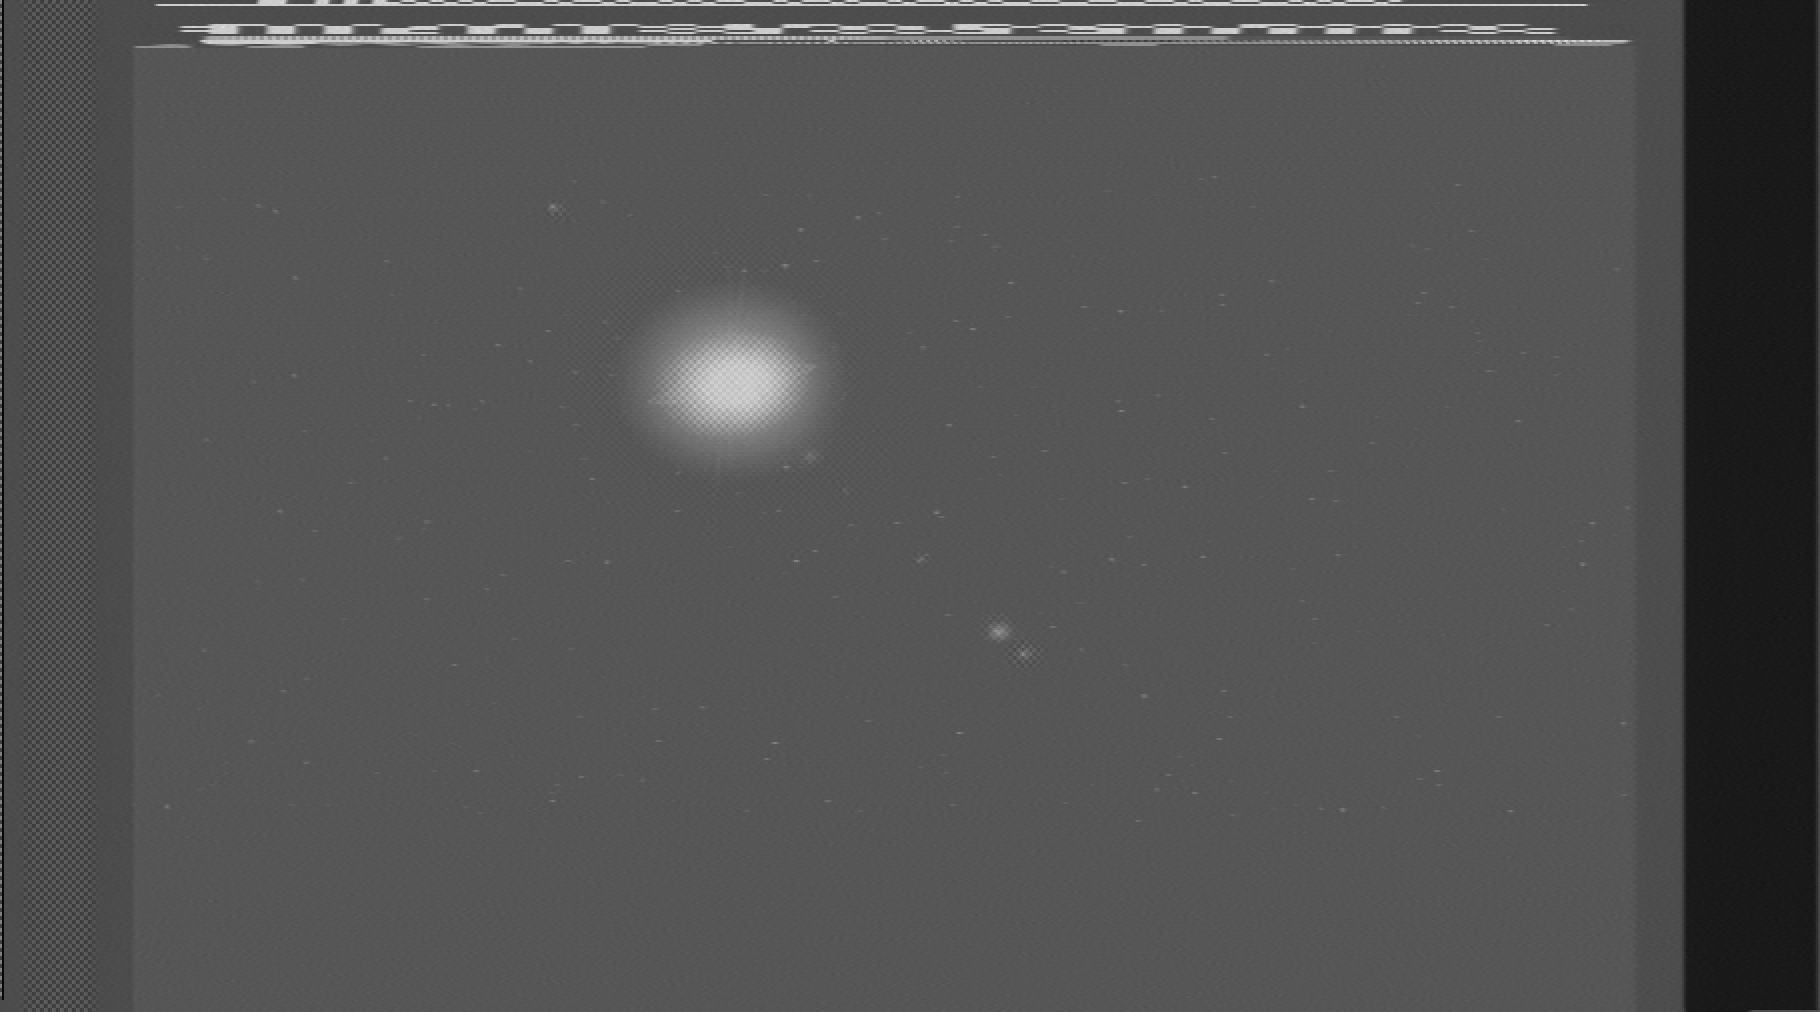

In [89]:
drawdata(output_fullframe, outwidth, 506, hscale=2, vscale=2)

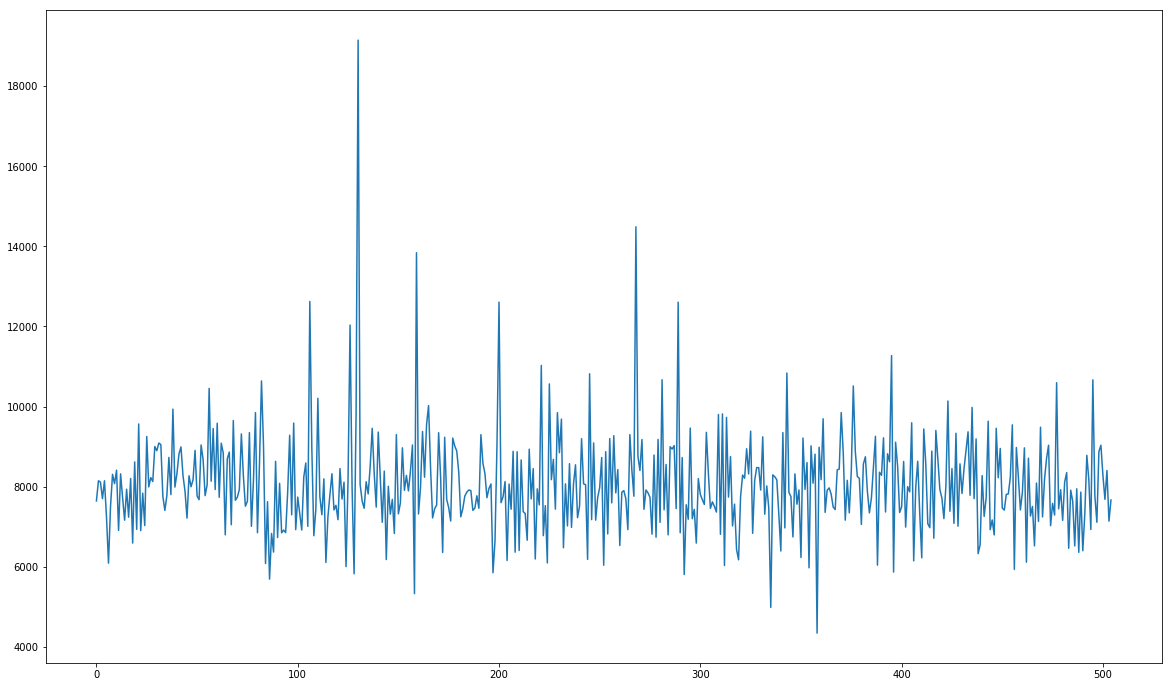

In [130]:
z = [output_fullframe[(l * 910):((l + 1) * 910)][848] for l in range(0,505)]
plt.plot(z)

In [151]:
z = [calczc(combined, (l * 910) + 840, iretohz(-15), 15) for l in range(0,505)]

z = []
for l in range(0,505):
    try:
        z.append(calczc(combined, (l * 910) + 841, iretohz(-15), 6) - (l * 910))
    except:
        print(l)
        z.append(None)

130


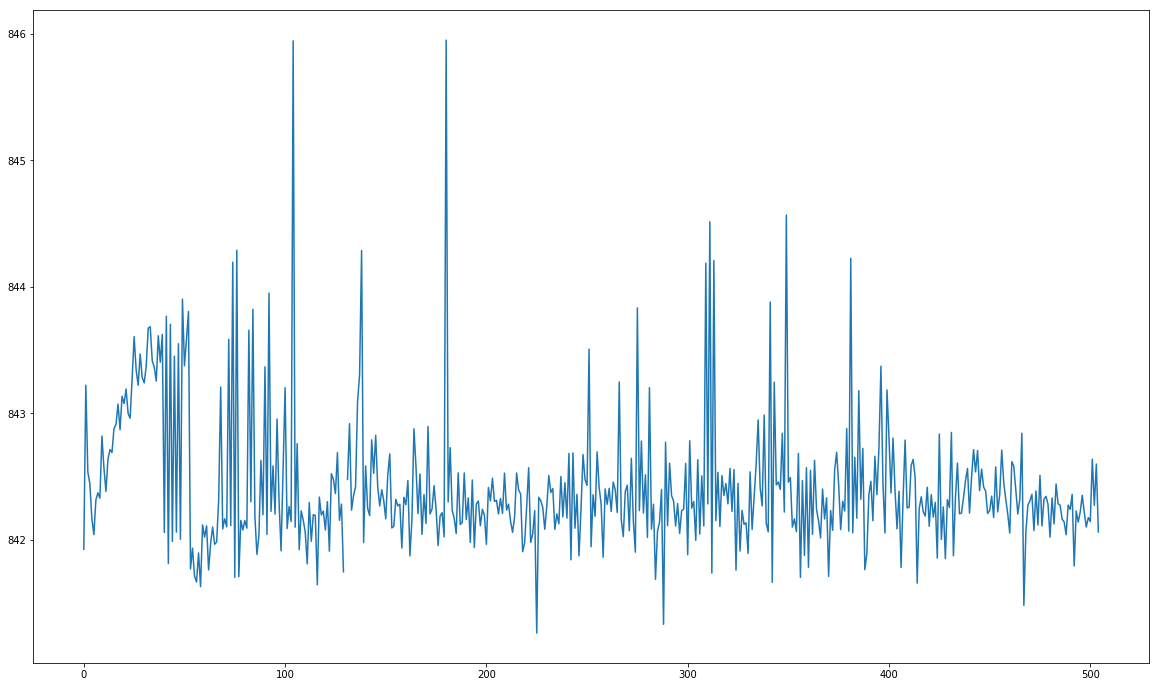

In [152]:
plt.plot(z)

In [120]:
plt.plot(output_fullframe[:,8])

IndexError: too many indices for array

In [57]:
outfsc = 4
outwidth = int(outfsc * 227.5)

#d, rdata = findfirstframe(infile, 1024*1024*10400)
d, rdata = findfirstframe(infile, 1024*1024*200)

print(d)

start = d - int(50 * filterset['line_px'])

outfd = open('tmp.tbc', 'wb')

for f in range(0,90):
    frame = demod(infile, start, start + int(650 * filterset['line_px']), filterset, needmtf)
    fs = findsync(frame['demod_sync'], 0)
    print(fs)

    ilinepx = int(filterset['line_px'])

    syncloc1, firstfield, line1 = findsync(frame['demod_sync'], 0)
    print(syncloc1, firstfield, line1)

    # need a margin before sync peak
    start1 = syncloc1 - int(15 * filterset['line_px'])
    print(start, start1)
    lines_odd, lineinfo_odd, lines_odd_cburst = buildfield(frame, start1, outfsc=outfsc)

    syncloc2, secondfield, line2 = findsync(frame['demod_sync'], int(lineinfo_odd[-20]))
    print(syncloc2, secondfield, line2)

    start2 = syncloc2 - int(15 * filterset['line_px'])
    lines_even, lineinfo_even, lines_even_cburst = buildfield(frame, start2, outfsc=outfsc)

    combined = np.zeros((outwidth * 506), dtype=np.double)
    for i in range(0, 505, 2):
        combined[((i + 0) * outwidth):((i + 1) * outwidth)] = lines_even[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]
        combined[((i + 1) * outwidth):((i + 2) * outwidth)] = lines_odd[(i // 2) * outwidth: ((i // 2) + 1) * outwidth]

    #calcsnr(frame['demod'][int(lineinfo_even[1]+400):int(lineinfo_even[1]+1600)]), calcsnr(frame['demod'][int(lineinfo_even[2]+400):int(lineinfo_even[2]+1600)])    
    output_fullframe, output_cropped = formatoutput(combined, lines_odd_cburst, lines_even_cburst)
    
    outfd.write(output_cropped)
    
    start = start + int(lineinfo_even[-30])
    print(start)

209715200
b
210020000
210324800
b
210629600
210934400
b
211239200
211544000
b
211848800
a
212103623
c
212713223
212825862
(111443, False, 126999)
111443 False 126999
212698862 73343
1 841.696021216 814.0597954366641
2 841.613797285 814.0597954366641
3 841.64198742 814.0597954366641
4 841.610627662 814.0597954366641
5 841.565084542 814.0597954366641
6 841.524633001 814.0597954366641
7 841.835477509 814.0597954366641
8 841.396651532 814.0597954366641
9 841.299197109 814.0597954366641
10 841.644220087 814.0597954366641
11 841.573696841 814.0597954366641
12 841.503091221 814.0597954366641
13 841.752457253 814.0597954366641
14 841.398637891 814.0597954366641
15 841.712722841 814.0597954366641
16 841.583246708 814.0597954366641
17 841.465354205 814.0597954366641
18 841.402479423 814.0597954366641
19 841.294229269 814.0597954366641
20 841.498654523 814.0597954366641
21 841.467906337 814.0597954366641
22 841.496922917 814.0597954366641
23 841.737654848 814.0597954366641
24 841.659190073 814.05

779996 True 793022
1 841.482192117 814.0597954366641
2 841.206479068 814.0597954366641
3 841.329212842 814.0597954366641
4 841.452393489 814.0597954366641
5 841.501337653 814.0597954366641
6 841.556019003 814.0597954366641
7 841.341857816 814.0597954366641
8 841.287592714 814.0597954366641
9 841.553507804 814.0597954366641
10 841.232261225 814.0597954366641
11 841.365169572 814.0597954366641
12 841.42314675 814.0597954366641
13 841.460121769 814.0597954366641
14 841.472088666 814.0597954366641
15 841.314133941 814.0597954366641
16 841.357855166 814.0597954366641
17 841.375975662 814.0597954366641
18 841.411881702 814.0597954366641
19 841.525619219 814.0597954366641
20 841.617036707 814.0597954366641
21 841.408097928 814.0597954366641
22 841.414448573 814.0597954366641
23 841.430297908 814.0597954366641
24 841.448175256 814.0597954366641
25 841.241493773 814.0597954366641
26 841.279250926 814.0597954366641
27 841.416964491 814.0597954366641
28 841.556055255 814.0597954366641
29 841.5369

252 841.451527135 814.0597954366641
214061556
(86048, False, 99068)
86048 False 99068
214061556 47948
1 841.531330096 814.0597954366641
2 841.620750486 814.0597954366641
3 841.603937026 814.0597954366641
4 841.708920535 814.0597954366641
5 841.169727541 814.0597954366641
6 841.257128668 814.0597954366641
7 841.513293151 814.0597954366641
8 841.509625638 814.0597954366641
9 841.250911881 814.0597954366641
10 841.524752594 814.0597954366641
11 841.485212271 814.0597954366641
12 841.302748042 814.0597954366641
13 841.323909935 814.0597954366641
14 841.623064476 814.0597954366641
15 841.54305109 814.0597954366641
16 841.319683008 814.0597954366641
17 841.418932379 814.0597954366641
18 841.420585195 814.0597954366641
19 841.429791373 814.0597954366641
20 841.526460311 814.0597954366641
21 841.465272818 814.0597954366641
22 841.34693659 814.0597954366641
23 841.330168946 814.0597954366641
24 841.482381398 814.0597954366641
25 841.302294976 814.0597954366641
26 841.507991039 814.0597954366641

754417 True 764898
1 841.117004719 814.0597954366641
2 841.42961465 814.0597954366641
3 841.334577811 814.0597954366641
4 841.419621848 814.0597954366641
5 841.571359717 814.0597954366641
6 841.647291602 814.0597954366641
7 841.331047676 814.0597954366641
8 841.26306484 814.0597954366641
9 841.248331144 814.0597954366641
10 841.406012427 814.0597954366641
11 841.371032205 814.0597954366641
12 841.367099819 814.0597954366641
13 841.539338365 814.0597954366641
14 841.150833074 814.0597954366641
15 841.335188557 814.0597954366641
16 841.328321736 814.0597954366641
17 841.599852479 814.0597954366641
18 841.426962115 814.0597954366641
19 841.388589815 814.0597954366641
20 841.283080708 814.0597954366641
21 841.457492254 814.0597954366641
22 841.294399318 814.0597954366641
23 841.413115502 814.0597954366641
24 841.611402331 814.0597954366641
25 841.454096365 814.0597954366641
26 841.293217155 814.0597954366641
27 841.496298607 814.0597954366641
28 841.386846421 814.0597954366641
29 841.61407

215396197
(88619, False, 99101)
88619 False 99101
215396197 50519
1 841.507570727 814.0597954366641
2 841.362945151 814.0597954366641
3 841.596801032 814.0597954366641
4 841.535660451 814.0597954366641
5 841.375070592 814.0597954366641
6 841.494021326 814.0597954366641
7 841.396988922 814.0597954366641
8 841.344728672 814.0597954366641
9 841.200535725 814.0597954366641
10 841.395029718 814.0597954366641
11 841.489958173 814.0597954366641
12 841.358954391 814.0597954366641
13 841.52896495 814.0597954366641
14 841.708951451 814.0597954366641
15 841.55038999 814.0597954366641
16 841.372646613 814.0597954366641
17 841.487517656 814.0597954366641
18 841.64860975 814.0597954366641
19 841.399902939 814.0597954366641
20 841.549044503 814.0597954366641
21 841.726110159 814.0597954366641
22 841.483068883 814.0597954366641
23 841.46784324 814.0597954366641
24 841.543217764 814.0597954366641
25 841.410212899 814.0597954366641
26 841.453854451 814.0597954366641
27 841.610372216 814.0597954366641
28

754508 True 764983
1 841.473027808 814.0597954366641
2 841.562325632 814.0597954366641
3 841.689354685 814.0597954366641
4 841.410340648 814.0597954366641
5 841.423691596 814.0597954366641
6 841.463649173 814.0597954366641
7 841.562258245 814.0597954366641
8 841.537284989 814.0597954366641
9 841.347686689 814.0597954366641
10 841.355247457 814.0597954366641
11 841.451143918 814.0597954366641
12 841.478903979 814.0597954366641
13 841.550352973 814.0597954366641
14 841.576707844 814.0597954366641
15 841.329401602 814.0597954366641
16 841.455184488 814.0597954366641
17 841.535595167 814.0597954366641
18 841.63142863 814.0597954366641
19 841.382631261 814.0597954366641
20 841.439377122 814.0597954366641
21 841.519996687 814.0597954366641
22 841.318305014 814.0597954366641
23 841.669146514 814.0597954366641
24 841.44597495 814.0597954366641
25 841.432507019 814.0597954366641
26 841.640269424 814.0597954366641
27 841.669124405 814.0597954366641
28 841.450556491 814.0597954366641
29 841.50345

238 841.634500267 814.0597954366641
239 841.589668939 814.0597954366641
240 841.570528248 814.0597954366641
241 841.304074294 814.0597954366641
242 841.366479605 814.0597954366641
243 841.350725103 814.0597954366641
244 841.403827121 814.0597954366641
245 841.472948316 814.0597954366641
246 841.467604511 814.0597954366641
247 841.389245384 814.0597954366641
248 841.429802773 814.0597954366641
249 841.323205692 814.0597954366641
250 841.367739519 814.0597954366641
251 841.336077725 814.0597954366641
252 841.569502876 814.0597954366641
216730798
(88627, False, 99109)
88627 False 99109
216730798 50527
1 841.325193663 814.0597954366641
2 841.496018283 814.0597954366641
3 841.363138267 814.0597954366641
4 841.337450028 814.0597954366641
5 841.350575157 814.0597954366641
6 841.627319711 814.0597954366641
7 841.603716971 814.0597954366641
8 841.523170691 814.0597954366641
9 841.426786885 814.0597954366641
10 841.461614431 814.0597954366641
11 841.374702704 814.0597954366641
12 841.670945675 8

252 841.522489569 814.0597954366641
752159 True 765174
1 841.628958543 814.0597954366641
2 841.546791154 814.0597954366641
3 841.4915213 814.0597954366641
4 841.411794771 814.0597954366641
5 841.407746802 814.0597954366641
6 841.29751908 814.0597954366641
7 841.632249433 814.0597954366641
8 841.327028307 814.0597954366641
9 841.509570216 814.0597954366641
10 841.470619953 814.0597954366641
11 841.434438237 814.0597954366641
12 841.44900506 814.0597954366641
13 841.678392742 814.0597954366641
14 841.673884335 814.0597954366641
15 841.637391849 814.0597954366641
16 841.53841125 814.0597954366641
17 841.499169272 814.0597954366641
18 841.404679622 814.0597954366641
19 841.289616469 814.0597954366641
20 841.361987157 814.0597954366641
21 841.579601006 814.0597954366641
22 841.594283068 814.0597954366641
23 841.504939622 814.0597954366641
24 841.458005341 814.0597954366641
25 841.504492 814.0597954366641
26 841.449863848 814.0597954366641
27 841.738836116 814.0597954366641
28 841.646526569 

218065360
(88645, False, 99129)
88645 False 99129
218065360 50545
1 841.494847438 814.0597954366641
2 841.333189302 814.0597954366641
3 841.397111823 814.0597954366641
4 841.401975397 814.0597954366641
5 841.310817157 814.0597954366641
6 841.410956021 814.0597954366641
7 841.444119636 814.0597954366641
8 841.586130741 814.0597954366641
9 841.27853975 814.0597954366641
10 841.425070755 814.0597954366641
11 841.359424397 814.0597954366641
12 841.254337534 814.0597954366641
13 841.278913044 814.0597954366641
14 841.36457387 814.0597954366641
15 841.426793885 814.0597954366641
16 841.48664665 814.0597954366641
17 841.250027067 814.0597954366641
18 841.3088252 814.0597954366641
19 841.356138114 814.0597954366641
20 841.386430205 814.0597954366641
21 841.529080631 814.0597954366641
22 841.469671288 814.0597954366641
23 841.63565185 814.0597954366641
24 841.386478973 814.0597954366641
25 841.405782137 814.0597954366641
26 841.538999443 814.0597954366641
27 841.54705198 814.0597954366641
28 84

754868 True 765347
1 841.490446205 814.0597954366641
2 841.530354325 814.0597954366641
3 841.471646821 814.0597954366641
4 841.418078581 814.0597954366641
5 841.358942467 814.0597954366641
6 841.355459582 814.0597954366641
7 841.362000599 814.0597954366641
8 841.377633192 814.0597954366641
9 841.232185904 814.0597954366641
10 841.598947626 814.0597954366641
11 841.659397737 814.0597954366641
12 841.683053234 814.0597954366641
13 841.61323415 814.0597954366641
14 841.709210913 814.0597954366641
15 841.254503483 814.0597954366641
16 841.231824666 814.0597954366641
17 841.498206523 814.0597954366641
18 841.538347847 814.0597954366641
19 841.549140566 814.0597954366641
20 841.482974198 814.0597954366641
21 841.460991618 814.0597954366641
22 841.529775028 814.0597954366641
23 841.258404075 814.0597954366641
24 841.503144793 814.0597954366641
25 841.45102315 814.0597954366641
26 841.428795891 814.0597954366641
27 841.462584775 814.0597954366641
28 841.293962423 814.0597954366641
29 841.31731

252 841.542564115 814.0597954366641
219400015
(86030, False, 99051)
86030 False 99051
219400015 47930
1 841.564264448 814.0597954366641
2 841.619728393 814.0597954366641
3 841.630293619 814.0597954366641
4 841.428108747 814.0597954366641
5 841.535953819 814.0597954366641
6 841.31238582 814.0597954366641
7 841.377206097 814.0597954366641
8 841.436454395 814.0597954366641
9 841.163990262 814.0597954366641
10 841.371071527 814.0597954366641
11 841.492805139 814.0597954366641
12 841.394545344 814.0597954366641
13 841.548606897 814.0597954366641
14 841.408163287 814.0597954366641
15 841.494378638 814.0597954366641
16 841.684146104 814.0597954366641
17 841.220907025 814.0597954366641
18 841.344818766 814.0597954366641
19 841.416996794 814.0597954366641
20 841.590780675 814.0597954366641
21 841.206612214 814.0597954366641
22 841.517899741 814.0597954366641
23 841.455821339 814.0597954366641
24 841.38663976 814.0597954366641
25 841.375639797 814.0597954366641
26 841.408747893 814.0597954366641

754863 True 765345
1 841.554369712 814.0597954366641
2 841.302744059 814.0597954366641
3 841.565370824 814.0597954366641
4 841.466967771 814.0597954366641
5 841.556588826 814.0597954366641
6 841.405906076 814.0597954366641
7 841.384934531 814.0597954366641
8 841.37070503 814.0597954366641
9 841.255120356 814.0597954366641
10 841.468655113 814.0597954366641
11 841.427036674 814.0597954366641
12 841.433809674 814.0597954366641
13 841.376336262 814.0597954366641
14 841.292311603 814.0597954366641
15 841.058287012 814.0597954366641
16 841.440792344 814.0597954366641
17 841.358092717 814.0597954366641
18 841.648518469 814.0597954366641
19 841.55422631 814.0597954366641
20 841.486120214 814.0597954366641
21 841.40150434 814.0597954366641
22 841.599103418 814.0597954366641
23 841.512534528 814.0597954366641
24 841.362383668 814.0597954366641
25 841.634580215 814.0597954366641
26 841.2086662 814.0597954366641
27 841.332219305 814.0597954366641
28 841.577821081 814.0597954366641
29 841.46731150

220734793
(88552, False, 99027)
88552 False 99027
220734793 50452
1 841.401943357 814.0597954366641
2 841.4778174 814.0597954366641
3 841.581864821 814.0597954366641
4 841.618159688 814.0597954366641
5 841.651795997 814.0597954366641
6 841.424985218 814.0597954366641
7 841.379282898 814.0597954366641
8 841.52656356 814.0597954366641
9 841.510612774 814.0597954366641
10 841.681243454 814.0597954366641
11 841.35063565 814.0597954366641
12 841.420392386 814.0597954366641
13 841.456248587 814.0597954366641
14 841.460077817 814.0597954366641
15 841.523189561 814.0597954366641
16 841.543587072 814.0597954366641
17 841.61110526 814.0597954366641
18 841.608341621 814.0597954366641
19 841.713825142 814.0597954366641
20 841.45601229 814.0597954366641
21 841.433593142 814.0597954366641
22 841.576657981 814.0597954366641
23 841.570945264 814.0597954366641
24 841.524692792 814.0597954366641
25 841.634143373 814.0597954366641
26 841.388032985 814.0597954366641
27 841.377728591 814.0597954366641
28 8

757244 True 765184
1 841.416984848 814.0597954366641
2 841.382352127 814.0597954366641
3 841.370799559 814.0597954366641
4 841.369540284 814.0597954366641
5 841.38431268 814.0597954366641
6 841.313670835 814.0597954366641
7 841.304455401 814.0597954366641
8 841.298791505 814.0597954366641
9 841.590554459 814.0597954366641
10 841.469897526 814.0597954366641
11 841.406221357 814.0597954366641
12 841.518250441 814.0597954366641
13 841.377337085 814.0597954366641
14 841.641811705 814.0597954366641
15 841.588240408 814.0597954366641
16 841.450152418 814.0597954366641
17 841.418769647 814.0597954366641
18 841.340882056 814.0597954366641
19 841.414154424 814.0597954366641
20 841.634278563 814.0597954366641
21 841.437773593 814.0597954366641
22 841.38697943 814.0597954366641
23 841.339338268 814.0597954366641
24 841.473123613 814.0597954366641
25 841.57402866 814.0597954366641
26 841.500159912 814.0597954366641
27 841.385304225 814.0597954366641
28 841.316462336 814.0597954366641
29 841.622830

222069576
(88572, False, 99047)
88572 False 99047
222069576 50472
1 841.546820979 814.0597954366641
2 841.364361972 814.0597954366641
3 841.527925399 814.0597954366641
4 841.366752378 814.0597954366641
5 841.248225485 814.0597954366641
6 841.341827615 814.0597954366641
7 841.315380754 814.0597954366641
8 841.419528476 814.0597954366641
9 841.764762685 814.0597954366641
10 841.475258201 814.0597954366641
11 841.308237542 814.0597954366641
12 841.377160646 814.0597954366641
13 841.375969899 814.0597954366641
14 841.316862718 814.0597954366641
15 841.242993312 814.0597954366641
16 841.532058222 814.0597954366641
17 841.654427583 814.0597954366641
18 841.507126672 814.0597954366641
19 841.549791455 814.0597954366641
20 841.492022252 814.0597954366641
21 841.419147442 814.0597954366641
22 841.404208134 814.0597954366641
23 841.285881379 814.0597954366641
24 841.637785124 814.0597954366641
25 841.400290808 814.0597954366641
26 841.429000419 814.0597954366641
27 841.685849539 814.059795436664

754486 True 764971
1 841.497476252 814.0597954366641
2 841.310988995 814.0597954366641
3 841.476898478 814.0597954366641
4 841.268061751 814.0597954366641
5 841.563428016 814.0597954366641
6 841.548424153 814.0597954366641
7 841.265198706 814.0597954366641
8 841.402400449 814.0597954366641
9 841.655953279 814.0597954366641
10 841.548957664 814.0597954366641
11 841.295314259 814.0597954366641
12 841.330071187 814.0597954366641
13 841.269792414 814.0597954366641
14 841.440487481 814.0597954366641
15 841.165114759 814.0597954366641
16 841.465535446 814.0597954366641
17 841.477262255 814.0597954366641
18 841.682726789 814.0597954366641
19 841.425317508 814.0597954366641
20 841.535930425 814.0597954366641
21 841.395415916 814.0597954366641
22 841.508184842 814.0597954366641
23 841.324612111 814.0597954366641
24 841.378752486 814.0597954366641
25 841.289780386 814.0597954366641
26 841.297944511 814.0597954366641
27 841.402236912 814.0597954366641
28 841.492632072 814.0597954366641
29 841.587

223404256
(88600, False, 99079)
88600 False 99079
223404256 50500
1 841.448133136 814.0597954366641
2 841.521011963 814.0597954366641
3 841.611367877 814.0597954366641
4 841.275987866 814.0597954366641
5 841.698149947 814.0597954366641
6 841.456868693 814.0597954366641
7 841.473974186 814.0597954366641
8 841.464258166 814.0597954366641
9 841.460513526 814.0597954366641
10 841.603341984 814.0597954366641
11 841.596004584 814.0597954366641
12 841.601671938 814.0597954366641
13 841.626745474 814.0597954366641
14 841.625665638 814.0597954366641
15 841.368520338 814.0597954366641
16 841.335698073 814.0597954366641
17 841.581033515 814.0597954366641
18 841.426616073 814.0597954366641
19 841.641520794 814.0597954366641
20 841.370637214 814.0597954366641
21 841.262945949 814.0597954366641
22 841.423262982 814.0597954366641
23 841.35244929 814.0597954366641
24 841.337064365 814.0597954366641
25 841.391176009 814.0597954366641
26 841.727008754 814.0597954366641
27 841.310350379 814.0597954366641

754426 True 764902
1 841.313193089 814.0597954366641
2 841.508489495 814.0597954366641
3 841.4050565 814.0597954366641
4 841.504684349 814.0597954366641
5 841.326187995 814.0597954366641
6 841.581756412 814.0597954366641
7 841.455785262 814.0597954366641
8 841.432252443 814.0597954366641
9 841.515752763 814.0597954366641
10 841.427475281 814.0597954366641
11 841.407768185 814.0597954366641
12 841.666256051 814.0597954366641
13 841.646834949 814.0597954366641
14 841.543929275 814.0597954366641
15 841.583582896 814.0597954366641
16 841.492432913 814.0597954366641
17 841.423856886 814.0597954366641
18 841.413174878 814.0597954366641
19 841.461561924 814.0597954366641
20 841.43102488 814.0597954366641
21 841.398792141 814.0597954366641
22 841.399107307 814.0597954366641
23 841.570406029 814.0597954366641
24 841.556312856 814.0597954366641
25 841.34768695 814.0597954366641
26 841.313427528 814.0597954366641
27 841.461617908 814.0597954366641
28 841.611962276 814.0597954366641
29 841.3920960

224738872
(84805, False, 99102)
84805 False 99102
224738872 46705
1 841.263046192 814.0597954366641
2 841.516050619 814.0597954366641
3 841.589759999 814.0597954366641
4 841.241324202 814.0597954366641
5 841.443866742 814.0597954366641
6 841.49003053 814.0597954366641
7 841.426984909 814.0597954366641
8 841.38834421 814.0597954366641
9 841.313613626 814.0597954366641
10 841.674746171 814.0597954366641
11 841.675977898 814.0597954366641
12 841.313186817 814.0597954366641
13 841.30392168 814.0597954366641
14 841.495789795 814.0597954366641
15 841.629732059 814.0597954366641
16 841.674652786 814.0597954366641
17 841.561661759 814.0597954366641
18 841.494113746 814.0597954366641
19 841.532421978 814.0597954366641
20 841.483007538 814.0597954366641
21 841.552673322 814.0597954366641
22 841.458079728 814.0597954366641
23 841.413047433 814.0597954366641
24 841.436076328 814.0597954366641
25 841.499887911 814.0597954366641
26 841.403971625 814.0597954366641
27 841.429419761 814.0597954366641
2

757127 True 765060
1 841.42811385 814.0597954366641
2 841.728269895 814.0597954366641
3 841.425869772 814.0597954366641
4 841.443160062 814.0597954366641
5 841.471920284 814.0597954366641
6 841.453428202 814.0597954366641
7 841.437180874 814.0597954366641
8 841.52555666 814.0597954366641
9 841.467456119 814.0597954366641
10 841.471949603 814.0597954366641
11 841.608145773 814.0597954366641
12 841.208714828 814.0597954366641
13 841.646150325 814.0597954366641
14 841.643081412 814.0597954366641
15 841.355770554 814.0597954366641
16 841.517903734 814.0597954366641
17 841.539303036 814.0597954366641
18 841.507508022 814.0597954366641
19 841.650927733 814.0597954366641
20 841.385081152 814.0597954366641
21 841.355784778 814.0597954366641
22 841.436403026 814.0597954366641
23 841.485083067 814.0597954366641
24 841.563205593 814.0597954366641
25 841.580294141 814.0597954366641
26 841.309929069 814.0597954366641
27 841.449972132 814.0597954366641
28 841.48664922 814.0597954366641
29 841.605671

226073469
(88629, False, 99113)
88629 False 99113
226073469 50529
1 841.410160844 814.0597954366641
2 841.282236555 814.0597954366641
3 841.39762941 814.0597954366641
4 841.465471914 814.0597954366641
5 841.509672029 814.0597954366641
6 841.308160028 814.0597954366641
7 841.30883431 814.0597954366641
8 841.430474849 814.0597954366641
9 841.48392274 814.0597954366641
10 841.336648119 814.0597954366641
11 841.359296662 814.0597954366641
12 841.420900812 814.0597954366641
13 841.444230977 814.0597954366641
14 841.182111598 814.0597954366641
15 841.284668097 814.0597954366641
16 841.265788881 814.0597954366641
17 841.363773818 814.0597954366641
18 841.369614924 814.0597954366641
19 841.394991763 814.0597954366641
20 841.459369603 814.0597954366641
21 841.536125635 814.0597954366641
22 841.504166673 814.0597954366641
23 841.508302636 814.0597954366641
24 841.519219758 814.0597954366641
25 841.578437796 814.0597954366641
26 841.442526599 814.0597954366641
27 841.455241736 814.0597954366641
2

754776 True 765253
1 841.36789063 814.0597954366641
2 841.482059278 814.0597954366641
3 841.354824591 814.0597954366641
4 841.504816214 814.0597954366641
5 841.558902205 814.0597954366641
6 841.621918225 814.0597954366641
7 841.49272158 814.0597954366641
8 841.452812347 814.0597954366641
9 841.608222735 814.0597954366641
10 841.483342148 814.0597954366641
11 841.553793402 814.0597954366641
12 841.519954812 814.0597954366641
13 841.353954289 814.0597954366641
14 841.432453514 814.0597954366641
15 841.419520879 814.0597954366641
16 841.50211916 814.0597954366641
17 841.608173216 814.0597954366641
18 841.639599368 814.0597954366641
19 841.667157962 814.0597954366641
20 841.717116811 814.0597954366641
21 841.315199623 814.0597954366641
22 841.602755279 814.0597954366641
23 841.435916004 814.0597954366641
24 841.472179773 814.0597954366641
25 841.45639762 814.0597954366641
26 841.482245311 814.0597954366641
27 841.465767823 814.0597954366641
28 841.403587608 814.0597954366641
29 841.4386500

227408027
(86088, False, 99117)
86088 False 99117
227408027 47988
1 841.399878485 814.0597954366641
2 841.237078319 814.0597954366641
3 841.521267393 814.0597954366641
4 841.421502824 814.0597954366641
5 841.29454984 814.0597954366641
6 841.323918754 814.0597954366641
7 841.434473981 814.0597954366641
8 841.438730468 814.0597954366641
9 841.396339323 814.0597954366641
10 841.53955296 814.0597954366641
11 841.382959535 814.0597954366641
12 841.312761379 814.0597954366641
13 841.490532579 814.0597954366641
14 841.345981111 814.0597954366641
15 841.286391403 814.0597954366641
16 841.529641983 814.0597954366641
17 841.359016625 814.0597954366641
18 841.483428503 814.0597954366641
19 841.38273934 814.0597954366641
20 841.293833284 814.0597954366641
21 841.456226172 814.0597954366641
22 841.29253677 814.0597954366641
23 841.469670454 814.0597954366641
24 841.343638423 814.0597954366641
25 841.461614153 814.0597954366641
26 841.37588149 814.0597954366641
27 841.576119752 814.0597954366641
28 

757455 True 765393
1 841.503066299 814.0597954366641
2 841.434124066 814.0597954366641
3 841.449880396 814.0597954366641
4 841.351153484 814.0597954366641
5 841.319858795 814.0597954366641
6 841.504874586 814.0597954366641
7 841.503518025 814.0597954366641
8 841.499515284 814.0597954366641
9 841.380940985 814.0597954366641
10 841.564086246 814.0597954366641
11 841.503918371 814.0597954366641
12 841.542679045 814.0597954366641
13 841.372778383 814.0597954366641
14 841.348646273 814.0597954366641
15 841.541232263 814.0597954366641
16 841.491661873 814.0597954366641
17 841.650438032 814.0597954366641
18 841.261933036 814.0597954366641
19 841.270617609 814.0597954366641
20 841.396127189 814.0597954366641
21 841.282786707 814.0597954366641
22 841.409955676 814.0597954366641
23 841.40780405 814.0597954366641
24 841.497619513 814.0597954366641
25 841.45699562 814.0597954366641
26 841.571825384 814.0597954366641
27 841.165329183 814.0597954366641
28 841.525497778 814.0597954366641
29 841.46355

228742764
(86019, False, 99035)
86019 False 99035
228742764 47919
1 841.285220696 814.0597954366641
2 841.395438761 814.0597954366641
3 841.435974149 814.0597954366641
4 841.610897055 814.0597954366641
5 841.456417694 814.0597954366641
6 841.654549393 814.0597954366641
7 841.459793222 814.0597954366641
8 841.235832966 814.0597954366641
9 841.385799789 814.0597954366641
10 841.491608141 814.0597954366641
11 841.304387956 814.0597954366641
12 841.418365648 814.0597954366641
13 841.371986425 814.0597954366641
14 841.423606904 814.0597954366641
15 841.222793312 814.0597954366641
16 841.431623823 814.0597954366641
17 841.500522452 814.0597954366641
18 841.49706745 814.0597954366641
19 841.338114557 814.0597954366641
20 841.418192317 814.0597954366641
21 841.622428219 814.0597954366641
22 841.52599217 814.0597954366641
23 841.441580801 814.0597954366641
24 841.58675883 814.0597954366641
25 841.308911936 814.0597954366641
26 841.325742662 814.0597954366641
27 841.560692729 814.0597954366641
2

752254 True 765278
1 841.538280579 814.0597954366641
2 841.389261399 814.0597954366641
3 841.338303443 814.0597954366641
4 841.297509107 814.0597954366641
5 841.326258209 814.0597954366641
6 841.590329618 814.0597954366641
7 841.532523909 814.0597954366641
8 841.409038221 814.0597954366641
9 841.326504121 814.0597954366641
10 841.421122343 814.0597954366641
11 841.359454821 814.0597954366641
12 841.563231917 814.0597954366641
13 841.624468539 814.0597954366641
14 841.478175796 814.0597954366641
15 841.445142017 814.0597954366641
16 841.459009926 814.0597954366641
17 841.422610802 814.0597954366641
18 841.407404539 814.0597954366641
19 841.380473578 814.0597954366641
20 841.363156172 814.0597954366641
21 841.306094599 814.0597954366641
22 841.677498779 814.0597954366641
23 841.502933139 814.0597954366641
24 841.565351082 814.0597954366641
25 841.46661451 814.0597954366641
26 841.590366998 814.0597954366641
27 841.441880799 814.0597954366641
28 841.401507458 814.0597954366641
29 841.4078

230077557
(86009, False, 99023)
86009 False 99023
230077557 47909
1 841.479375752 814.0597954366641
2 841.430741893 814.0597954366641
3 841.319124414 814.0597954366641
4 841.630295996 814.0597954366641
5 841.405938359 814.0597954366641
6 841.38080025 814.0597954366641
7 841.730109717 814.0597954366641
8 841.639160635 814.0597954366641
9 841.542664007 814.0597954366641
10 841.523191159 814.0597954366641
11 841.490051421 814.0597954366641
12 841.741221966 814.0597954366641
13 841.710499649 814.0597954366641
14 841.303519564 814.0597954366641
15 841.651168697 814.0597954366641
16 841.581682748 814.0597954366641
17 841.534260627 814.0597954366641
18 841.522538112 814.0597954366641
19 841.425216786 814.0597954366641
20 841.391693906 814.0597954366641
21 841.553448126 814.0597954366641
22 841.410221652 814.0597954366641
23 841.417559461 814.0597954366641
24 841.339100723 814.0597954366641
25 841.437968701 814.0597954366641
26 841.385066757 814.0597954366641
27 841.361751389 814.0597954366641

757149 True 765089
1 841.476536181 814.0597954366641
2 841.466910019 814.0597954366641
3 841.471285742 814.0597954366641
4 841.580044798 814.0597954366641
5 841.195484369 814.0597954366641
6 841.281235167 814.0597954366641
7 841.319863301 814.0597954366641
8 841.361259135 814.0597954366641
9 841.468265335 814.0597954366641
10 841.397933358 814.0597954366641
11 841.618265374 814.0597954366641
12 841.570321576 814.0597954366641
13 841.384173029 814.0597954366641
14 841.362266439 814.0597954366641
15 841.490808113 814.0597954366641
16 841.249057834 814.0597954366641
17 841.652472467 814.0597954366641
18 841.321767205 814.0597954366641
19 841.560791741 814.0597954366641
20 841.60130256 814.0597954366641
21 841.260416566 814.0597954366641
22 841.377240335 814.0597954366641
23 841.401567951 814.0597954366641
24 841.576123556 814.0597954366641
25 841.291928931 814.0597954366641
26 841.305764331 814.0597954366641
27 841.414727424 814.0597954366641
28 841.457415221 814.0597954366641
29 841.4123

231412295
(86045, False, 99064)
86045 False 99064
231412295 47945
1 841.744756648 814.0597954366641
2 841.541289223 814.0597954366641
3 841.487936469 814.0597954366641
4 841.418590318 814.0597954366641
5 841.442774069 814.0597954366641
6 841.604786356 814.0597954366641
7 841.497351661 814.0597954366641
8 841.340904943 814.0597954366641
9 841.627354956 814.0597954366641
10 841.463877612 814.0597954366641
11 841.635245885 814.0597954366641
12 841.451515569 814.0597954366641
13 841.359477009 814.0597954366641
14 841.440304744 814.0597954366641
15 841.649330003 814.0597954366641
16 841.580280614 814.0597954366641
17 841.320965874 814.0597954366641
18 841.529561591 814.0597954366641
19 841.626812021 814.0597954366641
20 841.462901674 814.0597954366641
21 841.612927056 814.0597954366641
22 841.363015415 814.0597954366641
23 841.542827224 814.0597954366641
24 841.335050386 814.0597954366641
25 841.326003127 814.0597954366641
26 841.536095666 814.0597954366641
27 841.208932739 814.059795436664

751883 True 764909
1 841.60428606 814.0597954366641
2 841.49564244 814.0597954366641
3 841.493069378 814.0597954366641
4 841.377895083 814.0597954366641
5 841.425251204 814.0597954366641
6 841.654969794 814.0597954366641
7 841.399667574 814.0597954366641
8 841.486611051 814.0597954366641
9 841.46963616 814.0597954366641
10 841.197368376 814.0597954366641
11 841.532326749 814.0597954366641
12 841.330092123 814.0597954366641
13 841.559305882 814.0597954366641
14 841.473763212 814.0597954366641
15 841.29153502 814.0597954366641
16 841.544197933 814.0597954366641
17 841.315335922 814.0597954366641
18 841.596816888 814.0597954366641
19 841.209090742 814.0597954366641
20 841.358508441 814.0597954366641
21 841.556517308 814.0597954366641
22 841.533400293 814.0597954366641
23 841.410423722 814.0597954366641
24 841.391625651 814.0597954366641
25 841.207772549 814.0597954366641
26 841.399287062 814.0597954366641
27 841.55690951 814.0597954366641
28 841.481252406 814.0597954366641
29 841.37505302

232746948
(86073, False, 99096)
86073 False 99096
232746948 47973
1 841.578979863 814.0597954366641
2 841.4638827 814.0597954366641
3 841.529921068 814.0597954366641
4 841.342756446 814.0597954366641
5 841.465444685 814.0597954366641
6 841.320087803 814.0597954366641
7 841.41561384 814.0597954366641
8 841.495139524 814.0597954366641
9 841.668894066 814.0597954366641
10 841.405584527 814.0597954366641
11 841.432913263 814.0597954366641
12 841.533374213 814.0597954366641
13 841.257244066 814.0597954366641
14 841.413188777 814.0597954366641
15 841.43372698 814.0597954366641
16 841.302024835 814.0597954366641
17 841.360431376 814.0597954366641
18 841.408689241 814.0597954366641
19 841.502261021 814.0597954366641
20 841.24397547 814.0597954366641
21 841.308629434 814.0597954366641
22 841.467342874 814.0597954366641
23 841.620018753 814.0597954366641
24 841.311743509 814.0597954366641
25 841.415600703 814.0597954366641
26 841.497175917 814.0597954366641
27 841.55203638 814.0597954366641
28 8

751942 True 764958
1 841.335672521 814.0597954366641
2 841.315142057 814.0597954366641
3 841.474140543 814.0597954366641
4 841.464977187 814.0597954366641
5 841.615117101 814.0597954366641
6 841.497541291 814.0597954366641
7 841.472662029 814.0597954366641
8 841.232650372 814.0597954366641
9 841.36782153 814.0597954366641
10 841.473328724 814.0597954366641
11 841.578413159 814.0597954366641
12 841.254511101 814.0597954366641
13 841.380842036 814.0597954366641
14 841.565072384 814.0597954366641
15 841.353388628 814.0597954366641
16 841.426305913 814.0597954366641
17 841.634655951 814.0597954366641
18 841.730630666 814.0597954366641
19 841.413805501 814.0597954366641
20 841.564887044 814.0597954366641
21 841.415549333 814.0597954366641
22 841.486418572 814.0597954366641
23 841.625899363 814.0597954366641
24 841.53130516 814.0597954366641
25 841.607169602 814.0597954366641
26 841.384431414 814.0597954366641
27 841.524042818 814.0597954366641
28 841.380246085 814.0597954366641
29 841.44993

234081557
(86080, False, 99104)
86080 False 99104
234081557 47980
1 841.510420938 814.0597954366641
2 841.653511258 814.0597954366641
3 841.473422143 814.0597954366641
4 841.451751006 814.0597954366641
5 841.541481088 814.0597954366641
6 841.425943931 814.0597954366641
7 841.457638391 814.0597954366641
8 841.296626133 814.0597954366641
9 841.303126396 814.0597954366641
10 841.294173639 814.0597954366641
11 841.511452479 814.0597954366641
12 841.537084168 814.0597954366641
13 841.542899084 814.0597954366641
14 841.449892477 814.0597954366641
15 841.438624091 814.0597954366641
16 841.431211994 814.0597954366641
17 841.387078319 814.0597954366641
18 841.404500647 814.0597954366641
19 841.252189503 814.0597954366641
20 841.59614273 814.0597954366641
21 841.523323697 814.0597954366641
22 841.518314124 814.0597954366641
23 841.450552123 814.0597954366641
24 841.664339168 814.0597954366641
25 841.41210103 814.0597954366641
26 841.351059469 814.0597954366641
27 841.637103156 814.0597954366641


250 841.514663755 814.0597954366641
251 841.773835741 814.0597954366641
252 842.036047136 814.0597954366641
757203 True 765136
1 841.452753158 814.0597954366641
2 841.648071121 814.0597954366641
3 841.601487363 814.0597954366641
4 841.32314571 814.0597954366641
5 841.497920567 814.0597954366641
6 841.503033355 814.0597954366641
7 841.410686839 814.0597954366641
8 841.369685922 814.0597954366641
9 841.729266865 814.0597954366641
10 841.691387587 814.0597954366641
11 841.627465611 814.0597954366641
12 841.49512566 814.0597954366641
13 841.5479307 814.0597954366641
14 841.41921926 814.0597954366641
15 841.621137797 814.0597954366641
16 841.479651164 814.0597954366641
17 841.420763627 814.0597954366641
18 841.298468094 814.0597954366641
19 841.282051977 814.0597954366641
20 841.611416598 814.0597954366641
21 841.562700283 814.0597954366641
22 841.359486321 814.0597954366641
23 841.34380436 814.0597954366641
24 841.646916639 814.0597954366641
25 841.518241678 814.0597954366641
26 841.781632

235416126
(86097, False, 99124)
86097 False 99124
235416126 47997
1 841.531411975 814.0597954366641
2 841.580974557 814.0597954366641
3 841.150027543 814.0597954366641
4 841.30397303 814.0597954366641
5 841.374429456 814.0597954366641
6 841.398426943 814.0597954366641
7 841.40635407 814.0597954366641
8 841.512333424 814.0597954366641
9 841.218255827 814.0597954366641
10 841.376664239 814.0597954366641
11 841.365652155 814.0597954366641
12 841.458498942 814.0597954366641
13 841.566360404 814.0597954366641
14 841.507807297 814.0597954366641
15 841.524823736 814.0597954366641
16 841.303797748 814.0597954366641
17 841.365460325 814.0597954366641
18 841.464103312 814.0597954366641
19 841.471196512 814.0597954366641
20 841.52603955 814.0597954366641
21 841.576168051 814.0597954366641
22 841.520433494 814.0597954366641
23 841.214477772 814.0597954366641
24 841.312203118 814.0597954366641
25 841.31086935 814.0597954366641
26 841.329100295 814.0597954366641
27 841.34087539 814.0597954366641
28 

754845 True 765323
1 841.445069216 814.0597954366641
2 841.403210949 814.0597954366641
3 841.39627266 814.0597954366641
4 841.428741942 814.0597954366641
5 841.327711053 814.0597954366641
6 841.471472462 814.0597954366641
7 841.357423266 814.0597954366641
8 841.37957119 814.0597954366641
9 841.302447536 814.0597954366641
10 841.619002595 814.0597954366641
11 841.256146596 814.0597954366641
12 841.578356976 814.0597954366641
13 841.23378048 814.0597954366641
14 841.460410581 814.0597954366641
15 841.518162393 814.0597954366641
16 841.516111645 814.0597954366641
17 841.422778693 814.0597954366641
18 841.501075289 814.0597954366641
19 841.674359095 814.0597954366641
20 841.653097472 814.0597954366641
21 841.591818852 814.0597954366641
22 841.700891175 814.0597954366641
23 841.432598955 814.0597954366641
24 841.396698057 814.0597954366641
25 841.312000232 814.0597954366641
26 841.541064414 814.0597954366641
27 841.494190223 814.0597954366641
28 841.408811304 814.0597954366641
29 841.614549

236750754
(86043, False, 99065)
86043 False 99065
236750754 47943
1 841.501279372 814.0597954366641
2 841.480799536 814.0597954366641
3 841.27970889 814.0597954366641
4 841.295458336 814.0597954366641
5 841.512751911 814.0597954366641
6 841.422261057 814.0597954366641
7 841.443093598 814.0597954366641
8 841.343807684 814.0597954366641
9 841.338779345 814.0597954366641
10 841.752874307 814.0597954366641
11 841.412460016 814.0597954366641
12 841.466803613 814.0597954366641
13 841.454248581 814.0597954366641
14 841.222864735 814.0597954366641
15 841.241300565 814.0597954366641
16 841.314928046 814.0597954366641
17 841.517540618 814.0597954366641
18 841.268280375 814.0597954366641
19 841.338358044 814.0597954366641
20 841.500085802 814.0597954366641
21 841.599886216 814.0597954366641
22 841.400550285 814.0597954366641
23 841.444300577 814.0597954366641
24 841.296269337 814.0597954366641
25 841.526939249 814.0597954366641
26 841.33019602 814.0597954366641
27 841.452160106 814.0597954366641


241 841.531442592 814.0597954366641
242 841.483430705 814.0597954366641
243 841.477024805 814.0597954366641
244 841.488212289 814.0597954366641
245 841.424767698 814.0597954366641
246 841.302173488 814.0597954366641
247 841.28712448 814.0597954366641
248 841.587163826 814.0597954366641
249 841.617120575 814.0597954366641
250 841.482881231 814.0597954366641
251 841.571434106 814.0597954366641
252 841.550953284 814.0597954366641
754886 True 765368
1 841.417823484 814.0597954366641
2 841.305001391 814.0597954366641
3 841.613792364 814.0597954366641
4 841.41942952 814.0597954366641
5 841.371182161 814.0597954366641
6 841.341407943 814.0597954366641
7 841.579940932 814.0597954366641
8 841.422495362 814.0597954366641
9 841.580985478 814.0597954366641
10 841.472448088 814.0597954366641
11 841.411004284 814.0597954366641
12 841.638546979 814.0597954366641
13 841.475612099 814.0597954366641
14 841.683433764 814.0597954366641
15 841.474873987 814.0597954366641
16 841.375193203 814.0597954366641


238085519
(88556, False, 99031)
88556 False 99031
238085519 50456
1 841.639051747 814.0597954366641
2 841.318537844 814.0597954366641
3 841.368326068 814.0597954366641
4 841.362793148 814.0597954366641
5 841.435031301 814.0597954366641
6 841.54927512 814.0597954366641
7 841.537674594 814.0597954366641
8 841.622594291 814.0597954366641
9 841.283174834 814.0597954366641
10 841.359066064 814.0597954366641
11 841.491000855 814.0597954366641
12 841.524364542 814.0597954366641
13 841.575863155 814.0597954366641
14 841.321292861 814.0597954366641
15 841.641095898 814.0597954366641
16 841.454785225 814.0597954366641
17 841.46736592 814.0597954366641
18 841.520800761 814.0597954366641
19 841.641527367 814.0597954366641
20 841.375270606 814.0597954366641
21 841.526686242 814.0597954366641
22 841.565031327 814.0597954366641
23 841.651824103 814.0597954366641
24 841.634731023 814.0597954366641
25 841.397119706 814.0597954366641
26 841.418806598 814.0597954366641
27 841.595259377 814.0597954366641


252 841.345462757 814.0597954366641
754728 True 765209
1 841.451531807 814.0597954366641
2 841.343405165 814.0597954366641
3 841.337410031 814.0597954366641
4 841.491604948 814.0597954366641
5 841.474922971 814.0597954366641
6 841.468924692 814.0597954366641
7 841.409290949 814.0597954366641
8 841.297141112 814.0597954366641
9 841.265643798 814.0597954366641
10 841.680922699 814.0597954366641
11 841.427241954 814.0597954366641
12 841.431756617 814.0597954366641
13 841.457739171 814.0597954366641
14 841.29271227 814.0597954366641
15 841.306560343 814.0597954366641
16 841.597212031 814.0597954366641
17 841.497053466 814.0597954366641
18 841.574193066 814.0597954366641
19 841.385007788 814.0597954366641
20 841.443922656 814.0597954366641
21 841.396824262 814.0597954366641
22 841.338496154 814.0597954366641
23 841.500946948 814.0597954366641
24 841.530454326 814.0597954366641
25 841.515340542 814.0597954366641
26 841.465351953 814.0597954366641
27 841.408327872 814.0597954366641
28 841.460

239420308
(88559, False, 99033)
88559 False 99033
239420308 50459
1 841.633767783 814.0597954366641
2 841.314714755 814.0597954366641
3 841.463672832 814.0597954366641
4 841.571368271 814.0597954366641
5 841.339572101 814.0597954366641
6 841.369392414 814.0597954366641
7 841.612796084 814.0597954366641
8 841.459367468 814.0597954366641
9 841.329731605 814.0597954366641
10 841.588899348 814.0597954366641
11 841.664915987 814.0597954366641
12 841.461685947 814.0597954366641
13 841.402944404 814.0597954366641
14 841.68307839 814.0597954366641
15 841.635901267 814.0597954366641
16 841.556520769 814.0597954366641
17 841.369449183 814.0597954366641
18 841.618611076 814.0597954366641
19 841.566234868 814.0597954366641
20 841.47463321 814.0597954366641
21 841.730508304 814.0597954366641
22 841.626575833 814.0597954366641
23 841.521468362 814.0597954366641
24 841.522566171 814.0597954366641
25 841.659584616 814.0597954366641
26 841.631507197 814.0597954366641
27 841.546520464 814.0597954366641


252 841.677994032 814.0597954366641
757043 True 764984
1 841.212801386 814.0597954366641
2 841.446910145 814.0597954366641
3 841.454355692 814.0597954366641
4 841.250851478 814.0597954366641
5 841.402813473 814.0597954366641
6 841.555888713 814.0597954366641
7 841.281667973 814.0597954366641
8 841.458975713 814.0597954366641
9 841.503082864 814.0597954366641
10 841.360540226 814.0597954366641
11 841.331827402 814.0597954366641
12 841.378333432 814.0597954366641
13 841.498021139 814.0597954366641
14 841.586623354 814.0597954366641
15 841.308392781 814.0597954366641
16 841.433924106 814.0597954366641
17 841.507567644 814.0597954366641
18 841.531761198 814.0597954366641
19 841.215902225 814.0597954366641
20 841.320624625 814.0597954366641
21 841.274987315 814.0597954366641
22 841.448748482 814.0597954366641
23 841.513742123 814.0597954366641
24 841.518354415 814.0597954366641
25 841.308664875 814.0597954366641
26 841.298495178 814.0597954366641
27 841.308501057 814.0597954366641
28 841.40

240754975
(86052, False, 99073)
86052 False 99073
240754975 47952
1 841.303665485 814.0597954366641
2 841.615949715 814.0597954366641
3 841.586264685 814.0597954366641
4 841.4848079 814.0597954366641
5 841.455120862 814.0597954366641
6 841.438394715 814.0597954366641
7 841.519736153 814.0597954366641
8 841.421895294 814.0597954366641
9 841.304984003 814.0597954366641
10 841.462417276 814.0597954366641
11 841.339900736 814.0597954366641
12 841.43862598 814.0597954366641
13 841.384062456 814.0597954366641
14 841.28744326 814.0597954366641
15 841.582439499 814.0597954366641
16 841.34326074 814.0597954366641
17 841.548893562 814.0597954366641
18 841.626603134 814.0597954366641
19 841.540756598 814.0597954366641
20 841.566607392 814.0597954366641
21 841.479539064 814.0597954366641
22 841.55037367 814.0597954366641
23 841.448217332 814.0597954366641
24 841.509272593 814.0597954366641
25 841.464007803 814.0597954366641
26 841.371948252 814.0597954366641
27 841.860430022 814.0597954366641
28 8

756950 True 764886
1 841.422366038 814.0597954366641
2 841.310301791 814.0597954366641
3 841.377574344 814.0597954366641
4 841.426932521 814.0597954366641
5 841.419550367 814.0597954366641
6 841.527886416 814.0597954366641
7 841.569801214 814.0597954366641
8 841.603267276 814.0597954366641
9 841.432250401 814.0597954366641
10 841.418937699 814.0597954366641
11 841.573102485 814.0597954366641
12 841.369685437 814.0597954366641
13 841.525166297 814.0597954366641
14 841.518420542 814.0597954366641
15 841.421914629 814.0597954366641
16 841.492484605 814.0597954366641
17 841.577736688 814.0597954366641
18 841.521056248 814.0597954366641
19 841.571188323 814.0597954366641
20 841.480668067 814.0597954366641
21 841.381471461 814.0597954366641
22 841.586629985 814.0597954366641
23 841.418373695 814.0597954366641
24 841.300973103 814.0597954366641
25 841.635981915 814.0597954366641
26 841.38691007 814.0597954366641
27 841.494898587 814.0597954366641
28 841.412476267 814.0597954366641
29 841.4199

242089600
(88622, False, 99105)
88622 False 99105
242089600 50522
1 841.438662207 814.0597954366641
2 841.453420469 814.0597954366641
3 841.432042512 814.0597954366641
4 841.514339814 814.0597954366641
5 841.390474638 814.0597954366641
6 841.426948818 814.0597954366641
7 841.315771542 814.0597954366641
8 841.363493288 814.0597954366641
9 841.323980227 814.0597954366641
10 841.32076131 814.0597954366641
11 841.297647438 814.0597954366641
12 841.286521603 814.0597954366641
13 841.508637314 814.0597954366641
14 841.571871993 814.0597954366641
15 841.531112035 814.0597954366641
16 841.495279547 814.0597954366641
17 841.49291783 814.0597954366641
18 841.370462872 814.0597954366641
19 841.352134152 814.0597954366641
20 841.340847862 814.0597954366641
21 841.207898322 814.0597954366641
22 841.540403748 814.0597954366641
23 841.501763842 814.0597954366641
24 841.339172834 814.0597954366641
25 841.314333124 814.0597954366641
26 841.605176058 814.0597954366641
27 841.540427033 814.0597954366641


252 841.411516596 814.0597954366641
754573 True 765047
1 841.458347622 814.0597954366641
2 841.42852048 814.0597954366641
3 841.559203892 814.0597954366641
4 841.599409297 814.0597954366641
5 841.690363755 814.0597954366641
6 841.324627485 814.0597954366641
7 841.454860248 814.0597954366641
8 841.468298967 814.0597954366641
9 841.436928642 814.0597954366641
10 841.512879998 814.0597954366641
11 841.696057717 814.0597954366641
12 841.578181261 814.0597954366641
13 841.39564101 814.0597954366641
14 841.469090791 814.0597954366641
15 841.579805654 814.0597954366641
16 841.572823591 814.0597954366641
17 841.587879999 814.0597954366641
18 841.570617252 814.0597954366641
19 841.740428566 814.0597954366641
20 841.438110382 814.0597954366641
21 841.521930702 814.0597954366641
22 841.456586542 814.0597954366641
23 841.523431884 814.0597954366641
24 841.560951162 814.0597954366641
25 841.541011067 814.0597954366641
26 841.587299619 814.0597954366641
27 841.419813624 814.0597954366641
28 841.3559

243424219
(88631, False, 99114)
88631 False 99114
243424219 50531
1 841.357209126 814.0597954366641
2 841.357582898 814.0597954366641
3 841.548656716 814.0597954366641
4 841.520503713 814.0597954366641
5 841.576124539 814.0597954366641
6 841.672860118 814.0597954366641
7 841.399495676 814.0597954366641
8 841.212928779 814.0597954366641
9 841.276642122 814.0597954366641
10 841.643586369 814.0597954366641
11 841.640292776 814.0597954366641
12 841.610782542 814.0597954366641
13 841.185360998 814.0597954366641
14 841.468466188 814.0597954366641
15 841.471169907 814.0597954366641
16 841.430775481 814.0597954366641
17 841.321722773 814.0597954366641
18 841.333454691 814.0597954366641
19 841.617232149 814.0597954366641
20 841.293938147 814.0597954366641
21 841.541919981 814.0597954366641
22 841.56375002 814.0597954366641
23 841.417016223 814.0597954366641
24 841.482444356 814.0597954366641
25 841.316679541 814.0597954366641
26 841.287483509 814.0597954366641
27 841.467837468 814.0597954366641

252 841.604215612 814.0597954366641
752205 True 765221
1 841.580435168 814.0597954366641
2 841.646098503 814.0597954366641
3 841.387162211 814.0597954366641
4 841.542283323 814.0597954366641
5 841.421930295 814.0597954366641
6 841.364064169 814.0597954366641
7 841.68499271 814.0597954366641
8 841.383443953 814.0597954366641
9 841.363406403 814.0597954366641
10 841.611163259 814.0597954366641
11 841.36231742 814.0597954366641
12 841.440546784 814.0597954366641
13 841.420837777 814.0597954366641
14 841.408851788 814.0597954366641
15 841.307646107 814.0597954366641
16 841.385239957 814.0597954366641
17 841.421478113 814.0597954366641
18 841.648541537 814.0597954366641
19 841.385184892 814.0597954366641
20 841.63986808 814.0597954366641
21 841.69856086 814.0597954366641
22 841.587366595 814.0597954366641
23 841.52385883 814.0597954366641
24 841.431846737 814.0597954366641
25 841.502234402 814.0597954366641
26 841.466994692 814.0597954366641
27 841.709874405 814.0597954366641
28 841.2877157

244758760
(88643, False, 99128)
88643 False 99128
244758760 50543
1 841.577349056 814.0597954366641
2 841.383605793 814.0597954366641
3 841.3012685 814.0597954366641
4 841.466086209 814.0597954366641
5 841.346740759 814.0597954366641
6 841.406441151 814.0597954366641
7 841.219883119 814.0597954366641
8 841.445714319 814.0597954366641
9 841.281623203 814.0597954366641
10 841.461336939 814.0597954366641
11 841.657106294 814.0597954366641
12 841.46066385 814.0597954366641
13 841.275184142 814.0597954366641
14 841.387473567 814.0597954366641
15 841.439457794 814.0597954366641
16 841.31746999 814.0597954366641
17 841.554326512 814.0597954366641
18 841.370728385 814.0597954366641
19 841.517777405 814.0597954366641
20 841.316641688 814.0597954366641
21 841.367627134 814.0597954366641
22 841.326499845 814.0597954366641
23 841.447951838 814.0597954366641
24 841.645791418 814.0597954366641
25 841.430242123 814.0597954366641
26 841.575203641 814.0597954366641
27 841.305008968 814.0597954366641
28

757449 True 765386
1 841.618314423 814.0597954366641
2 841.650029788 814.0597954366641
3 841.45469085 814.0597954366641
4 841.494343876 814.0597954366641
5 841.405872404 814.0597954366641
6 841.500047832 814.0597954366641
7 841.492226421 814.0597954366641
8 841.29550058 814.0597954366641
9 841.311947707 814.0597954366641
10 841.36709071 814.0597954366641
11 841.386450877 814.0597954366641
12 841.550563337 814.0597954366641
13 841.476563152 814.0597954366641
14 841.567987515 814.0597954366641
15 841.250233107 814.0597954366641
16 841.327458945 814.0597954366641
17 841.594922629 814.0597954366641
18 841.428945545 814.0597954366641
19 841.383727845 814.0597954366641
20 841.392851262 814.0597954366641
21 841.730782756 814.0597954366641
22 841.354910906 814.0597954366641
23 841.792871805 814.0597954366641
24 841.356484299 814.0597954366641
25 841.456793344 814.0597954366641
26 841.458972277 814.0597954366641
27 841.50023566 814.0597954366641
28 841.441817229 814.0597954366641
29 841.4397039

246093479
(88566, False, 99042)
88566 False 99042
246093479 50466
1 841.537634696 814.0597954366641
2 841.40504155 814.0597954366641
3 841.61427553 814.0597954366641
4 841.455148716 814.0597954366641
5 841.525611467 814.0597954366641
6 841.466685072 814.0597954366641
7 841.37194533 814.0597954366641
8 841.384951653 814.0597954366641
9 841.373174915 814.0597954366641
10 841.349642162 814.0597954366641
11 841.476646627 814.0597954366641
12 841.722929521 814.0597954366641
13 841.660714311 814.0597954366641
14 841.49544841 814.0597954366641
15 841.371392018 814.0597954366641
16 841.440996024 814.0597954366641
17 841.347304122 814.0597954366641
18 841.276954662 814.0597954366641
19 841.556300895 814.0597954366641
20 841.534455843 814.0597954366641
21 841.604930505 814.0597954366641
22 841.479952774 814.0597954366641
23 841.526074589 814.0597954366641
24 841.504055495 814.0597954366641
25 841.517540423 814.0597954366641
26 841.599056622 814.0597954366641
27 841.337439122 814.0597954366641
28

752284 True 765309
1 841.532885341 814.0597954366641
2 841.470367422 814.0597954366641
3 841.425206698 814.0597954366641
4 841.727405087 814.0597954366641
5 841.368818615 814.0597954366641
6 841.328425172 814.0597954366641
7 841.59055808 814.0597954366641
8 841.545371401 814.0597954366641
9 841.559889667 814.0597954366641
10 841.608121547 814.0597954366641
11 841.37368577 814.0597954366641
12 841.688910186 814.0597954366641
13 841.408160083 814.0597954366641
14 841.54480093 814.0597954366641
15 841.573416562 814.0597954366641
16 841.513788145 814.0597954366641
17 841.489307314 814.0597954366641
18 841.423619074 814.0597954366641
19 841.418482952 814.0597954366641
20 841.361378127 814.0597954366641
21 841.33301275 814.0597954366641
22 841.21038849 814.0597954366641
23 841.518359714 814.0597954366641
24 841.617246265 814.0597954366641
25 841.534842084 814.0597954366641
26 841.544503098 814.0597954366641
27 841.432659983 814.0597954366641
28 841.516909091 814.0597954366641
29 841.32538267

247428270
(86006, False, 99020)
86006 False 99020
247428270 47906
1 841.430442936 814.0597954366641
2 841.461459651 814.0597954366641
3 841.707135381 814.0597954366641
4 841.535512233 814.0597954366641
5 841.621421341 814.0597954366641
6 841.558570713 814.0597954366641
7 841.463294734 814.0597954366641
8 841.392999989 814.0597954366641
9 841.412077813 814.0597954366641
10 841.439638747 814.0597954366641
11 841.598932929 814.0597954366641
12 841.63711474 814.0597954366641
13 841.277388077 814.0597954366641
14 841.484721591 814.0597954366641
15 841.622660306 814.0597954366641
16 841.509192613 814.0597954366641
17 841.513391564 814.0597954366641
18 841.502550865 814.0597954366641
19 841.477470818 814.0597954366641
20 841.490890228 814.0597954366641
21 841.491164471 814.0597954366641
22 841.513799381 814.0597954366641
23 841.663106576 814.0597954366641
24 841.623786874 814.0597954366641
25 841.525059536 814.0597954366641
26 841.632575075 814.0597954366641
27 841.676160589 814.0597954366641

754628 True 765111
1 841.517586772 814.0597954366641
2 841.513179847 814.0597954366641
3 841.649389869 814.0597954366641
4 841.43490738 814.0597954366641
5 841.488694951 814.0597954366641
6 841.576623346 814.0597954366641
7 841.384071162 814.0597954366641
8 841.391161113 814.0597954366641
9 841.469782457 814.0597954366641
10 841.54440613 814.0597954366641
11 841.366241239 814.0597954366641
12 841.388278599 814.0597954366641
13 841.396085608 814.0597954366641
14 841.410473426 814.0597954366641
15 841.547699021 814.0597954366641
16 841.638445554 814.0597954366641
17 841.361263363 814.0597954366641
18 841.424524269 814.0597954366641
19 841.459400374 814.0597954366641
20 841.455687308 814.0597954366641
21 841.458971777 814.0597954366641
22 841.467558637 814.0597954366641
23 841.512463963 814.0597954366641
24 841.156638696 814.0597954366641
25 841.29030752 814.0597954366641
26 841.555023616 814.0597954366641
27 841.262882087 814.0597954366641
28 841.109895345 814.0597954366641
29 841.345886

248763018
(86044, False, 99062)
86044 False 99062
248763018 47944
1 841.744733858 814.0597954366641
2 841.507171157 814.0597954366641
3 841.714095673 814.0597954366641
4 841.374098831 814.0597954366641
5 841.348846629 814.0597954366641
6 841.459575333 814.0597954366641
7 841.612886601 814.0597954366641
8 841.884140127 814.0597954366641
9 841.502751452 814.0597954366641
10 841.335001118 814.0597954366641
11 841.549373065 814.0597954366641
12 841.503854019 814.0597954366641
13 841.563238647 814.0597954366641
14 841.337512068 814.0597954366641
15 841.494268286 814.0597954366641
16 841.489408525 814.0597954366641
17 841.362339966 814.0597954366641
18 841.364592985 814.0597954366641
19 841.448739229 814.0597954366641
20 841.477008866 814.0597954366641
21 841.602074473 814.0597954366641
22 841.555651265 814.0597954366641
23 841.707879254 814.0597954366641
24 841.491256911 814.0597954366641
25 841.509364477 814.0597954366641
26 841.457703499 814.0597954366641
27 841.500681032 814.059795436664

754450 True 764935
1 841.361032926 814.0597954366641
2 841.231219387 814.0597954366641
3 841.431597548 814.0597954366641
4 841.270201885 814.0597954366641
5 841.561436825 814.0597954366641
6 841.435757199 814.0597954366641
7 841.306061052 814.0597954366641
8 841.362866974 814.0597954366641
9 841.234466279 814.0597954366641
10 841.373518712 814.0597954366641
11 841.257770796 814.0597954366641
12 841.511481389 814.0597954366641
13 841.431093592 814.0597954366641
14 841.200303959 814.0597954366641
15 841.391562902 814.0597954366641
16 841.719256729 814.0597954366641
17 841.531215696 814.0597954366641
18 841.523991318 814.0597954366641
19 841.254886533 814.0597954366641
20 841.441854618 814.0597954366641
21 841.372582747 814.0597954366641
22 841.585789841 814.0597954366641
23 841.411505476 814.0597954366641
24 841.552353588 814.0597954366641
25 841.395342238 814.0597954366641
26 841.289145419 814.0597954366641
27 841.405077144 814.0597954366641
28 841.212491792 814.0597954366641
29 841.359

250097686
(88610, False, 99089)
88610 False 99089
250097686 50510
1 841.55340688 814.0597954366641
2 841.298448995 814.0597954366641
3 841.415438178 814.0597954366641
4 841.434870125 814.0597954366641
5 841.324494302 814.0597954366641
6 841.612391704 814.0597954366641
7 841.382265108 814.0597954366641
8 841.469317015 814.0597954366641
9 841.576485799 814.0597954366641
10 841.427594569 814.0597954366641
11 841.506893258 814.0597954366641
12 841.484758559 814.0597954366641
13 841.283025778 814.0597954366641
14 841.737512037 814.0597954366641
15 841.464881668 814.0597954366641
16 841.581310064 814.0597954366641
17 841.661101064 814.0597954366641
18 841.424669351 814.0597954366641
19 841.531125839 814.0597954366641
20 841.534478228 814.0597954366641
21 841.58117148 814.0597954366641
22 841.366288182 814.0597954366641
23 841.334208001 814.0597954366641
24 841.344650117 814.0597954366641
25 841.452663395 814.0597954366641
26 841.48619193 814.0597954366641
27 841.563228784 814.0597954366641
2

756999 True 764933
1 841.548316064 814.0597954366641
2 841.514941598 814.0597954366641
3 841.422567993 814.0597954366641
4 841.454191397 814.0597954366641
5 841.257642375 814.0597954366641
6 841.364484521 814.0597954366641
7 841.470088229 814.0597954366641
8 841.298146152 814.0597954366641
9 841.354014453 814.0597954366641
10 841.560682769 814.0597954366641
11 841.638881634 814.0597954366641
12 841.440426763 814.0597954366641
13 841.303263096 814.0597954366641
14 841.413084378 814.0597954366641
15 841.556421572 814.0597954366641
16 841.421159794 814.0597954366641
17 841.44397674 814.0597954366641
18 841.700823013 814.0597954366641
19 841.526771868 814.0597954366641
20 841.556851277 814.0597954366641
21 841.407893442 814.0597954366641
22 841.521907163 814.0597954366641
23 841.373640679 814.0597954366641
24 841.555168219 814.0597954366641
25 841.372316226 814.0597954366641
26 841.600273771 814.0597954366641
27 841.422405618 814.0597954366641
28 841.643409573 814.0597954366641
29 841.5047

251432294
(86076, False, 99101)
86076 False 99101
251432294 47976
1 841.336908004 814.0597954366641
2 841.594274427 814.0597954366641
3 841.251392949 814.0597954366641
4 841.270093857 814.0597954366641
5 841.157296502 814.0597954366641
6 841.262195926 814.0597954366641
7 841.572899433 814.0597954366641
8 841.489337151 814.0597954366641
9 841.487315087 814.0597954366641
10 841.480500937 814.0597954366641
11 841.377869244 814.0597954366641
12 841.352058445 814.0597954366641
13 841.309561937 814.0597954366641
14 841.60154465 814.0597954366641
15 841.643488862 814.0597954366641
16 841.217271051 814.0597954366641
17 841.279707834 814.0597954366641
18 841.485204665 814.0597954366641
19 841.500136515 814.0597954366641
20 841.49057608 814.0597954366641
21 841.40447334 814.0597954366641
22 841.448878047 814.0597954366641
23 841.409360191 814.0597954366641
24 841.619678066 814.0597954366641
25 841.294302926 814.0597954366641
26 841.581020217 814.0597954366641
27 841.583625492 814.0597954366641
2

757174 True 765107
1 841.387149748 814.0597954366641
2 841.328319114 814.0597954366641
3 841.565568329 814.0597954366641
4 841.587521821 814.0597954366641
5 841.171203817 814.0597954366641
6 841.468949306 814.0597954366641
7 841.700964246 814.0597954366641
8 841.534333807 814.0597954366641
9 841.484328769 814.0597954366641
10 841.409199648 814.0597954366641
11 841.638123335 814.0597954366641
12 841.460427367 814.0597954366641
13 841.461957536 814.0597954366641
14 841.461975997 814.0597954366641
15 841.301378515 814.0597954366641
16 841.336028638 814.0597954366641
17 841.643695588 814.0597954366641
18 841.615201214 814.0597954366641
19 841.467480468 814.0597954366641
20 841.474232954 814.0597954366641
21 841.769909272 814.0597954366641
22 841.719308774 814.0597954366641
23 841.610996826 814.0597954366641
24 841.602821893 814.0597954366641
25 841.561058136 814.0597954366641
26 841.550838377 814.0597954366641
27 841.427418222 814.0597954366641
28 841.633051447 814.0597954366641
29 841.593

252766866
(88635, False, 99118)
88635 False 99118
252766866 50535
1 841.511363131 814.0597954366641
2 841.501736533 814.0597954366641
3 841.596672681 814.0597954366641
4 841.256047916 814.0597954366641
5 841.594647493 814.0597954366641
6 841.679047349 814.0597954366641
7 841.364304156 814.0597954366641
8 841.402115981 814.0597954366641
9 841.501862868 814.0597954366641
10 841.390174144 814.0597954366641
11 841.464859876 814.0597954366641
12 841.495327838 814.0597954366641
13 841.596749161 814.0597954366641
14 841.333114055 814.0597954366641
15 841.391094358 814.0597954366641
16 841.435221721 814.0597954366641
17 841.331616278 814.0597954366641
18 841.533237701 814.0597954366641
19 841.335733278 814.0597954366641
20 841.30613268 814.0597954366641
21 841.398771513 814.0597954366641
22 841.484618293 814.0597954366641
23 841.553527632 814.0597954366641
24 841.303247792 814.0597954366641
25 841.402771894 814.0597954366641
26 841.408194398 814.0597954366641
27 841.218528776 814.0597954366641

754820 True 765298
1 841.420730753 814.0597954366641
2 841.316209835 814.0597954366641
3 841.309954521 814.0597954366641
4 841.286328271 814.0597954366641
5 841.610383744 814.0597954366641
6 841.51879194 814.0597954366641
7 841.365456413 814.0597954366641
8 841.329918486 814.0597954366641
9 841.510171006 814.0597954366641
10 841.63114969 814.0597954366641
11 841.434189815 814.0597954366641
12 841.298093633 814.0597954366641
13 841.539432707 814.0597954366641
14 841.30187558 814.0597954366641
15 841.752458718 814.0597954366641
16 841.553597554 814.0597954366641
17 841.401968427 814.0597954366641
18 841.498915752 814.0597954366641
19 841.372518393 814.0597954366641
20 841.501849163 814.0597954366641
21 841.300248934 814.0597954366641
22 841.497855833 814.0597954366641
23 841.437823552 814.0597954366641
24 841.48534555 814.0597954366641
25 841.343634202 814.0597954366641
26 841.451202761 814.0597954366641
27 841.278083977 814.0597954366641
28 841.394639929 814.0597954366641
29 841.5446251

254101464
(86057, False, 99083)
86057 False 99083
254101464 47957
1 841.468341914 814.0597954366641
2 841.235842948 814.0597954366641
3 841.32327943 814.0597954366641
4 841.3976917 814.0597954366641
5 841.142507379 814.0597954366641
6 841.341204027 814.0597954366641
7 841.367704025 814.0597954366641
8 841.609678064 814.0597954366641
9 841.425782527 814.0597954366641
10 841.608841285 814.0597954366641
11 841.736942756 814.0597954366641
12 841.549832882 814.0597954366641
13 841.347230933 814.0597954366641
14 841.3269601 814.0597954366641
15 841.451336408 814.0597954366641
16 841.322678497 814.0597954366641
17 841.272541127 814.0597954366641
18 841.436439318 814.0597954366641
19 841.393371923 814.0597954366641
20 841.413254358 814.0597954366641
21 841.597757353 814.0597954366641
22 841.412650708 814.0597954366641
23 841.397955479 814.0597954366641
24 841.283835284 814.0597954366641
25 841.513448552 814.0597954366641
26 841.43715763 814.0597954366641
27 841.352927443 814.0597954366641
28 8

757452 True 765390
1 841.233214732 814.0597954366641
2 841.43624553 814.0597954366641
3 841.398638555 814.0597954366641
4 841.517974642 814.0597954366641
5 841.365034206 814.0597954366641
6 841.51032542 814.0597954366641
7 841.401534073 814.0597954366641
8 841.45076599 814.0597954366641
9 841.522406617 814.0597954366641
10 841.435671911 814.0597954366641
11 841.587887693 814.0597954366641
12 841.352619009 814.0597954366641
13 841.439513091 814.0597954366641
14 841.471812388 814.0597954366641
15 841.660642148 814.0597954366641
16 841.490209095 814.0597954366641
17 841.509521086 814.0597954366641
18 841.658406423 814.0597954366641
19 841.427952796 814.0597954366641
20 841.400765434 814.0597954366641
21 841.543559229 814.0597954366641
22 841.58791182 814.0597954366641
23 841.326167096 814.0597954366641
24 841.458059143 814.0597954366641
25 841.614130093 814.0597954366641
26 841.353144053 814.0597954366641
27 841.47945862 814.0597954366641
28 841.501043478 814.0597954366641
29 841.40936506

255436231
(88558, False, 99032)
88558 False 99032
255436231 50458
1 841.349686124 814.0597954366641
2 841.473609948 814.0597954366641
3 841.394159965 814.0597954366641
4 841.520737198 814.0597954366641
5 841.655650218 814.0597954366641
6 841.372879416 814.0597954366641
7 841.380722368 814.0597954366641
8 841.553383396 814.0597954366641
9 841.581602278 814.0597954366641
10 841.334024904 814.0597954366641
11 841.338101469 814.0597954366641
12 841.517767216 814.0597954366641
13 841.497407806 814.0597954366641
14 841.659379315 814.0597954366641
15 841.734647946 814.0597954366641
16 841.474220669 814.0597954366641
17 841.463332522 814.0597954366641
18 841.604936317 814.0597954366641
19 841.453181416 814.0597954366641
20 841.507579962 814.0597954366641
21 841.299475575 814.0597954366641
22 841.350257844 814.0597954366641
23 841.431231818 814.0597954366641
24 841.585655413 814.0597954366641
25 841.31623187 814.0597954366641
26 841.430704481 814.0597954366641
27 841.582137564 814.0597954366641

754746 True 765229
1 841.328763511 814.0597954366641
2 841.249327027 814.0597954366641
3 841.518890452 814.0597954366641
4 841.484011613 814.0597954366641
5 841.470612796 814.0597954366641
6 841.479778894 814.0597954366641
7 841.481041523 814.0597954366641
8 841.426770734 814.0597954366641
9 841.352948738 814.0597954366641
10 841.567392091 814.0597954366641
11 841.326603322 814.0597954366641
12 841.47834207 814.0597954366641
13 841.558419568 814.0597954366641
14 841.515011997 814.0597954366641
15 841.197518785 814.0597954366641
16 841.537577738 814.0597954366641
17 841.500801449 814.0597954366641
18 841.496465567 814.0597954366641
19 841.408225392 814.0597954366641
20 841.463262516 814.0597954366641
21 841.444796466 814.0597954366641
22 841.415567107 814.0597954366641
23 841.339390339 814.0597954366641
24 841.644289286 814.0597954366641
25 841.308412028 814.0597954366641
26 841.322766464 814.0597954366641
27 841.523379829 814.0597954366641
28 841.580203199 814.0597954366641
29 841.5086

256771023
(86015, False, 99030)
86015 False 99030
256771023 47915
1 841.423322597 814.0597954366641
2 841.40105991 814.0597954366641
3 841.481119302 814.0597954366641
4 841.598125506 814.0597954366641
5 841.501424164 814.0597954366641
6 841.201223916 814.0597954366641
7 841.442068793 814.0597954366641
8 841.470874864 814.0597954366641
9 841.379645429 814.0597954366641
10 841.387951652 814.0597954366641
11 841.545625641 814.0597954366641
12 841.278823618 814.0597954366641
13 841.47170922 814.0597954366641
14 841.448691995 814.0597954366641
15 841.410853416 814.0597954366641
16 841.394429646 814.0597954366641
17 841.553795171 814.0597954366641
18 841.599787706 814.0597954366641
19 841.622118352 814.0597954366641
20 841.555192191 814.0597954366641
21 841.737572369 814.0597954366641
22 841.534444063 814.0597954366641
23 841.425480358 814.0597954366641
24 841.493214712 814.0597954366641
25 841.451747585 814.0597954366641
26 841.530533633 814.0597954366641
27 841.558046363 814.0597954366641


754542 True 765026
1 841.452576718 814.0597954366641
2 841.240650645 814.0597954366641
3 841.289556502 814.0597954366641
4 841.438496866 814.0597954366641
5 841.185717699 814.0597954366641
6 841.177686415 814.0597954366641
7 841.395199239 814.0597954366641
8 841.453913198 814.0597954366641
9 841.263805761 814.0597954366641
10 841.359606616 814.0597954366641
11 841.458287301 814.0597954366641
12 841.450204028 814.0597954366641
13 841.58453718 814.0597954366641
14 841.365791406 814.0597954366641
15 841.494902832 814.0597954366641
16 841.540615384 814.0597954366641
17 841.59737369 814.0597954366641
18 841.36517656 814.0597954366641
19 841.397109174 814.0597954366641
20 841.228600775 814.0597954366641
21 841.562515445 814.0597954366641
22 841.458752156 814.0597954366641
23 841.449816669 814.0597954366641
24 841.556922084 814.0597954366641
25 841.537947596 814.0597954366641
26 841.282848379 814.0597954366641
27 841.35307769 814.0597954366641
28 841.298662307 814.0597954366641
29 841.4116498

258105731
(86051, False, 99071)
86051 False 99071
258105731 47951
1 841.370117395 814.0597954366641
2 841.402694341 814.0597954366641
3 841.582896845 814.0597954366641
4 841.714543605 814.0597954366641
5 841.743687814 814.0597954366641
6 841.372994684 814.0597954366641
7 841.656795927 814.0597954366641
8 841.612084906 814.0597954366641
9 841.352931197 814.0597954366641
10 841.689810864 814.0597954366641
11 841.339043224 814.0597954366641
12 841.25572827 814.0597954366641
13 841.560526315 814.0597954366641
14 841.339206326 814.0597954366641
15 841.627082823 814.0597954366641
16 841.601740354 814.0597954366641
17 841.628311882 814.0597954366641
18 841.522689819 814.0597954366641
19 841.191439135 814.0597954366641
20 841.433573668 814.0597954366641
21 841.503459595 814.0597954366641
22 841.458101474 814.0597954366641
23 841.463213119 814.0597954366641
24 841.42238573 814.0597954366641
25 841.423551585 814.0597954366641
26 841.360660137 814.0597954366641
27 841.568898465 814.0597954366641


754412 True 764892
1 841.430650251 814.0597954366641
2 841.479882088 814.0597954366641
3 841.353327714 814.0597954366641
4 841.522063296 814.0597954366641
5 841.349434404 814.0597954366641
6 841.263453588 814.0597954366641
7 841.372642493 814.0597954366641
8 841.464474538 814.0597954366641
9 841.456861885 814.0597954366641
10 841.313366969 814.0597954366641
11 841.57289054 814.0597954366641
12 841.410120884 814.0597954366641
13 841.668499507 814.0597954366641
14 841.384188802 814.0597954366641
15 841.595594019 814.0597954366641
16 841.569966169 814.0597954366641
17 841.4931292 814.0597954366641
18 841.492111627 814.0597954366641
19 841.469282219 814.0597954366641
20 841.501745447 814.0597954366641
21 841.301634998 814.0597954366641
22 841.594673689 814.0597954366641
23 841.317888715 814.0597954366641
24 841.421243379 814.0597954366641
25 841.55012888 814.0597954366641
26 841.198524289 814.0597954366641
27 841.277319056 814.0597954366641
28 841.376171614 814.0597954366641
29 841.5150773

259440365
(88621, False, 99103)
88621 False 99103
259440365 50521
1 841.561568987 814.0597954366641
2 841.228145945 814.0597954366641
3 841.452728875 814.0597954366641
4 841.4736385 814.0597954366641
5 841.309704367 814.0597954366641
6 841.702505542 814.0597954366641
7 841.342068844 814.0597954366641
8 841.514646176 814.0597954366641
9 841.243891829 814.0597954366641
10 841.360341985 814.0597954366641
11 841.684035773 814.0597954366641
12 841.599958267 814.0597954366641
13 841.457940359 814.0597954366641
14 841.446079117 814.0597954366641
15 841.321636916 814.0597954366641
16 841.536799252 814.0597954366641
17 841.468031411 814.0597954366641
18 841.351203153 814.0597954366641
19 841.346454675 814.0597954366641
20 841.456918001 814.0597954366641
21 841.355365144 814.0597954366641
22 841.592674637 814.0597954366641
23 841.515305526 814.0597954366641
24 841.316099997 814.0597954366641
25 841.3654287 814.0597954366641
26 841.41141868 814.0597954366641
27 841.46985645 814.0597954366641
28 8

757076 True 765010
1 841.600495384 814.0597954366641
2 841.565507796 814.0597954366641
3 841.533968542 814.0597954366641
4 841.702357694 814.0597954366641
5 841.45111543 814.0597954366641
6 841.545690515 814.0597954366641
7 841.45070627 814.0597954366641
8 841.553927344 814.0597954366641
9 841.600982425 814.0597954366641
10 841.586009394 814.0597954366641
11 841.614247374 814.0597954366641
12 841.389628897 814.0597954366641
13 841.401895667 814.0597954366641
14 841.400243233 814.0597954366641
15 841.56031976 814.0597954366641
16 841.59865095 814.0597954366641
17 841.608171808 814.0597954366641
18 841.341896118 814.0597954366641
19 841.302266483 814.0597954366641
20 841.412139906 814.0597954366641
21 841.553159513 814.0597954366641
22 841.627509026 814.0597954366641
23 841.661250486 814.0597954366641
24 841.704371937 814.0597954366641
25 841.648475745 814.0597954366641
26 841.575572291 814.0597954366641
27 841.538720179 814.0597954366641
28 841.674720402 814.0597954366641
29 841.3727996

260774966
(86088, False, 99113)
86088 False 99113
260774966 47988
1 841.42087701 814.0597954366641
2 841.294300638 814.0597954366641
3 841.33533878 814.0597954366641
4 841.289285591 814.0597954366641
5 841.590595614 814.0597954366641
6 841.467151396 814.0597954366641
7 841.405651086 814.0597954366641
8 841.415780054 814.0597954366641
9 841.330059974 814.0597954366641
10 841.095168376 814.0597954366641
11 841.519156309 814.0597954366641
12 841.500083413 814.0597954366641
13 841.434019498 814.0597954366641
14 841.336170412 814.0597954366641
15 841.298227378 814.0597954366641
16 841.248847245 814.0597954366641
17 841.501951029 814.0597954366641
18 841.515871603 814.0597954366641
19 841.399546402 814.0597954366641
20 841.341772457 814.0597954366641
21 841.229170856 814.0597954366641
22 841.574137224 814.0597954366641
23 841.450994515 814.0597954366641
24 841.481621004 814.0597954366641
25 841.3311133 814.0597954366641
26 841.409225636 814.0597954366641
27 841.333532162 814.0597954366641
28

757272 True 765206
1 841.449631171 814.0597954366641
2 841.519069724 814.0597954366641
3 841.525086249 814.0597954366641
4 841.54158294 814.0597954366641
5 841.520604396 814.0597954366641
6 841.559363132 814.0597954366641
7 841.543213812 814.0597954366641
8 841.459596843 814.0597954366641
9 841.525295437 814.0597954366641
10 841.51147658 814.0597954366641
11 841.482429662 814.0597954366641
12 841.413711151 814.0597954366641
13 841.487151049 814.0597954366641
14 841.391072601 814.0597954366641
15 841.369922558 814.0597954366641
16 841.273957987 814.0597954366641
17 841.622213268 814.0597954366641
18 841.622791727 814.0597954366641
19 841.508930377 814.0597954366641
20 841.502223475 814.0597954366641
21 841.414955504 814.0597954366641
22 841.277513532 814.0597954366641
23 841.638978178 814.0597954366641
24 841.51615437 814.0597954366641
25 841.573916459 814.0597954366641
26 841.530987325 814.0597954366641
27 841.469887287 814.0597954366641
28 841.39338455 814.0597954366641
29 841.8037372

262109524
(86104, False, 99132)
86104 False 99132
262109524 48004
1 841.46172249 814.0597954366641
2 841.333020589 814.0597954366641
3 841.509094157 814.0597954366641
4 841.365158824 814.0597954366641
5 841.45601205 814.0597954366641
6 841.377716361 814.0597954366641
7 841.552479083 814.0597954366641
8 841.626538307 814.0597954366641
9 841.478236573 814.0597954366641
10 841.41551759 814.0597954366641
11 841.406399399 814.0597954366641
12 841.277952678 814.0597954366641
13 841.456887478 814.0597954366641
14 841.244896331 814.0597954366641
15 841.456882251 814.0597954366641
16 841.554545908 814.0597954366641
17 841.658469513 814.0597954366641
18 841.520854388 814.0597954366641
19 841.570277632 814.0597954366641
20 841.428626148 814.0597954366641
21 841.433832859 814.0597954366641
22 841.506304051 814.0597954366641
23 841.375275364 814.0597954366641
24 841.337835999 814.0597954366641
25 841.428857942 814.0597954366641
26 841.47587394 814.0597954366641
27 841.221742265 814.0597954366641
28

757437 True 765373
1 841.677671908 814.0597954366641
2 841.789266425 814.0597954366641
3 841.40601861 814.0597954366641
4 841.474272699 814.0597954366641
5 841.425190555 814.0597954366641
6 841.432394565 814.0597954366641
7 841.45252471 814.0597954366641
8 841.456088498 814.0597954366641
9 841.470490569 814.0597954366641
10 841.519971749 814.0597954366641
11 841.517379283 814.0597954366641
12 841.458174163 814.0597954366641
13 841.474306935 814.0597954366641
14 841.549915816 814.0597954366641
15 841.470564236 814.0597954366641
16 841.487769277 814.0597954366641
17 841.535823863 814.0597954366641
18 841.51717515 814.0597954366641
19 841.493245517 814.0597954366641
20 841.482833793 814.0597954366641
21 841.407124802 814.0597954366641
22 841.413797864 814.0597954366641
23 841.44173347 814.0597954366641
24 841.40147711 814.0597954366641
25 841.395383504 814.0597954366641
26 841.357180763 814.0597954366641
27 841.403254157 814.0597954366641
28 841.931377049 814.0597954366641
29 841.29506601

252 841.416389965 814.0597954366641
263444217
(88565, False, 99042)
88565 False 99042
263444217 50465
1 841.499079756 814.0597954366641
2 841.471154389 814.0597954366641
3 841.55343865 814.0597954366641
4 841.535162336 814.0597954366641
5 841.50680533 814.0597954366641
6 841.432978731 814.0597954366641
7 841.441219405 814.0597954366641
8 841.40473617 814.0597954366641
9 841.366384167 814.0597954366641
10 841.426697372 814.0597954366641
11 841.364514515 814.0597954366641
12 841.480314324 814.0597954366641
13 841.487675982 814.0597954366641
14 841.504553965 814.0597954366641
15 841.490687876 814.0597954366641
16 841.301228578 814.0597954366641
17 841.437968657 814.0597954366641
18 841.485411947 814.0597954366641
19 841.198020322 814.0597954366641
20 841.372073135 814.0597954366641
21 841.537070913 814.0597954366641
22 841.660772833 814.0597954366641
23 841.482634252 814.0597954366641
24 841.541551767 814.0597954366641
25 841.459013287 814.0597954366641
26 841.498376874 814.0597954366641


752295 True 765320
1 841.50634607 814.0597954366641
2 841.466105346 814.0597954366641
3 841.373212387 814.0597954366641
4 841.240795008 814.0597954366641
5 841.27153352 814.0597954366641
6 841.571300502 814.0597954366641
7 841.558081203 814.0597954366641
8 841.45667918 814.0597954366641
9 841.421739717 814.0597954366641
10 841.39861072 814.0597954366641
11 841.41002537 814.0597954366641
12 841.309643579 814.0597954366641
13 841.257398359 814.0597954366641
14 841.444381606 814.0597954366641
15 841.450899246 814.0597954366641
16 841.396936894 814.0597954366641
17 841.47645629 814.0597954366641
18 841.350032559 814.0597954366641
19 841.34727007 814.0597954366641
20 841.314417968 814.0597954366641
21 841.247061442 814.0597954366641
22 841.519168399 814.0597954366641
23 841.540835141 814.0597954366641
24 841.455035391 814.0597954366641
25 841.389043049 814.0597954366641
26 841.576654521 814.0597954366641
27 841.610850754 814.0597954366641
28 841.504325616 814.0597954366641
29 841.431955179 

264779000
(88548, False, 99022)
88548 False 99022
264779000 50448
1 841.464737896 814.0597954366641
2 841.439755668 814.0597954366641
3 841.499989094 814.0597954366641
4 841.485554897 814.0597954366641
5 841.509167413 814.0597954366641
6 841.456217612 814.0597954366641
7 841.535130328 814.0597954366641
8 841.558344204 814.0597954366641
9 841.536455772 814.0597954366641
10 841.512377167 814.0597954366641
11 841.596674384 814.0597954366641
12 841.352573714 814.0597954366641
13 841.63725223 814.0597954366641
14 841.406218395 814.0597954366641
15 841.582832832 814.0597954366641
16 841.476532115 814.0597954366641
17 841.525295997 814.0597954366641
18 841.612386566 814.0597954366641
19 841.689536085 814.0597954366641
20 841.361020676 814.0597954366641
21 841.409425135 814.0597954366641
22 841.466021342 814.0597954366641
23 841.600898037 814.0597954366641
24 841.563185799 814.0597954366641
25 841.573536709 814.0597954366641
26 841.651405468 814.0597954366641
27 841.336767874 814.0597954366641

757204 True 765144
1 841.377217929 814.0597954366641
2 841.481031114 814.0597954366641
3 841.235808531 814.0597954366641
4 841.279355048 814.0597954366641
5 841.352095315 814.0597954366641
6 841.44721105 814.0597954366641
7 841.271286953 814.0597954366641
8 841.270988321 814.0597954366641
9 841.293400449 814.0597954366641
10 841.380733338 814.0597954366641
11 841.401906217 814.0597954366641
12 841.431317272 814.0597954366641
13 841.502098936 814.0597954366641
14 841.585288263 814.0597954366641
15 841.508642674 814.0597954366641
16 841.33662705 814.0597954366641
17 841.143062654 814.0597954366641
18 841.405112393 814.0597954366641
19 841.316265403 814.0597954366641
20 841.474913868 814.0597954366641
21 841.303760962 814.0597954366641
22 841.305211103 814.0597954366641
23 841.299362961 814.0597954366641
24 841.529003032 814.0597954366641
25 841.519750362 814.0597954366641
26 841.470704786 814.0597954366641
27 841.547819345 814.0597954366641
28 841.370098905 814.0597954366641
29 841.35784

266113769
(88580, False, 99056)
88580 False 99056
266113769 50480
1 841.437379003 814.0597954366641
2 841.592813655 814.0597954366641
3 841.707487116 814.0597954366641
4 841.359974687 814.0597954366641
5 841.316733372 814.0597954366641
6 841.590611252 814.0597954366641
7 841.682377235 814.0597954366641
8 841.227715597 814.0597954366641
9 841.390134197 814.0597954366641
10 841.445125267 814.0597954366641
11 841.257901298 814.0597954366641
12 841.567162789 814.0597954366641
13 841.530292555 814.0597954366641
14 841.665697442 814.0597954366641
15 841.373422589 814.0597954366641
16 841.419706335 814.0597954366641
17 841.849705553 814.0597954366641
18 841.46806018 814.0597954366641
19 841.508674797 814.0597954366641
20 841.48969716 814.0597954366641
21 841.491153414 814.0597954366641
22 841.571480386 814.0597954366641
23 841.512864806 814.0597954366641
24 841.493210378 814.0597954366641
25 841.499011553 814.0597954366641
26 841.495694633 814.0597954366641
27 841.547448225 814.0597954366641


751916 True 764946
1 841.363808572 814.0597954366641
2 841.149432832 814.0597954366641
3 841.37785704 814.0597954366641
4 841.296942744 814.0597954366641
5 841.513514805 814.0597954366641
6 841.391869714 814.0597954366641
7 841.33371944 814.0597954366641
8 841.114135136 814.0597954366641
9 841.27749552 814.0597954366641
10 841.478105188 814.0597954366641
11 841.337896688 814.0597954366641
12 841.176027908 814.0597954366641
13 841.483667163 814.0597954366641
14 841.272076037 814.0597954366641
15 841.476683977 814.0597954366641
16 841.323002593 814.0597954366641
17 841.437668736 814.0597954366641
18 841.220926048 814.0597954366641
19 841.438335457 814.0597954366641
20 841.329725491 814.0597954366641
21 841.350875472 814.0597954366641
22 841.593860744 814.0597954366641
23 841.401222892 814.0597954366641
24 841.284075136 814.0597954366641
25 841.428961547 814.0597954366641
26 841.651668373 814.0597954366641
27 841.398854656 814.0597954366641
28 841.500268333 814.0597954366641
29 841.269926

252 841.519987702 814.0597954366641
267448444
(88606, False, 99086)
88606 False 99086
267448444 50506
1 841.309148117 814.0597954366641
2 841.438038112 814.0597954366641
3 841.523515498 814.0597954366641
4 841.578542198 814.0597954366641
5 841.405563284 814.0597954366641
6 841.496390644 814.0597954366641
7 841.584446305 814.0597954366641
8 841.40699499 814.0597954366641
9 841.483634038 814.0597954366641
10 841.578607973 814.0597954366641
11 841.301310129 814.0597954366641
12 841.367815432 814.0597954366641
13 841.497118401 814.0597954366641
14 841.457702474 814.0597954366641
15 841.506195619 814.0597954366641
16 841.590342995 814.0597954366641
17 841.63632856 814.0597954366641
18 841.65575928 814.0597954366641
19 841.385309193 814.0597954366641
20 841.418147244 814.0597954366641
21 841.418276475 814.0597954366641
22 841.405963439 814.0597954366641
23 841.449174062 814.0597954366641
24 841.548914611 814.0597954366641
25 841.579456776 814.0597954366641
26 841.499830916 814.0597954366641


756985 True 764920
1 841.587351135 814.0597954366641
2 841.623896637 814.0597954366641
3 841.39195436 814.0597954366641
4 841.554130047 814.0597954366641
5 841.384608715 814.0597954366641
6 841.507429622 814.0597954366641
7 841.613436177 814.0597954366641
8 841.431767162 814.0597954366641
9 841.452641834 814.0597954366641
10 841.283406287 814.0597954366641
11 841.407208283 814.0597954366641
12 841.233062879 814.0597954366641
13 841.345360481 814.0597954366641
14 841.525926776 814.0597954366641
15 841.432178632 814.0597954366641
16 841.493406018 814.0597954366641
17 841.45143121 814.0597954366641
18 841.481295555 814.0597954366641
19 841.31765511 814.0597954366641
20 841.572054059 814.0597954366641
21 841.424888739 814.0597954366641
22 841.657347899 814.0597954366641
23 841.557158455 814.0597954366641
24 841.394311064 814.0597954366641
25 841.273848522 814.0597954366641
26 841.504754505 814.0597954366641
27 841.465929484 814.0597954366641
28 841.290261164 814.0597954366641
29 841.561230

268783051
(88621, False, 99102)
88621 False 99102
268783051 50521
1 841.425703043 814.0597954366641
2 841.441129605 814.0597954366641
3 841.480198648 814.0597954366641
4 841.296242568 814.0597954366641
5 841.3809079 814.0597954366641
6 841.299478825 814.0597954366641
7 841.292583427 814.0597954366641
8 841.217440731 814.0597954366641
9 841.170131507 814.0597954366641
10 841.514627409 814.0597954366641
11 841.401038482 814.0597954366641
12 841.327635203 814.0597954366641
13 841.457231011 814.0597954366641
14 841.354824893 814.0597954366641
15 841.668846826 814.0597954366641
16 841.396340687 814.0597954366641
17 841.308302895 814.0597954366641
18 841.666680409 814.0597954366641
19 841.51879038 814.0597954366641
20 841.558485692 814.0597954366641
21 841.476722712 814.0597954366641
22 841.502814425 814.0597954366641
23 841.470942921 814.0597954366641
24 841.337386884 814.0597954366641
25 841.665156107 814.0597954366641
26 841.698882013 814.0597954366641
27 841.55422283 814.0597954366641
28

754617 True 765091
1 841.676404239 814.0597954366641
2 841.500883929 814.0597954366641
3 841.416875335 814.0597954366641
4 841.28854531 814.0597954366641
5 841.454205399 814.0597954366641
6 841.570168664 814.0597954366641
7 841.55003643 814.0597954366641
8 841.460506248 814.0597954366641
9 841.65881549 814.0597954366641
10 841.608099663 814.0597954366641
11 841.575618223 814.0597954366641
12 841.601385848 814.0597954366641
13 841.463617585 814.0597954366641
14 841.522619012 814.0597954366641
15 841.458861842 814.0597954366641
16 841.316089754 814.0597954366641
17 841.368096441 814.0597954366641
18 841.556392301 814.0597954366641
19 841.523238842 814.0597954366641
20 841.550511084 814.0597954366641
21 841.450691715 814.0597954366641
22 841.50665675 814.0597954366641
23 841.463302483 814.0597954366641
24 841.424725962 814.0597954366641
25 841.654455586 814.0597954366641
26 841.439301371 814.0597954366641
27 841.720384658 814.0597954366641
28 841.738160349 814.0597954366641
29 841.4124306

252 841.650695089 814.0597954366641
270117630
(88634, False, 99117)
88634 False 99117
270117630 50534
1 841.375310427 814.0597954366641
2 841.59569048 814.0597954366641
3 841.298633579 814.0597954366641
4 841.328346856 814.0597954366641
5 841.440033325 814.0597954366641
6 841.477999547 814.0597954366641
7 841.353590862 814.0597954366641
8 841.344554746 814.0597954366641
9 841.364086705 814.0597954366641
10 841.635944758 814.0597954366641
11 841.669780634 814.0597954366641
12 841.4337585 814.0597954366641
13 841.413434727 814.0597954366641
14 841.582560711 814.0597954366641
15 841.40792899 814.0597954366641
16 841.467141863 814.0597954366641
17 841.609419861 814.0597954366641
18 841.333375587 814.0597954366641
19 841.387162709 814.0597954366641
20 841.51975105 814.0597954366641
21 841.626585021 814.0597954366641
22 841.412983337 814.0597954366641
23 841.524754675 814.0597954366641
24 841.268183588 814.0597954366641
25 841.350915263 814.0597954366641
26 841.382634063 814.0597954366641
27

757356 True 765292
1 841.481856906 814.0597954366641
2 841.481420304 814.0597954366641
3 841.401233518 814.0597954366641
4 841.306854666 814.0597954366641
5 841.479238477 814.0597954366641
6 841.478466548 814.0597954366641
7 841.329254788 814.0597954366641
8 841.347416149 814.0597954366641
9 841.355484792 814.0597954366641
10 841.548088481 814.0597954366641
11 841.455815291 814.0597954366641
12 841.6509217 814.0597954366641
13 841.51673682 814.0597954366641
14 841.580654681 814.0597954366641
15 841.540337963 814.0597954366641
16 841.561272642 814.0597954366641
17 841.481295679 814.0597954366641
18 841.702916279 814.0597954366641
19 841.71601587 814.0597954366641
20 841.470290226 814.0597954366641
21 841.582730441 814.0597954366641
22 841.451344898 814.0597954366641
23 841.563335872 814.0597954366641
24 841.658331701 814.0597954366641
25 841.455527688 814.0597954366641
26 841.497212384 814.0597954366641
27 841.676288248 814.0597954366641
28 841.665399466 814.0597954366641
29 841.4387728

271452215
(88610, False, 99094)
88610 False 99094
271452215 50510
1 841.20974606 814.0597954366641
2 841.406196875 814.0597954366641
3 841.645661192 814.0597954366641
4 841.443093272 814.0597954366641
5 841.616388301 814.0597954366641
6 841.383162259 814.0597954366641
7 841.267651745 814.0597954366641
8 841.504304218 814.0597954366641
9 841.375267115 814.0597954366641
10 841.469086373 814.0597954366641
11 841.476675005 814.0597954366641
12 841.304863505 814.0597954366641
13 841.483325235 814.0597954366641
14 841.344163018 814.0597954366641
15 841.331361699 814.0597954366641
16 841.529643791 814.0597954366641
17 841.445357806 814.0597954366641
18 841.367910278 814.0597954366641
19 841.585166685 814.0597954366641
20 841.529034069 814.0597954366641
21 841.380574287 814.0597954366641
22 841.619476436 814.0597954366641
23 841.494741245 814.0597954366641
24 841.344560094 814.0597954366641
25 841.293177043 814.0597954366641
26 841.404304153 814.0597954366641
27 841.349304031 814.0597954366641

251 841.750411713 814.0597954366641
252 842.02250082 814.0597954366641
757454 True 765392
1 841.284630358 814.0597954366641
2 841.423708532 814.0597954366641
3 841.358375232 814.0597954366641
4 841.505419266 814.0597954366641
5 841.221438273 814.0597954366641
6 841.418320054 814.0597954366641
7 841.406394929 814.0597954366641
8 841.18230767 814.0597954366641
9 841.356792676 814.0597954366641
10 841.554597972 814.0597954366641
11 841.644542245 814.0597954366641
12 841.339379968 814.0597954366641
13 841.518591394 814.0597954366641
14 841.35321743 814.0597954366641
15 841.35752686 814.0597954366641
16 841.456927635 814.0597954366641
17 841.56699035 814.0597954366641
18 841.361377821 814.0597954366641
19 841.513419795 814.0597954366641
20 841.345584817 814.0597954366641
21 841.371762105 814.0597954366641
22 841.44363656 814.0597954366641
23 841.277837535 814.0597954366641
24 841.284224074 814.0597954366641
25 841.436630954 814.0597954366641
26 841.56556924 814.0597954366641
27 841.31332431

272786988
(88563, False, 99039)
88563 False 99039
272786988 50463
1 841.505932175 814.0597954366641
2 841.311129278 814.0597954366641
3 841.478781371 814.0597954366641
4 841.581874031 814.0597954366641
5 841.359091638 814.0597954366641
6 841.471088459 814.0597954366641
7 841.333933668 814.0597954366641
8 841.36174961 814.0597954366641
9 841.429932366 814.0597954366641
10 841.356784409 814.0597954366641
11 841.436133773 814.0597954366641
12 841.637896439 814.0597954366641
13 841.478871078 814.0597954366641
14 841.227903299 814.0597954366641
15 841.361789671 814.0597954366641
16 841.526207766 814.0597954366641
17 841.343298918 814.0597954366641
18 841.49913045 814.0597954366641
19 841.327943746 814.0597954366641
20 841.549068734 814.0597954366641
21 841.367365929 814.0597954366641
22 841.382865894 814.0597954366641
23 841.401043919 814.0597954366641
24 841.448884976 814.0597954366641
25 841.389498047 814.0597954366641
26 841.606674389 814.0597954366641
27 841.416916831 814.0597954366641


252 841.432698231 814.0597954366641
752245 True 765269
1 841.482811914 814.0597954366641
2 841.427060405 814.0597954366641
3 841.366310662 814.0597954366641
4 841.302223634 814.0597954366641
5 841.308621389 814.0597954366641
6 841.318973143 814.0597954366641
7 841.34967728 814.0597954366641
8 841.262628327 814.0597954366641
9 841.293046661 814.0597954366641
10 841.572462658 814.0597954366641
11 841.302707858 814.0597954366641
12 841.296399741 814.0597954366641
13 841.30236167 814.0597954366641
14 841.530556102 814.0597954366641
15 841.328668321 814.0597954366641
16 841.264553532 814.0597954366641
17 841.569840177 814.0597954366641
18 841.581940332 814.0597954366641
19 841.294563875 814.0597954366641
20 841.490514572 814.0597954366641
21 841.470616937 814.0597954366641
22 841.459395514 814.0597954366641
23 841.492520568 814.0597954366641
24 841.387170519 814.0597954366641
25 841.435788808 814.0597954366641
26 841.3562305 814.0597954366641
27 841.365448761 814.0597954366641
28 841.247102

274121805
(88551, False, 99025)
88551 False 99025
274121805 50451
1 841.512793057 814.0597954366641
2 841.455523305 814.0597954366641
3 841.377764484 814.0597954366641
4 841.646010006 814.0597954366641
5 841.686483757 814.0597954366641
6 841.545607115 814.0597954366641
7 841.519381989 814.0597954366641
8 841.38484716 814.0597954366641
9 841.688290366 814.0597954366641
10 841.321258316 814.0597954366641
11 841.472771785 814.0597954366641
12 841.466064592 814.0597954366641
13 841.376685889 814.0597954366641
14 841.351103299 814.0597954366641
15 841.586654594 814.0597954366641
16 841.548646299 814.0597954366641
17 841.446145394 814.0597954366641
18 841.356511957 814.0597954366641
19 841.561884114 814.0597954366641
20 841.532296341 814.0597954366641
21 841.40655035 814.0597954366641
22 841.273938154 814.0597954366641
23 841.50715258 814.0597954366641
24 841.437496743 814.0597954366641
25 841.37602419 814.0597954366641
26 841.631002668 814.0597954366641
27 841.613396163 814.0597954366641
28

252 841.063264762 814.0597954366641
754547 True 765030
1 841.384072362 814.0597954366641
2 841.422776654 814.0597954366641
3 841.487691392 814.0597954366641
4 841.206654511 814.0597954366641
5 841.513591299 814.0597954366641
6 841.318314284 814.0597954366641
7 841.385422326 814.0597954366641
8 841.417156658 814.0597954366641
9 841.403777715 814.0597954366641
10 841.435687277 814.0597954366641
11 841.52412482 814.0597954366641
12 841.290961622 814.0597954366641
13 841.568842209 814.0597954366641
14 841.254082331 814.0597954366641
15 841.344888907 814.0597954366641
16 841.417513427 814.0597954366641
17 841.411369588 814.0597954366641
18 841.452316927 814.0597954366641
19 841.450563285 814.0597954366641
20 841.429498169 814.0597954366641
21 841.465571395 814.0597954366641
22 841.498068116 814.0597954366641
23 841.628140604 814.0597954366641
24 841.666740957 814.0597954366641
25 841.661851919 814.0597954366641
26 841.749413408 814.0597954366641
27 841.387529792 814.0597954366641
28 841.382

275456488
(86047, False, 99067)
86047 False 99067
275456488 47947
1 841.50415983 814.0597954366641
2 841.411901099 814.0597954366641
3 841.453720274 814.0597954366641
4 841.413721714 814.0597954366641
5 841.338439401 814.0597954366641
6 841.325759518 814.0597954366641
7 841.374806649 814.0597954366641
8 841.318186799 814.0597954366641
9 841.250506906 814.0597954366641
10 841.494590212 814.0597954366641
11 841.515256014 814.0597954366641
12 841.511778233 814.0597954366641
13 841.551836419 814.0597954366641
14 841.467520593 814.0597954366641
15 841.431693342 814.0597954366641
16 841.452211891 814.0597954366641
17 841.584169392 814.0597954366641
18 841.509120776 814.0597954366641
19 841.489317218 814.0597954366641
20 841.5020476 814.0597954366641
21 841.498321169 814.0597954366641
22 841.523552004 814.0597954366641
23 841.522692105 814.0597954366641
24 841.391305222 814.0597954366641
25 841.625794463 814.0597954366641
26 841.523681011 814.0597954366641
27 841.424260444 814.0597954366641
2

250 841.587507029 814.0597954366641
251 841.33283154 814.0597954366641
252 841.147858578 814.0597954366641
756949 True 764886
1 841.273181741 814.0597954366641
2 841.429403727 814.0597954366641
3 841.445029012 814.0597954366641
4 841.448426243 814.0597954366641
5 841.721518912 814.0597954366641
6 841.657719718 814.0597954366641
7 841.660618978 814.0597954366641
8 841.574909864 814.0597954366641
9 841.226390148 814.0597954366641
10 841.491762144 814.0597954366641
11 841.513845847 814.0597954366641
12 841.549380067 814.0597954366641
13 841.341382705 814.0597954366641
14 841.347991624 814.0597954366641
15 841.434915412 814.0597954366641
16 841.489649633 814.0597954366641
17 841.623908428 814.0597954366641
18 841.39498298 814.0597954366641
19 841.371498433 814.0597954366641
20 841.486157918 814.0597954366641
21 841.343338347 814.0597954366641
22 841.474829149 814.0597954366641
23 841.568500153 814.0597954366641
24 841.446794191 814.0597954366641
25 841.527003326 814.0597954366641
26 841.28

276791131
(88621, False, 99103)
88621 False 99103
276791131 50521
1 841.351391778 814.0597954366641
2 841.147302993 814.0597954366641
3 841.506525571 814.0597954366641
4 841.5108813 814.0597954366641
5 841.327391483 814.0597954366641
6 841.362664558 814.0597954366641
7 841.587517196 814.0597954366641
8 841.466523777 814.0597954366641
9 841.452920203 814.0597954366641
10 841.411013652 814.0597954366641
11 841.555942775 814.0597954366641
12 841.519192159 814.0597954366641
13 841.402429337 814.0597954366641
14 841.313423215 814.0597954366641
15 841.508349612 814.0597954366641
16 841.443209786 814.0597954366641
17 841.61807226 814.0597954366641
18 841.581381173 814.0597954366641
19 841.646498323 814.0597954366641
20 841.474622181 814.0597954366641
21 841.385976659 814.0597954366641
22 841.499821535 814.0597954366641
23 841.332000133 814.0597954366641
24 841.435787757 814.0597954366641
25 841.351883572 814.0597954366641
26 841.414691645 814.0597954366641
27 841.55189573 814.0597954366641
28

252 842.103802129 814.0597954366641
751989 True 765005
1 841.524062347 814.0597954366641
2 841.530223105 814.0597954366641
3 841.685011904 814.0597954366641
4 841.3369346 814.0597954366641
5 841.37189689 814.0597954366641
6 841.444515735 814.0597954366641
7 841.499292426 814.0597954366641
8 841.351263066 814.0597954366641
9 841.29118807 814.0597954366641
10 841.39893051 814.0597954366641
11 841.480380788 814.0597954366641
12 841.522567818 814.0597954366641
13 841.663574715 814.0597954366641
14 841.662249955 814.0597954366641
15 841.743961106 814.0597954366641
16 841.507616272 814.0597954366641
17 841.650018137 814.0597954366641
18 841.661138883 814.0597954366641
19 841.62964807 814.0597954366641
20 841.485492452 814.0597954366641
21 841.507078765 814.0597954366641
22 841.711639607 814.0597954366641
23 841.438504573 814.0597954366641
24 841.381177254 814.0597954366641
25 841.286364547 814.0597954366641
26 841.648919403 814.0597954366641
27 841.402389682 814.0597954366641
28 841.37922301

242 841.494773968 814.0597954366641
243 841.523655633 814.0597954366641
244 841.186007069 814.0597954366641
245 841.566670912 814.0597954366641
246 841.311718121 814.0597954366641
247 841.580340006 814.0597954366641
248 841.64360646 814.0597954366641
249 841.534765013 814.0597954366641
250 841.386388765 814.0597954366641
251 841.680148265 814.0597954366641
252 841.522740002 814.0597954366641
278125745
(88627, False, 99109)
88627 False 99109
278125745 50527
1 841.396836256 814.0597954366641
2 841.31375283 814.0597954366641
3 841.451575598 814.0597954366641
4 841.417568594 814.0597954366641
5 841.445816496 814.0597954366641
6 841.429433178 814.0597954366641
7 841.600541044 814.0597954366641
8 841.580651889 814.0597954366641
9 841.429096256 814.0597954366641
10 841.432318545 814.0597954366641
11 841.324629738 814.0597954366641
12 841.286341224 814.0597954366641
13 841.53122405 814.0597954366641
14 841.560924649 814.0597954366641
15 841.519187455 814.0597954366641
16 841.511366673 814.0597

757243 True 765177
1 841.624479668 814.0597954366641
2 841.482827777 814.0597954366641
3 841.489496098 814.0597954366641
4 841.388112412 814.0597954366641
5 841.329324465 814.0597954366641
6 841.459876805 814.0597954366641
7 841.344118023 814.0597954366641
8 841.62479723 814.0597954366641
9 841.704248525 814.0597954366641
10 841.613730992 814.0597954366641
11 841.617767422 814.0597954366641
12 841.456281083 814.0597954366641
13 841.392693638 814.0597954366641
14 841.330510043 814.0597954366641
15 841.32374978 814.0597954366641
16 841.551208664 814.0597954366641
17 841.544357621 814.0597954366641
18 841.582209745 814.0597954366641
19 841.462372381 814.0597954366641
20 841.407411656 814.0597954366641
21 841.287863184 814.0597954366641
22 841.73783899 814.0597954366641
23 841.295470626 814.0597954366641
24 841.59354104 814.0597954366641
25 841.496511169 814.0597954366641
26 841.524707292 814.0597954366641
27 841.344713636 814.0597954366641
28 841.44776255 814.0597954366641
29 841.67285199

238 841.263551255 814.0597954366641
239 841.4837198 814.0597954366641
240 841.379122798 814.0597954366641
241 841.248757921 814.0597954366641
242 841.579333769 814.0597954366641
243 841.447983511 814.0597954366641
244 841.330525114 814.0597954366641
245 841.51297063 814.0597954366641
246 841.3596377 814.0597954366641
247 841.500439157 814.0597954366641
248 841.377972343 814.0597954366641
249 841.331938827 814.0597954366641
250 841.518719916 814.0597954366641
251 841.391700296 814.0597954366641
252 841.40936168 814.0597954366641
279460289
(88646, False, 99131)
88646 False 99131
279460289 50546
1 841.346397265 814.0597954366641
2 841.614338484 814.0597954366641
3 841.580395325 814.0597954366641
4 841.476976306 814.0597954366641
5 841.334618224 814.0597954366641
6 841.342755311 814.0597954366641
7 841.305223506 814.0597954366641
8 841.362353647 814.0597954366641
9 841.257772526 814.0597954366641
10 841.396702398 814.0597954366641
11 841.445483134 814.0597954366641
12 841.320217501 814.059

752341 True 765362
1 841.294081544 814.0597954366641
2 841.260757281 814.0597954366641
3 841.644311874 814.0597954366641
4 841.632618978 814.0597954366641
5 841.611722644 814.0597954366641
6 841.30369479 814.0597954366641
7 841.244247546 814.0597954366641
8 841.465507088 814.0597954366641
9 841.245840968 814.0597954366641
10 841.580495121 814.0597954366641
11 841.51856428 814.0597954366641
12 841.622763865 814.0597954366641
13 841.566302265 814.0597954366641
14 841.460337942 814.0597954366641
15 841.47979045 814.0597954366641
16 841.522508077 814.0597954366641
17 841.493900612 814.0597954366641
18 841.38826394 814.0597954366641
19 841.465712359 814.0597954366641
20 841.45620525 814.0597954366641
21 841.418585521 814.0597954366641
22 841.402421391 814.0597954366641
23 841.446674596 814.0597954366641
24 841.563475942 814.0597954366641
25 841.489471489 814.0597954366641
26 841.476440965 814.0597954366641
27 841.538581359 814.0597954366641
28 841.548885941 814.0597954366641
29 841.48650353

280794968
(86029, False, 99048)
86029 False 99048
280794968 47929
1 841.368633108 814.0597954366641
2 841.362894262 814.0597954366641
3 841.266973326 814.0597954366641
4 841.651395918 814.0597954366641
5 841.423829756 814.0597954366641
6 841.270759288 814.0597954366641
7 841.327176655 814.0597954366641
8 841.363376189 814.0597954366641
9 841.384368115 814.0597954366641
10 841.864130182 814.0597954366641
11 841.434206127 814.0597954366641
12 841.552175952 814.0597954366641
13 841.682238981 814.0597954366641
14 841.423916804 814.0597954366641
15 841.587387927 814.0597954366641
16 841.598784198 814.0597954366641
17 841.514143883 814.0597954366641
18 841.216746039 814.0597954366641
19 841.365974677 814.0597954366641
20 841.552099921 814.0597954366641
21 841.464285285 814.0597954366641
22 841.277292459 814.0597954366641
23 841.457114698 814.0597954366641
24 841.397373966 814.0597954366641
25 841.568665327 814.0597954366641
26 841.442370763 814.0597954366641
27 841.393458058 814.059795436664

754859 True 765341
1 841.375335231 814.0597954366641
2 841.44516034 814.0597954366641
3 841.361665716 814.0597954366641
4 841.353288503 814.0597954366641
5 841.373445793 814.0597954366641
6 841.548809313 814.0597954366641
7 841.581569968 814.0597954366641
8 841.562423074 814.0597954366641
9 841.466693755 814.0597954366641
10 841.50331382 814.0597954366641
11 841.441412221 814.0597954366641
12 841.432688068 814.0597954366641
13 841.366816402 814.0597954366641
14 841.359676335 814.0597954366641
15 841.311203986 814.0597954366641
16 841.550469151 814.0597954366641
17 841.578365109 814.0597954366641
18 841.507277464 814.0597954366641
19 841.478544883 814.0597954366641
20 841.373865553 814.0597954366641
21 841.270538819 814.0597954366641
22 841.295205019 814.0597954366641
23 841.152647918 814.0597954366641
24 841.422891315 814.0597954366641
25 841.305683445 814.0597954366641
26 841.267446311 814.0597954366641
27 841.480271975 814.0597954366641
28 841.390178322 814.0597954366641
29 841.30538

282129760
(88547, False, 99021)
88547 False 99021
282129760 50447
1 841.323762167 814.0597954366641
2 841.401893036 814.0597954366641
3 841.433882272 814.0597954366641
4 841.438285174 814.0597954366641
5 841.414287478 814.0597954366641
6 841.458324442 814.0597954366641
7 841.52040261 814.0597954366641
8 841.657224894 814.0597954366641
9 841.363100728 814.0597954366641
10 841.359519485 814.0597954366641
11 841.427635979 814.0597954366641
12 841.370274514 814.0597954366641
13 841.464308751 814.0597954366641
14 841.604122807 814.0597954366641
15 841.671817337 814.0597954366641
16 841.363465354 814.0597954366641
17 841.421267118 814.0597954366641
18 841.50905141 814.0597954366641
19 841.611934344 814.0597954366641
20 841.66517367 814.0597954366641
21 841.622760442 814.0597954366641
22 841.441223876 814.0597954366641
23 841.477412812 814.0597954366641
24 841.53835417 814.0597954366641
25 841.565880942 814.0597954366641
26 841.600301027 814.0597954366641
27 841.638553055 814.0597954366641
28

757215 True 765155
1 841.583502615 814.0597954366641
2 841.522015631 814.0597954366641
3 841.426318245 814.0597954366641
4 841.302002464 814.0597954366641
5 841.352384557 814.0597954366641
6 841.425852644 814.0597954366641
7 841.388330211 814.0597954366641
8 841.36263065 814.0597954366641
9 841.484675558 814.0597954366641
10 841.564421717 814.0597954366641
11 841.573043317 814.0597954366641
12 841.582354521 814.0597954366641
13 841.293711811 814.0597954366641
14 841.541927914 814.0597954366641
15 841.267250379 814.0597954366641
16 841.495648073 814.0597954366641
17 841.489099092 814.0597954366641
18 841.45977907 814.0597954366641
19 841.450014764 814.0597954366641
20 841.403446791 814.0597954366641
21 841.339159026 814.0597954366641
22 841.345673736 814.0597954366641
23 841.329321692 814.0597954366641
24 841.283128279 814.0597954366641
25 841.220216901 814.0597954366641
26 841.52047482 814.0597954366641
27 841.46366095 814.0597954366641
28 841.5014902 814.0597954366641
29 841.345752339

283464527
(88576, False, 99051)
88576 False 99051
283464527 50476
1 841.508488344 814.0597954366641
2 841.353248174 814.0597954366641
3 841.481170433 814.0597954366641
4 841.344267624 814.0597954366641
5 841.395614566 814.0597954366641
6 841.386205099 814.0597954366641
7 841.323943499 814.0597954366641
8 841.422627404 814.0597954366641
9 841.355519999 814.0597954366641
10 841.469503585 814.0597954366641
11 841.510396746 814.0597954366641
12 841.414059465 814.0597954366641
13 841.481221729 814.0597954366641
14 841.439283484 814.0597954366641
15 841.463874688 814.0597954366641
16 841.511768175 814.0597954366641
17 841.497744119 814.0597954366641
18 841.51494587 814.0597954366641
19 841.448204165 814.0597954366641
20 841.507272291 814.0597954366641
21 841.506251474 814.0597954366641
22 841.490507486 814.0597954366641
23 841.514663189 814.0597954366641
24 841.43561364 814.0597954366641
25 841.489744214 814.0597954366641
26 841.550668471 814.0597954366641
27 841.530433891 814.0597954366641


757012 True 764953
1 841.52701671 814.0597954366641
2 841.401029768 814.0597954366641
3 841.292830085 814.0597954366641
4 841.104147336 814.0597954366641
5 841.337953492 814.0597954366641
6 841.229710761 814.0597954366641
7 841.344321117 814.0597954366641
8 841.767075905 814.0597954366641
9 841.45532546 814.0597954366641
10 841.429041962 814.0597954366641
11 841.582715185 814.0597954366641
12 841.372572021 814.0597954366641
13 841.55071197 814.0597954366641
14 841.454326146 814.0597954366641
15 841.528889525 814.0597954366641
16 841.409956858 814.0597954366641
17 841.598438922 814.0597954366641
18 841.419822463 814.0597954366641
19 841.568693149 814.0597954366641
20 841.530551619 814.0597954366641
21 841.200452585 814.0597954366641
22 841.47276815 814.0597954366641
23 841.5140014 814.0597954366641
24 841.419520757 814.0597954366641
25 841.621287259 814.0597954366641
26 841.415447379 814.0597954366641
27 841.562256457 814.0597954366641
28 841.333203692 814.0597954366641
29 841.591466311

252 841.304125758 814.0597954366641
284799199
(86060, False, 99081)
86060 False 99081
284799199 47960
1 841.425670155 814.0597954366641
2 841.367851754 814.0597954366641
3 841.516832915 814.0597954366641
4 841.520348716 814.0597954366641
5 841.306973512 814.0597954366641
6 841.675053864 814.0597954366641
7 841.419047904 814.0597954366641
8 841.450730082 814.0597954366641
9 841.506575097 814.0597954366641
10 841.50748919 814.0597954366641
11 841.583531039 814.0597954366641
12 841.570541836 814.0597954366641
13 841.604034926 814.0597954366641
14 841.349703442 814.0597954366641
15 841.32985393 814.0597954366641
16 841.399687103 814.0597954366641
17 841.375706732 814.0597954366641
18 841.348621615 814.0597954366641
19 841.41323099 814.0597954366641
20 841.389039442 814.0597954366641
21 841.475065071 814.0597954366641
22 841.430461238 814.0597954366641
23 841.425882021 814.0597954366641
24 841.450552134 814.0597954366641
25 841.414718608 814.0597954366641
26 841.482464637 814.0597954366641


756982 True 764916
1 841.297585316 814.0597954366641
2 841.519944787 814.0597954366641
3 841.597068333 814.0597954366641
4 841.517415381 814.0597954366641
5 841.35062279 814.0597954366641
6 841.535477804 814.0597954366641
7 841.401200278 814.0597954366641
8 841.533204864 814.0597954366641
9 841.384192933 814.0597954366641
10 841.54383826 814.0597954366641
11 841.654854768 814.0597954366641
12 841.462422243 814.0597954366641
13 841.722369713 814.0597954366641
14 841.551568295 814.0597954366641
15 841.396849852 814.0597954366641
16 841.327080979 814.0597954366641
17 841.486724023 814.0597954366641
18 841.464612766 814.0597954366641
19 841.273744554 814.0597954366641
20 841.582663881 814.0597954366641
21 841.502311555 814.0597954366641
22 841.36726984 814.0597954366641
23 841.327121168 814.0597954366641
24 841.584081311 814.0597954366641
25 841.58964691 814.0597954366641
26 841.657869996 814.0597954366641
27 841.43665864 814.0597954366641
28 841.473783195 814.0597954366641
29 841.44951456

286133814
(88621, False, 99102)
88621 False 99102
286133814 50521
1 841.331406611 814.0597954366641
2 841.403288302 814.0597954366641
3 841.580852624 814.0597954366641
4 841.571749596 814.0597954366641
5 841.471095689 814.0597954366641
6 841.565266925 814.0597954366641
7 841.438523966 814.0597954366641
8 841.432564017 814.0597954366641
9 841.341583912 814.0597954366641
10 841.314511611 814.0597954366641
11 841.609062846 814.0597954366641
12 841.241948431 814.0597954366641
13 841.557478786 814.0597954366641
14 841.492899749 814.0597954366641
15 841.399304462 814.0597954366641
16 841.344661358 814.0597954366641
17 841.528930744 814.0597954366641
18 841.267424954 814.0597954366641
19 841.453048305 814.0597954366641
20 841.392073905 814.0597954366641
21 841.654876732 814.0597954366641
22 841.277807573 814.0597954366641
23 841.419480478 814.0597954366641
24 841.485120701 814.0597954366641
25 841.321323142 814.0597954366641
26 841.32816814 814.0597954366641
27 841.493748488 814.0597954366641

252 841.412619087 814.0597954366641
757143 True 765075
1 841.336200719 814.0597954366641
2 841.41524306 814.0597954366641
3 841.402493221 814.0597954366641
4 841.350353996 814.0597954366641
5 841.64026064 814.0597954366641
6 841.597343339 814.0597954366641
7 841.47959883 814.0597954366641
8 841.49485557 814.0597954366641
9 841.448128227 814.0597954366641
10 841.44425763 814.0597954366641
11 841.730532967 814.0597954366641
12 841.685211004 814.0597954366641
13 841.328698712 814.0597954366641
14 841.294534143 814.0597954366641
15 841.363084403 814.0597954366641
16 841.642411188 814.0597954366641
17 841.544941756 814.0597954366641
18 841.506328605 814.0597954366641
19 841.546346377 814.0597954366641
20 841.557188713 814.0597954366641
21 841.545806568 814.0597954366641
22 841.515756698 814.0597954366641
23 841.530772122 814.0597954366641
24 841.569130941 814.0597954366641
25 841.648613627 814.0597954366641
26 841.610290714 814.0597954366641
27 841.796526113 814.0597954366641
28 841.3849262

287468395
(88631, False, 99114)
88631 False 99114
287468395 50531
1 841.554404011 814.0597954366641
2 841.65031371 814.0597954366641
3 841.339020637 814.0597954366641
4 841.383899623 814.0597954366641
5 841.501716604 814.0597954366641
6 841.504603764 814.0597954366641
7 841.27207983 814.0597954366641
8 841.462421036 814.0597954366641
9 841.440610437 814.0597954366641
10 841.526174828 814.0597954366641
11 841.633067792 814.0597954366641
12 841.305680923 814.0597954366641
13 841.42914757 814.0597954366641
14 841.432301984 814.0597954366641
15 841.524461975 814.0597954366641
16 841.687321673 814.0597954366641
17 841.337795634 814.0597954366641
18 841.477442891 814.0597954366641
19 841.554876712 814.0597954366641
20 841.630564291 814.0597954366641
21 841.380993186 814.0597954366641
22 841.411173269 814.0597954366641
23 841.405816726 814.0597954366641
24 841.485167686 814.0597954366641
25 841.513273499 814.0597954366641
26 841.326894192 814.0597954366641
27 841.632239852 814.0597954366641
2

752257 True 765276
1 841.459714499 814.0597954366641
2 841.322528444 814.0597954366641
3 841.507670588 814.0597954366641
4 841.30689363 814.0597954366641
5 841.542225747 814.0597954366641
6 841.412585461 814.0597954366641
7 841.564710365 814.0597954366641
8 841.381605946 814.0597954366641
9 841.555359925 814.0597954366641
10 841.413056598 814.0597954366641
11 841.498226358 814.0597954366641
12 841.35992788 814.0597954366641
13 841.341615797 814.0597954366641
14 841.267606016 814.0597954366641
15 841.620892279 814.0597954366641
16 841.466781384 814.0597954366641
17 841.538920953 814.0597954366641
18 841.368933664 814.0597954366641
19 841.832678158 814.0597954366641
20 841.533651527 814.0597954366641
21 841.58564669 814.0597954366641
22 841.703499973 814.0597954366641
23 841.400948747 814.0597954366641
24 841.484753494 814.0597954366641
25 841.549054768 814.0597954366641
26 841.589801941 814.0597954366641
27 841.626381864 814.0597954366641
28 841.979330417 814.0597954366641
29 841.412636

288802970
(88617, False, 99101)
88617 False 99101
288802970 50517
1 841.543992799 814.0597954366641
2 841.458919773 814.0597954366641
3 841.291878905 814.0597954366641
4 841.579090485 814.0597954366641
5 841.471736409 814.0597954366641
6 841.418662001 814.0597954366641
7 841.498457094 814.0597954366641
8 841.500817251 814.0597954366641
9 841.421228328 814.0597954366641
10 841.405354355 814.0597954366641
11 841.482639002 814.0597954366641
12 841.394387069 814.0597954366641
13 841.34909759 814.0597954366641
14 841.282093862 814.0597954366641
15 841.564898621 814.0597954366641
16 841.45861622 814.0597954366641
17 841.319448032 814.0597954366641
18 841.331109021 814.0597954366641
19 841.580116218 814.0597954366641
20 841.436956109 814.0597954366641
21 841.297827284 814.0597954366641
22 841.50808486 814.0597954366641
23 841.437240702 814.0597954366641
24 841.633482105 814.0597954366641
25 841.564783456 814.0597954366641
26 841.394695742 814.0597954366641
27 841.368383697 814.0597954366641
2

757457 True 765395
1 841.456552542 814.0597954366641
2 841.203993394 814.0597954366641
3 841.296590978 814.0597954366641
4 841.417846327 814.0597954366641
5 841.476795058 814.0597954366641
6 841.288429354 814.0597954366641
7 841.341312771 814.0597954366641
8 841.394583224 814.0597954366641
9 841.4601227 814.0597954366641
10 841.586965794 814.0597954366641
11 841.215017462 814.0597954366641
12 841.398661449 814.0597954366641
13 841.637512794 814.0597954366641
14 841.496215847 814.0597954366641
15 841.315628737 814.0597954366641
16 841.429772335 814.0597954366641
17 841.497939434 814.0597954366641
18 841.572176682 814.0597954366641
19 841.382799105 814.0597954366641
20 841.508364768 814.0597954366641
21 841.537433589 814.0597954366641
22 841.26076059 814.0597954366641
23 841.414263476 814.0597954366641
24 841.433639141 814.0597954366641
25 841.444320487 814.0597954366641
26 841.628010875 814.0597954366641
27 841.428838574 814.0597954366641
28 841.3711678 814.0597954366641
29 841.54426255

290137725
(88560, False, 99035)
88560 False 99035
290137725 50460
1 841.396445033 814.0597954366641
2 841.525263329 814.0597954366641
3 841.62145564 814.0597954366641
4 841.48885687 814.0597954366641
5 841.453177953 814.0597954366641
6 841.520937539 814.0597954366641
7 841.361833335 814.0597954366641
8 841.53208261 814.0597954366641
9 841.617351586 814.0597954366641
10 841.420813278 814.0597954366641
11 841.510363284 814.0597954366641
12 841.308007223 814.0597954366641
13 841.433144276 814.0597954366641
14 841.536716738 814.0597954366641
15 841.383303836 814.0597954366641
16 841.479047606 814.0597954366641
17 841.238659242 814.0597954366641
18 841.507570658 814.0597954366641
19 841.606781387 814.0597954366641
20 841.453473793 814.0597954366641
21 841.587358847 814.0597954366641
22 841.430228567 814.0597954366641
23 841.49874926 814.0597954366641
24 841.417496082 814.0597954366641
25 841.557623006 814.0597954366641
26 841.457968151 814.0597954366641
27 841.572686809 814.0597954366641
28

754772 True 765253
1 841.373905024 814.0597954366641
2 841.6092776 814.0597954366641
3 841.653259617 814.0597954366641
4 841.329981034 814.0597954366641
5 841.511557286 814.0597954366641
6 841.58958527 814.0597954366641
7 841.532960561 814.0597954366641
8 841.537127054 814.0597954366641
9 841.454527415 814.0597954366641
10 841.522591733 814.0597954366641
11 841.464570078 814.0597954366641
12 841.42396082 814.0597954366641
13 841.375912472 814.0597954366641
14 841.362054957 814.0597954366641
15 841.299759676 814.0597954366641
16 841.525662812 814.0597954366641
17 841.278828707 814.0597954366641
18 841.605779346 814.0597954366641
19 841.513564784 814.0597954366641
20 841.519339514 814.0597954366641
21 841.429203168 814.0597954366641
22 841.444365778 814.0597954366641
23 841.45973275 814.0597954366641
24 841.590635753 814.0597954366641
25 841.346305795 814.0597954366641
26 841.307246869 814.0597954366641
27 841.270899287 814.0597954366641
28 841.544434042 814.0597954366641
29 841.44043301

291472516
(88552, False, 99025)
88552 False 99025
291472516 50452
1 841.559086242 814.0597954366641
2 841.453702706 814.0597954366641
3 841.363503911 814.0597954366641
4 841.379049806 814.0597954366641
5 841.65276733 814.0597954366641
6 841.581563573 814.0597954366641
7 841.515507885 814.0597954366641
8 841.469029168 814.0597954366641
9 841.351699927 814.0597954366641
10 841.722844791 814.0597954366641
11 841.688968137 814.0597954366641
12 841.527611967 814.0597954366641
13 841.389140154 814.0597954366641
14 841.351342857 814.0597954366641
15 841.272986449 814.0597954366641
16 841.465597014 814.0597954366641
17 841.448097824 814.0597954366641
18 841.341547882 814.0597954366641
19 841.639607107 814.0597954366641
20 841.4904817 814.0597954366641
21 841.702433388 814.0597954366641
22 841.656289915 814.0597954366641
23 841.634022862 814.0597954366641
24 841.526465069 814.0597954366641
25 841.423702369 814.0597954366641
26 841.385797931 814.0597954366641
27 841.433419312 814.0597954366641
2

754569 True 765053
1 841.362156044 814.0597954366641
2 841.597916671 814.0597954366641
3 841.316358081 814.0597954366641
4 841.425780863 814.0597954366641
5 841.193445457 814.0597954366641
6 841.321699709 814.0597954366641
7 841.33267704 814.0597954366641
8 841.149065155 814.0597954366641
9 841.257277037 814.0597954366641
10 841.309665725 814.0597954366641
11 841.418395908 814.0597954366641
12 841.592505044 814.0597954366641
13 841.397504807 814.0597954366641
14 841.413308541 814.0597954366641
15 841.483049358 814.0597954366641
16 841.511787711 814.0597954366641
17 841.366523157 814.0597954366641
18 841.399459045 814.0597954366641
19 841.487091959 814.0597954366641
20 841.471371094 814.0597954366641
21 841.273243629 814.0597954366641
22 841.248692548 814.0597954366641
23 841.372697585 814.0597954366641
24 841.499430816 814.0597954366641
25 841.541806927 814.0597954366641
26 841.680605575 814.0597954366641
27 841.438373685 814.0597954366641
28 841.371114086 814.0597954366641
29 841.3420

292807242
(86048, False, 99068)
86048 False 99068
292807242 47948
1 841.648860699 814.0597954366641
2 841.559661839 814.0597954366641
3 841.554512773 814.0597954366641
4 841.27992563 814.0597954366641
5 841.631148875 814.0597954366641
6 841.350261829 814.0597954366641
7 841.276200866 814.0597954366641
8 841.496522807 814.0597954366641
9 841.271497636 814.0597954366641
10 841.62102186 814.0597954366641
11 841.199468289 814.0597954366641
12 841.500006239 814.0597954366641
13 841.525467826 814.0597954366641
14 841.45278931 814.0597954366641
15 841.47810049 814.0597954366641
16 841.441411999 814.0597954366641
17 841.267837219 814.0597954366641
18 841.646062437 814.0597954366641
19 841.530692488 814.0597954366641
20 841.48239909 814.0597954366641
21 841.399654418 814.0597954366641
22 841.693601277 814.0597954366641
23 841.56618918 814.0597954366641
24 841.4090382 814.0597954366641
25 841.561712443 814.0597954366641
26 841.542737226 814.0597954366641
27 841.766981703 814.0597954366641
28 841

754416 True 764897
1 841.139067828 814.0597954366641
2 841.187688778 814.0597954366641
3 841.429870431 814.0597954366641
4 841.423134565 814.0597954366641
5 841.522030914 814.0597954366641
6 841.514301822 814.0597954366641
7 841.498932898 814.0597954366641
8 841.235060909 814.0597954366641
9 841.538707632 814.0597954366641
10 841.688051078 814.0597954366641
11 841.382778781 814.0597954366641
12 841.422546108 814.0597954366641
13 841.201082171 814.0597954366641
14 841.415394463 814.0597954366641
15 841.424808488 814.0597954366641
16 841.511365116 814.0597954366641
17 841.434949803 814.0597954366641
18 841.459016798 814.0597954366641
19 841.311549739 814.0597954366641
20 841.427496933 814.0597954366641
21 841.279338962 814.0597954366641
22 841.393253598 814.0597954366641
23 841.295018957 814.0597954366641
24 841.394749902 814.0597954366641
25 841.258327976 814.0597954366641
26 841.389954868 814.0597954366641
27 841.430866004 814.0597954366641
28 841.658867307 814.0597954366641
29 841.555

294141881
(88616, False, 99097)
88616 False 99097
294141881 50516
1 841.333701321 814.0597954366641
2 841.467383778 814.0597954366641
3 841.40626215 814.0597954366641
4 841.513426903 814.0597954366641
5 841.366220656 814.0597954366641
6 841.368860224 814.0597954366641
7 841.581884845 814.0597954366641
8 841.360602281 814.0597954366641
9 841.525822434 814.0597954366641
10 841.532496309 814.0597954366641
11 841.237969599 814.0597954366641
12 841.345947819 814.0597954366641
13 841.543885198 814.0597954366641
14 841.424767949 814.0597954366641
15 841.53713796 814.0597954366641
16 841.416359472 814.0597954366641
17 841.45292482 814.0597954366641
18 841.586941435 814.0597954366641
19 841.479553645 814.0597954366641
20 841.444471497 814.0597954366641
21 841.668219338 814.0597954366641
22 841.439495999 814.0597954366641
23 841.485518773 814.0597954366641
24 841.288724584 814.0597954366641
25 841.386101665 814.0597954366641
26 841.4748811 814.0597954366641
27 841.600052262 814.0597954366641
28 

252 841.684622151 814.0597954366641
757044 True 764978
1 841.394825268 814.0597954366641
2 841.385693854 814.0597954366641
3 841.398879256 814.0597954366641
4 841.459872248 814.0597954366641
5 841.535466455 814.0597954366641
6 841.602708867 814.0597954366641
7 841.60700942 814.0597954366641
8 841.351093584 814.0597954366641
9 841.464696736 814.0597954366641
10 841.524730031 814.0597954366641
11 841.584414988 814.0597954366641
12 841.320776963 814.0597954366641
13 841.467821346 814.0597954366641
14 841.356085173 814.0597954366641
15 841.588621391 814.0597954366641
16 841.608898065 814.0597954366641
17 841.434520908 814.0597954366641
18 841.472756548 814.0597954366641
19 841.564136335 814.0597954366641
20 841.34964244 814.0597954366641
21 841.432754442 814.0597954366641
22 841.408735702 814.0597954366641
23 841.30936265 814.0597954366641
24 841.260876237 814.0597954366641
25 841.427665873 814.0597954366641
26 841.466956454 814.0597954366641
27 841.579423882 814.0597954366641
28 841.63490

295476480
(86085, False, 99110)
86085 False 99110
295476480 47985
1 841.386433364 814.0597954366641
2 841.310639563 814.0597954366641
3 841.299331474 814.0597954366641
4 841.539475115 814.0597954366641
5 841.214894394 814.0597954366641
6 841.438122775 814.0597954366641
7 841.45848389 814.0597954366641
8 841.421828311 814.0597954366641
9 841.382629989 814.0597954366641
10 841.42117142 814.0597954366641
11 841.342502967 814.0597954366641
12 841.318383194 814.0597954366641
13 841.267770145 814.0597954366641
14 841.48371079 814.0597954366641
15 841.414983059 814.0597954366641
16 841.502530955 814.0597954366641
17 841.441321047 814.0597954366641
18 841.313924525 814.0597954366641
19 841.322115557 814.0597954366641
20 841.363291321 814.0597954366641
21 841.336912158 814.0597954366641
22 841.379424063 814.0597954366641
23 841.343280282 814.0597954366641
24 841.315673722 814.0597954366641
25 841.390430276 814.0597954366641
26 841.590265037 814.0597954366641
27 841.283136907 814.0597954366641
2

754711 True 765185
1 841.509829875 814.0597954366641
2 841.414297365 814.0597954366641
3 841.732967964 814.0597954366641
4 841.653328737 814.0597954366641
5 841.634341587 814.0597954366641
6 841.56428662 814.0597954366641
7 841.430768966 814.0597954366641
8 841.441102093 814.0597954366641
9 841.430737256 814.0597954366641
10 841.356766403 814.0597954366641
11 841.611441272 814.0597954366641
12 841.653826277 814.0597954366641
13 841.594534095 814.0597954366641
14 841.525633707 814.0597954366641
15 841.558050356 814.0597954366641
16 841.441187405 814.0597954366641
17 841.424844393 814.0597954366641
18 841.372631724 814.0597954366641
19 841.603642842 814.0597954366641
20 841.701569566 814.0597954366641
21 841.520351267 814.0597954366641
22 841.533332003 814.0597954366641
23 841.769821407 814.0597954366641
24 841.439101392 814.0597954366641
25 841.755779217 814.0597954366641
26 841.68971835 814.0597954366641
27 841.408090285 814.0597954366641
28 841.586570985 814.0597954366641
29 841.55976

296811051
(86101, False, 99129)
86101 False 99129
296811051 48001
1 841.493355036 814.0597954366641
2 841.71006294 814.0597954366641
3 841.37111997 814.0597954366641
4 841.498996072 814.0597954366641
5 841.265981451 814.0597954366641
6 841.381359459 814.0597954366641
7 841.343012397 814.0597954366641
8 841.273477366 814.0597954366641
9 841.489051049 814.0597954366641
10 841.558651097 814.0597954366641
11 841.238651394 814.0597954366641
12 841.430263899 814.0597954366641
13 841.493426216 814.0597954366641
14 841.456732165 814.0597954366641
15 841.575645082 814.0597954366641
16 841.443533243 814.0597954366641
17 841.203730374 814.0597954366641
18 841.166575873 814.0597954366641
19 841.519889944 814.0597954366641
20 841.376758306 814.0597954366641
21 841.315385697 814.0597954366641
22 841.457689891 814.0597954366641
23 841.464650403 814.0597954366641
24 841.227529218 814.0597954366641
25 841.200065618 814.0597954366641
26 841.3823168 814.0597954366641
27 841.404310373 814.0597954366641
28

757410 True 765346
1 841.343104053 814.0597954366641
2 841.457621892 814.0597954366641
3 841.778181973 814.0597954366641
4 841.375387414 814.0597954366641
5 841.534795215 814.0597954366641
6 841.588746744 814.0597954366641
7 841.621045289 814.0597954366641
8 841.448959497 814.0597954366641
9 841.404508177 814.0597954366641
10 841.510657971 814.0597954366641
11 841.427740595 814.0597954366641
12 841.32063414 814.0597954366641
13 841.450593993 814.0597954366641
14 841.692931471 814.0597954366641
15 841.339929861 814.0597954366641
16 841.669755601 814.0597954366641
17 841.572804222 814.0597954366641
18 841.218516889 814.0597954366641
19 841.235021261 814.0597954366641
20 841.600742408 814.0597954366641
21 841.623519537 814.0597954366641
22 841.608480649 814.0597954366641
23 841.507327481 814.0597954366641
24 841.441888084 814.0597954366641
25 841.460914545 814.0597954366641
26 841.43313094 814.0597954366641
27 841.364839025 814.0597954366641
28 841.385373822 814.0597954366641
29 841.40355

298145704
(88571, False, 99049)
88571 False 99049
298145704 50471
1 841.473724842 814.0597954366641
2 841.415011977 814.0597954366641
3 841.479703551 814.0597954366641
4 841.506791889 814.0597954366641
5 841.248263818 814.0597954366641
6 841.234876087 814.0597954366641
7 841.317722472 814.0597954366641
8 841.43991932 814.0597954366641
9 841.602012602 814.0597954366641
10 841.53982082 814.0597954366641
11 841.554745351 814.0597954366641
12 841.361498883 814.0597954366641
13 841.45962268 814.0597954366641
14 841.406500861 814.0597954366641
15 841.514554655 814.0597954366641
16 841.252568176 814.0597954366641
17 841.474717168 814.0597954366641
18 841.389619631 814.0597954366641
19 841.616788008 814.0597954366641
20 841.481442635 814.0597954366641
21 841.425726267 814.0597954366641
22 841.654768234 814.0597954366641
23 841.271302778 814.0597954366641
24 841.676253255 814.0597954366641
25 841.580857405 814.0597954366641
26 841.59794627 814.0597954366641
27 841.491334984 814.0597954366641
28

754862 True 765343
1 841.312088182 814.0597954366641
2 841.253232853 814.0597954366641
3 841.512044643 814.0597954366641
4 841.495558767 814.0597954366641
5 841.426502643 814.0597954366641
6 841.368523246 814.0597954366641
7 841.318856791 814.0597954366641
8 841.350173083 814.0597954366641
9 841.314618186 814.0597954366641
10 841.547679106 814.0597954366641
11 841.525590007 814.0597954366641
12 841.507381638 814.0597954366641
13 841.459836556 814.0597954366641
14 841.46225688 814.0597954366641
15 841.329964324 814.0597954366641
16 841.278022721 814.0597954366641
17 841.530068015 814.0597954366641
18 841.592655956 814.0597954366641
19 841.424146503 814.0597954366641
20 841.309105146 814.0597954366641
21 841.572836364 814.0597954366641
22 841.4736434 814.0597954366641
23 841.480935099 814.0597954366641
24 841.336511147 814.0597954366641
25 841.511658995 814.0597954366641
26 841.433831891 814.0597954366641
27 841.5923791 814.0597954366641
28 841.496858892 814.0597954366641
29 841.40471464

299480488
(88551, False, 99026)
88551 False 99026
299480488 50451
1 841.55273477 814.0597954366641
2 841.445158943 814.0597954366641
3 841.747278657 814.0597954366641
4 841.467472551 814.0597954366641
5 841.260127073 814.0597954366641
6 841.694427462 814.0597954366641
7 841.484004094 814.0597954366641
8 841.451414295 814.0597954366641
9 841.162125632 814.0597954366641
10 841.632955174 814.0597954366641
11 841.380538347 814.0597954366641
12 841.728175465 814.0597954366641
13 841.503287137 814.0597954366641
14 841.487222051 814.0597954366641
15 841.579773979 814.0597954366641
16 841.325106483 814.0597954366641
17 841.372499427 814.0597954366641
18 841.422373029 814.0597954366641
19 841.471526227 814.0597954366641
20 841.520125027 814.0597954366641
21 841.523945643 814.0597954366641
22 841.561398968 814.0597954366641
23 841.633131463 814.0597954366641
24 841.315432514 814.0597954366641
25 841.360855177 814.0597954366641
26 841.447816472 814.0597954366641
27 841.861139205 814.0597954366641

752145 True 765171
1 841.459096918 814.0597954366641
2 841.417227974 814.0597954366641
3 841.39962378 814.0597954366641
4 841.556889202 814.0597954366641
5 841.229886368 814.0597954366641
6 841.582946903 814.0597954366641
7 841.556834803 814.0597954366641
8 841.589084991 814.0597954366641
9 841.570182673 814.0597954366641
10 841.28972789 814.0597954366641
11 841.500492748 814.0597954366641
12 841.528730519 814.0597954366641
13 841.513409158 814.0597954366641
14 841.495922282 814.0597954366641
15 841.47318751 814.0597954366641
16 841.389876573 814.0597954366641
17 841.301206561 814.0597954366641
18 841.301500826 814.0597954366641
19 841.333425191 814.0597954366641
20 841.49232245 814.0597954366641
21 841.478637588 814.0597954366641
22 841.367015387 814.0597954366641
23 841.323905134 814.0597954366641
24 841.670158668 814.0597954366641
25 841.280994043 814.0597954366641
26 841.468788611 814.0597954366641
27 841.549110441 814.0597954366641
28 841.430291105 814.0597954366641
29 841.4898863

300815261
(88573, False, 99049)
88573 False 99049
300815261 50473
1 841.477690932 814.0597954366641
2 841.547279379 814.0597954366641
3 841.3836714 814.0597954366641
4 841.394685897 814.0597954366641
5 841.410336221 814.0597954366641
6 841.480619452 814.0597954366641
7 841.447500883 814.0597954366641
8 841.488522497 814.0597954366641
9 841.444615384 814.0597954366641
10 841.500734283 814.0597954366641
11 841.525870983 814.0597954366641
12 841.534475033 814.0597954366641
13 841.534844178 814.0597954366641
14 841.457051076 814.0597954366641
15 841.551379782 814.0597954366641
16 841.563397748 814.0597954366641
17 841.541960683 814.0597954366641
18 841.54432506 814.0597954366641
19 841.50941124 814.0597954366641
20 841.586099209 814.0597954366641
21 841.509668768 814.0597954366641
22 841.357684147 814.0597954366641
23 841.633578679 814.0597954366641
24 841.319619683 814.0597954366641
25 841.336977977 814.0597954366641
26 841.574236996 814.0597954366641
27 841.564826724 814.0597954366641
28

751934 True 764963
1 841.312107112 814.0597954366641
2 841.541721949 814.0597954366641
3 841.435219806 814.0597954366641
4 841.359596801 814.0597954366641
5 841.50076272 814.0597954366641
6 841.369413565 814.0597954366641
7 841.316964911 814.0597954366641
8 841.431152831 814.0597954366641
9 841.335219582 814.0597954366641
10 841.396531117 814.0597954366641
11 841.338560443 814.0597954366641
12 841.495849134 814.0597954366641
13 841.498686816 814.0597954366641
14 841.264913281 814.0597954366641
15 841.383274066 814.0597954366641
16 841.329274135 814.0597954366641
17 841.416903593 814.0597954366641
18 841.3972456 814.0597954366641
19 841.41286521 814.0597954366641
20 841.327151916 814.0597954366641
21 841.434728674 814.0597954366641
22 841.3494874 814.0597954366641
23 841.506668001 814.0597954366641
24 841.34247085 814.0597954366641
25 841.515377528 814.0597954366641
26 841.654138324 814.0597954366641
27 841.489689531 814.0597954366641
28 841.52517517 814.0597954366641
29 841.463786728 8

302149943
(86058, False, 99080)
86058 False 99080
302149943 47958
1 841.412456024 814.0597954366641
2 841.403264922 814.0597954366641
3 841.419768514 814.0597954366641
4 841.45699322 814.0597954366641
5 841.484400867 814.0597954366641
6 841.235249105 814.0597954366641
7 841.276780569 814.0597954366641
8 841.324713938 814.0597954366641
9 841.347519699 814.0597954366641
10 841.415155414 814.0597954366641
11 841.451665322 814.0597954366641
12 841.426837761 814.0597954366641
13 841.417758127 814.0597954366641
14 841.525172533 814.0597954366641
15 841.555152586 814.0597954366641
16 841.622939498 814.0597954366641
17 841.608767502 814.0597954366641
18 841.668386245 814.0597954366641
19 841.30283498 814.0597954366641
20 841.338514772 814.0597954366641
21 841.451015318 814.0597954366641
22 841.340810922 814.0597954366641
23 841.409763012 814.0597954366641
24 841.34326613 814.0597954366641
25 841.320295017 814.0597954366641
26 841.327229808 814.0597954366641
27 841.615869137 814.0597954366641
2

756971 True 764905
1 841.422976145 814.0597954366641
2 841.55671449 814.0597954366641
3 841.440229936 814.0597954366641
4 841.573138438 814.0597954366641
5 841.398325263 814.0597954366641
6 841.577249772 814.0597954366641
7 841.468452046 814.0597954366641
8 841.322838581 814.0597954366641
9 841.53114889 814.0597954366641
10 841.470634409 814.0597954366641
11 841.370613422 814.0597954366641
12 841.516864543 814.0597954366641
13 841.466894165 814.0597954366641
14 841.326166754 814.0597954366641
15 841.271324682 814.0597954366641
16 841.504902332 814.0597954366641
17 841.489457538 814.0597954366641
18 841.469207837 814.0597954366641
19 841.448208113 814.0597954366641
20 841.400038016 814.0597954366641
21 841.336817583 814.0597954366641
22 841.43832182 814.0597954366641
23 841.6479514 814.0597954366641
24 841.40387904 814.0597954366641
25 841.386336934 814.0597954366641
26 841.625792603 814.0597954366641
27 841.513851425 814.0597954366641
28 841.35718469 814.0597954366641
29 841.532495742 

303484554
(86077, False, 99102)
86077 False 99102
303484554 47977
1 841.188558447 814.0597954366641
2 841.490265849 814.0597954366641
3 841.619597665 814.0597954366641
4 841.434649224 814.0597954366641
5 841.415932624 814.0597954366641
6 841.26316587 814.0597954366641
7 841.476610561 814.0597954366641
8 841.269355841 814.0597954366641
9 841.653475185 814.0597954366641
10 841.612538489 814.0597954366641
11 841.342057889 814.0597954366641
12 841.425220069 814.0597954366641
13 841.452775019 814.0597954366641
14 841.457139779 814.0597954366641
15 841.302975979 814.0597954366641
16 841.632727419 814.0597954366641
17 841.604535482 814.0597954366641
18 841.519811589 814.0597954366641
19 841.493953535 814.0597954366641
20 841.416082875 814.0597954366641
21 841.396891141 814.0597954366641
22 841.356636304 814.0597954366641
23 841.372713605 814.0597954366641
24 841.245784899 814.0597954366641
25 841.262942941 814.0597954366641
26 841.266979081 814.0597954366641
27 841.492822995 814.0597954366641

752053 True 765068
1 841.401297375 814.0597954366641
2 841.64834032 814.0597954366641
3 841.622237891 814.0597954366641
4 841.60834158 814.0597954366641
5 841.468715373 814.0597954366641
6 841.47928693 814.0597954366641
7 841.378401273 814.0597954366641
8 841.449766399 814.0597954366641
9 841.358602394 814.0597954366641
10 841.312502934 814.0597954366641
11 841.245672186 814.0597954366641
12 841.551771315 814.0597954366641
13 841.9906949 814.0597954366641
14 841.516897301 814.0597954366641
15 841.505119405 814.0597954366641
16 841.45877139 814.0597954366641
17 841.444618959 814.0597954366641
18 841.402225852 814.0597954366641
19 841.71166462 814.0597954366641
20 841.717745908 814.0597954366641
21 841.734673305 814.0597954366641
22 841.554223227 814.0597954366641
23 841.464295064 814.0597954366641
24 841.44182939 814.0597954366641
25 841.537487365 814.0597954366641
26 841.535823332 814.0597954366641
27 841.589455342 814.0597954366641
28 841.643705155 814.0597954366641
29 841.39258265 81

304819143
(88631, False, 99115)
88631 False 99115
304819143 50531
1 841.456943216 814.0597954366641
2 841.474349136 814.0597954366641
3 841.375695975 814.0597954366641
4 841.394103138 814.0597954366641
5 841.493162283 814.0597954366641
6 841.360038561 814.0597954366641
7 841.362753819 814.0597954366641
8 841.419275516 814.0597954366641
9 841.333594319 814.0597954366641
10 841.389094142 814.0597954366641
11 841.560935836 814.0597954366641
12 841.298043817 814.0597954366641
13 841.387586426 814.0597954366641
14 841.499858815 814.0597954366641
15 841.324266621 814.0597954366641
16 841.562089069 814.0597954366641
17 841.471245451 814.0597954366641
18 841.55801923 814.0597954366641
19 841.535990044 814.0597954366641
20 841.34651263 814.0597954366641
21 841.38780692 814.0597954366641
22 841.5152625 814.0597954366641
23 841.592219608 814.0597954366641
24 841.25609841 814.0597954366641
25 841.235007909 814.0597954366641
26 841.369777511 814.0597954366641
27 841.420020687 814.0597954366641
28 8

756070 True 765276
1 841.600138764 814.0597954366641
2 841.529710961 814.0597954366641
3 841.39016206 814.0597954366641
4 841.50604343 814.0597954366641
5 841.382091388 814.0597954366641
6 841.444644997 814.0597954366641
7 841.319434896 814.0597954366641
8 841.567351396 814.0597954366641
9 841.376329587 814.0597954366641
10 841.307130424 814.0597954366641
11 841.624959002 814.0597954366641
12 841.350546767 814.0597954366641
13 841.417900833 814.0597954366641
14 841.584150497 814.0597954366641
15 841.657298277 814.0597954366641
16 841.372057999 814.0597954366641
17 841.484475235 814.0597954366641
18 841.590103313 814.0597954366641
19 841.620321356 814.0597954366641
20 841.40501242 814.0597954366641
21 841.445272625 814.0597954366641
22 841.45315816 814.0597954366641
23 841.484788494 814.0597954366641
24 841.547911113 814.0597954366641
25 841.586939375 814.0597954366641
26 841.367400641 814.0597954366641
27 841.333560701 814.0597954366641
28 841.76793197 814.0597954366641
29 841.37512849

306153712
(86077, False, 99105)
86077 False 99105
306153712 47977
1 841.227134494 814.0597954366641
2 841.242847902 814.0597954366641
3 841.469110614 814.0597954366641
4 841.337554872 814.0597954366641
5 841.538317188 814.0597954366641
6 841.507688901 814.0597954366641
7 841.429052233 814.0597954366641
8 841.334526207 814.0597954366641
9 841.308381142 814.0597954366641
10 841.490820695 814.0597954366641
11 841.376844544 814.0597954366641
12 841.393450928 814.0597954366641
13 841.506884895 814.0597954366641
14 841.481682077 814.0597954366641
15 841.395759337 814.0597954366641
16 841.212002451 814.0597954366641
17 841.452878001 814.0597954366641
18 841.361905759 814.0597954366641
19 841.21964892 814.0597954366641
20 841.397463284 814.0597954366641
21 841.296574617 814.0597954366641
22 841.459031589 814.0597954366641
23 841.38285995 814.0597954366641
24 841.593408944 814.0597954366641
25 841.461392885 814.0597954366641
26 841.292059073 814.0597954366641
27 841.541679112 814.0597954366641


752364 True 765386
1 841.354051258 814.0597954366641
2 841.447610877 814.0597954366641
3 841.453188432 814.0597954366641
4 841.20648058 814.0597954366641
5 841.327579893 814.0597954366641
6 841.426471008 814.0597954366641
7 841.506341306 814.0597954366641
8 841.639472386 814.0597954366641
9 841.311740798 814.0597954366641
10 841.43627921 814.0597954366641
11 841.434404009 814.0597954366641
12 841.585689477 814.0597954366641
13 841.433619644 814.0597954366641
14 841.402638951 814.0597954366641
15 841.432844863 814.0597954366641
16 841.348682202 814.0597954366641
17 841.348897236 814.0597954366641
18 841.414511945 814.0597954366641
19 841.596164533 814.0597954366641
20 841.557855314 814.0597954366641
21 841.31723608 814.0597954366641
22 841.454223654 814.0597954366641
23 841.372474649 814.0597954366641
24 841.54766134 814.0597954366641
25 841.772891484 814.0597954366641
26 841.738437798 814.0597954366641
27 841.362728452 814.0597954366641
28 841.366388181 814.0597954366641
29 841.3766313

307488452
(88558, False, 99033)
88558 False 99033
307488452 50458
1 841.403003141 814.0597954366641
2 841.477320258 814.0597954366641
3 841.51872074 814.0597954366641
4 841.693626375 814.0597954366641
5 841.525181333 814.0597954366641
6 841.325964214 814.0597954366641
7 841.340665022 814.0597954366641
8 841.558808101 814.0597954366641
9 841.589546991 814.0597954366641
10 841.377985345 814.0597954366641
11 841.573487904 814.0597954366641
12 841.465004439 814.0597954366641
13 841.584589703 814.0597954366641
14 841.313250031 814.0597954366641
15 841.583755144 814.0597954366641
16 841.346136883 814.0597954366641
17 841.537077294 814.0597954366641
18 841.352885147 814.0597954366641
19 841.430500217 814.0597954366641
20 841.348018271 814.0597954366641
21 841.774871066 814.0597954366641
22 841.766650921 814.0597954366641
23 841.580605761 814.0597954366641
24 841.443925087 814.0597954366641
25 841.593888875 814.0597954366641
26 841.400812508 814.0597954366641
27 841.50050964 814.0597954366641


757332 True 765271
1 841.322358123 814.0597954366641
2 841.353374081 814.0597954366641
3 841.662508978 814.0597954366641
4 841.356944178 814.0597954366641
5 841.217382844 814.0597954366641
6 841.293232544 814.0597954366641
7 841.543989258 814.0597954366641
8 841.219674517 814.0597954366641
9 841.470359273 814.0597954366641
10 841.473786218 814.0597954366641
11 841.542580032 814.0597954366641
12 841.426859829 814.0597954366641
13 841.438960771 814.0597954366641
14 841.368163032 814.0597954366641
15 841.30202896 814.0597954366641
16 841.279485203 814.0597954366641
17 841.271831696 814.0597954366641
18 841.245830278 814.0597954366641
19 841.474308887 814.0597954366641
20 841.523413923 814.0597954366641
21 841.392657212 814.0597954366641
22 841.468242777 814.0597954366641
23 841.400061618 814.0597954366641
24 841.416434858 814.0597954366641
25 841.319408244 814.0597954366641
26 841.334000559 814.0597954366641
27 841.256531373 814.0597954366641
28 841.521539457 814.0597954366641
29 841.2273

308823263
(88552, False, 99026)
88552 False 99026
308823263 50452
1 841.357993317 814.0597954366641
2 841.629276193 814.0597954366641
3 841.220577893 814.0597954366641
4 841.364976401 814.0597954366641
5 841.376818636 814.0597954366641
6 841.300257831 814.0597954366641
7 841.561689804 814.0597954366641
8 841.488378645 814.0597954366641
9 841.474555954 814.0597954366641
10 841.70965928 814.0597954366641
11 841.588078219 814.0597954366641
12 841.424030832 814.0597954366641
13 841.515521565 814.0597954366641
14 841.397176269 814.0597954366641
15 841.68777207 814.0597954366641
16 841.449704433 814.0597954366641
17 841.425693047 814.0597954366641
18 841.395459782 814.0597954366641
19 841.705395561 814.0597954366641
20 841.722654336 814.0597954366641
21 841.56729991 814.0597954366641
22 841.51516184 814.0597954366641
23 841.570349189 814.0597954366641
24 841.548453338 814.0597954366641
25 841.500960277 814.0597954366641
26 841.44248014 814.0597954366641
27 841.379093939 814.0597954366641
28 

754584 True 765066
1 841.661477593 814.0597954366641
2 841.330555236 814.0597954366641
3 841.415216355 814.0597954366641
4 841.39461349 814.0597954366641
5 841.435079518 814.0597954366641
6 841.395560021 814.0597954366641
7 841.449055733 814.0597954366641
8 841.481489159 814.0597954366641
9 841.471876677 814.0597954366641
10 841.469326249 814.0597954366641
11 841.233984842 814.0597954366641
12 841.255882946 814.0597954366641
13 841.592199478 814.0597954366641
14 841.683106035 814.0597954366641
15 841.326667189 814.0597954366641
16 841.563456189 814.0597954366641
17 841.34606637 814.0597954366641
18 841.430280317 814.0597954366641
19 841.392006806 814.0597954366641
20 841.359243717 814.0597954366641
21 841.459766984 814.0597954366641
22 841.197557056 814.0597954366641
23 841.23407717 814.0597954366641
24 841.610900648 814.0597954366641
25 841.413563551 814.0597954366641
26 841.404029798 814.0597954366641
27 841.456388155 814.0597954366641
28 841.245747127 814.0597954366641
29 841.307206

310157984
(86047, False, 99067)
86047 False 99067
310157984 47947
1 841.619736255 814.0597954366641
2 841.259994879 814.0597954366641
3 841.623744949 814.0597954366641
4 841.552023267 814.0597954366641
5 841.513571959 814.0597954366641
6 841.462783017 814.0597954366641
7 841.461987165 814.0597954366641
8 841.374988007 814.0597954366641
9 841.390329135 814.0597954366641
10 841.300800745 814.0597954366641
11 841.221560513 814.0597954366641
12 841.55114351 814.0597954366641
13 841.45142307 814.0597954366641
14 841.307374126 814.0597954366641
15 841.614241477 814.0597954366641
16 841.487624011 814.0597954366641
17 841.413370837 814.0597954366641
18 841.257362115 814.0597954366641
19 841.462148717 814.0597954366641
20 841.645715663 814.0597954366641
21 841.552467037 814.0597954366641
22 841.321647357 814.0597954366641
23 841.542258205 814.0597954366641
24 841.714463109 814.0597954366641
25 841.280610384 814.0597954366641
26 841.432951197 814.0597954366641
27 841.596397084 814.0597954366641


756950 True 764889
1 841.408748858 814.0597954366641
2 841.355072112 814.0597954366641
3 841.414714639 814.0597954366641
4 841.382429122 814.0597954366641
5 841.379666241 814.0597954366641
6 841.50823762 814.0597954366641
7 841.506032366 814.0597954366641
8 841.14506409 814.0597954366641
9 841.230181009 814.0597954366641
10 841.377183945 814.0597954366641
11 841.46745661 814.0597954366641
12 841.175824558 814.0597954366641
13 841.329795459 814.0597954366641
14 841.314060181 814.0597954366641
15 841.283768743 814.0597954366641
16 841.375030806 814.0597954366641
17 841.19696427 814.0597954366641
18 841.576892869 814.0597954366641
19 841.572719908 814.0597954366641
20 841.372726041 814.0597954366641
21 841.494567905 814.0597954366641
22 841.368719014 814.0597954366641
23 841.506251016 814.0597954366641
24 841.359096797 814.0597954366641
25 841.567165428 814.0597954366641
26 841.411927438 814.0597954366641
27 841.380567659 814.0597954366641
28 841.545916515 814.0597954366641
29 841.3201345

311492613
(88618, False, 99099)
88618 False 99099
311492613 50518
1 841.285613719 814.0597954366641
2 841.448959579 814.0597954366641
3 841.36507396 814.0597954366641
4 841.55010117 814.0597954366641
5 841.466534994 814.0597954366641
6 841.618599946 814.0597954366641
7 841.45787162 814.0597954366641
8 841.221238369 814.0597954366641
9 841.428984043 814.0597954366641
10 841.629065874 814.0597954366641
11 841.435791197 814.0597954366641
12 841.55143926 814.0597954366641
13 841.491712341 814.0597954366641
14 841.517357853 814.0597954366641
15 841.37584882 814.0597954366641
16 841.486306937 814.0597954366641
17 841.252850052 814.0597954366641
18 841.419568533 814.0597954366641
19 841.509495257 814.0597954366641
20 841.272060061 814.0597954366641
21 841.446387681 814.0597954366641
22 841.482158914 814.0597954366641
23 841.642262641 814.0597954366641
24 841.361815006 814.0597954366641
25 841.302228414 814.0597954366641
26 841.58452446 814.0597954366641
27 841.352195905 814.0597954366641
28 8

754510 True 764984
1 841.64042914 814.0597954366641
2 841.540080471 814.0597954366641
3 841.270033791 814.0597954366641
4 841.484057612 814.0597954366641
5 841.473183937 814.0597954366641
6 841.550580635 814.0597954366641
7 841.512929016 814.0597954366641
8 841.359758903 814.0597954366641
9 841.487165394 814.0597954366641
10 841.480465312 814.0597954366641
11 841.351151078 814.0597954366641
12 841.305302737 814.0597954366641
13 841.513853212 814.0597954366641
14 841.529695429 814.0597954366641
15 841.576883221 814.0597954366641
16 841.320316013 814.0597954366641
17 841.820896709 814.0597954366641
18 841.65293484 814.0597954366641
19 841.610780632 814.0597954366641
20 841.46562975 814.0597954366641
21 841.404062797 814.0597954366641
22 841.599662576 814.0597954366641
23 841.384761069 814.0597954366641
24 841.421078614 814.0597954366641
25 841.330238357 814.0597954366641
26 841.425719587 814.0597954366641
27 841.573574006 814.0597954366641
28 841.596950229 814.0597954366641
29 841.401456

312827230
(86083, False, 99108)
86083 False 99108
312827230 47983
1 841.403839751 814.0597954366641
2 841.489956311 814.0597954366641
3 841.385059572 814.0597954366641
4 841.397026189 814.0597954366641
5 841.441012922 814.0597954366641
6 841.331951037 814.0597954366641
7 841.625381087 814.0597954366641
8 841.255673931 814.0597954366641
9 841.427182409 814.0597954366641
10 841.55769983 814.0597954366641
11 841.362200401 814.0597954366641
12 841.467645346 814.0597954366641
13 841.303579826 814.0597954366641
14 841.340498138 814.0597954366641
15 841.539027179 814.0597954366641
16 841.291976986 814.0597954366641
17 841.239284044 814.0597954366641
18 841.596216411 814.0597954366641
19 841.268843961 814.0597954366641
20 841.507359261 814.0597954366641
21 841.518295239 814.0597954366641
22 841.516429557 814.0597954366641
23 841.491576482 814.0597954366641
24 841.418492916 814.0597954366641
25 841.363040447 814.0597954366641
26 841.356804417 814.0597954366641
27 841.372655261 814.0597954366641

757230 True 765163
1 841.498490616 814.0597954366641
2 841.452175168 814.0597954366641
3 841.36268082 814.0597954366641
4 841.677547189 814.0597954366641
5 841.374384896 814.0597954366641
6 841.527036258 814.0597954366641
7 841.624793383 814.0597954366641
8 841.493225836 814.0597954366641
9 841.439886869 814.0597954366641
10 841.411575185 814.0597954366641
11 841.677690572 814.0597954366641
12 841.394963533 814.0597954366641
13 841.646740062 814.0597954366641
14 841.347547323 814.0597954366641
15 841.583711609 814.0597954366641
16 841.583601691 814.0597954366641
17 841.512120714 814.0597954366641
18 841.442491294 814.0597954366641
19 841.410747402 814.0597954366641
20 841.423635247 814.0597954366641
21 841.64994317 814.0597954366641
22 841.626071981 814.0597954366641
23 841.557970128 814.0597954366641
24 841.499512748 814.0597954366641
25 841.825219824 814.0597954366641
26 841.359234826 814.0597954366641
27 841.591334831 814.0597954366641
28 841.58730444 814.0597954366641
29 841.465916

314161785
(86100, False, 99127)
86100 False 99127
314161785 48000
1 841.292941734 814.0597954366641
2 841.432836849 814.0597954366641
3 841.244751068 814.0597954366641
4 841.32681801 814.0597954366641
5 841.454091454 814.0597954366641
6 841.488291714 814.0597954366641
7 841.358471632 814.0597954366641
8 841.404495972 814.0597954366641
9 841.492932595 814.0597954366641
10 841.517503962 814.0597954366641
11 841.33003289 814.0597954366641
12 841.379804006 814.0597954366641
13 841.365331436 814.0597954366641
14 841.480852155 814.0597954366641
15 841.548220674 814.0597954366641
16 841.621528079 814.0597954366641
17 841.308446211 814.0597954366641
18 841.432880354 814.0597954366641
19 841.469874141 814.0597954366641
20 841.546611729 814.0597954366641
21 841.575853165 814.0597954366641
22 841.361149803 814.0597954366641
23 841.402271528 814.0597954366641
24 841.401987025 814.0597954366641
25 841.541642422 814.0597954366641
26 841.567564683 814.0597954366641
27 841.241815243 814.0597954366641


757401 True 765337
1 841.447388252 814.0597954366641
2 841.353608361 814.0597954366641
3 841.41732799 814.0597954366641
4 841.381983834 814.0597954366641
5 841.36476428 814.0597954366641
6 841.322593704 814.0597954366641
7 841.324046108 814.0597954366641
8 841.392750207 814.0597954366641
9 841.337787275 814.0597954366641
10 841.294779051 814.0597954366641
11 841.612181169 814.0597954366641
12 841.343700846 814.0597954366641
13 841.384823996 814.0597954366641
14 841.29474296 814.0597954366641
15 841.42036466 814.0597954366641
16 841.429437937 814.0597954366641
17 841.380163322 814.0597954366641
18 841.322685176 814.0597954366641
19 841.65185438 814.0597954366641
20 841.636900248 814.0597954366641
21 841.422664516 814.0597954366641
22 841.349250062 814.0597954366641
23 841.621079396 814.0597954366641
24 841.585783046 814.0597954366641
25 841.264084848 814.0597954366641
26 841.572682361 814.0597954366641
27 841.547544134 814.0597954366641
28 841.450413766 814.0597954366641
29 841.46794496

252 841.485876486 814.0597954366641
315496431
(86035, False, 99055)
86035 False 99055
315496431 47935
1 841.433138913 814.0597954366641
2 841.463244935 814.0597954366641
3 841.208624317 814.0597954366641
4 841.285012785 814.0597954366641
5 841.451469055 814.0597954366641
6 841.522654143 814.0597954366641
7 841.428927068 814.0597954366641
8 841.492355287 814.0597954366641
9 841.316492929 814.0597954366641
10 841.375122234 814.0597954366641
11 841.614218876 814.0597954366641
12 841.438957683 814.0597954366641
13 841.234628654 814.0597954366641
14 841.408390162 814.0597954366641
15 841.351415606 814.0597954366641
16 841.59535083 814.0597954366641
17 841.464219049 814.0597954366641
18 841.421711039 814.0597954366641
19 841.629634841 814.0597954366641
20 841.337351638 814.0597954366641
21 841.50631025 814.0597954366641
22 841.514402154 814.0597954366641
23 841.300038391 814.0597954366641
24 841.433686781 814.0597954366641
25 841.447631571 814.0597954366641
26 841.455401949 814.0597954366641

752332 True 765356
1 841.34023387 814.0597954366641
2 841.336476854 814.0597954366641
3 841.536346901 814.0597954366641
4 841.433239231 814.0597954366641
5 841.237683243 814.0597954366641
6 841.455016475 814.0597954366641
7 841.452307896 814.0597954366641
8 841.354681094 814.0597954366641
9 841.337313123 814.0597954366641
10 841.292838314 814.0597954366641
11 841.603347836 814.0597954366641
12 841.205787657 814.0597954366641
13 841.440736712 814.0597954366641
14 841.33031684 814.0597954366641
15 841.308532954 814.0597954366641
16 841.294267762 814.0597954366641
17 841.57071635 814.0597954366641
18 841.403314633 814.0597954366641
19 841.423332442 814.0597954366641
20 841.236405349 814.0597954366641
21 841.440758307 814.0597954366641
22 841.340854071 814.0597954366641
23 841.385658988 814.0597954366641
24 841.182734679 814.0597954366641
25 841.401983584 814.0597954366641
26 841.293691268 814.0597954366641
27 841.527875071 814.0597954366641
28 841.360874672 814.0597954366641
29 841.554381

316831222
(86009, False, 99024)
86009 False 99024
316831222 47909
1 841.46502094 814.0597954366641
2 841.562146741 814.0597954366641
3 841.573893763 814.0597954366641
4 841.460294359 814.0597954366641
5 841.684582782 814.0597954366641
6 841.263547511 814.0597954366641
7 841.333741331 814.0597954366641
8 841.358103477 814.0597954366641
9 841.459056831 814.0597954366641
10 841.510164681 814.0597954366641
11 841.421367249 814.0597954366641
12 841.428803444 814.0597954366641
13 841.578971207 814.0597954366641
14 841.553053041 814.0597954366641
15 841.686580621 814.0597954366641
16 841.521270045 814.0597954366641
17 841.581109102 814.0597954366641
18 841.668338776 814.0597954366641
19 841.692952986 814.0597954366641
20 841.387595625 814.0597954366641
21 841.393725644 814.0597954366641
22 841.404236851 814.0597954366641
23 841.417929272 814.0597954366641
24 841.534446477 814.0597954366641
25 841.491567479 814.0597954366641
26 841.602463855 814.0597954366641
27 841.411557739 814.0597954366641

757241 True 765181
1 841.65181752 814.0597954366641
2 841.594456768 814.0597954366641
3 841.310678704 814.0597954366641
4 841.338015121 814.0597954366641
5 841.559814399 814.0597954366641
6 841.524997537 814.0597954366641
7 841.539911832 814.0597954366641
8 841.480666243 814.0597954366641
9 841.485213427 814.0597954366641
10 841.540386031 814.0597954366641
11 841.238436608 814.0597954366641
12 841.258938276 814.0597954366641
13 841.471426469 814.0597954366641
14 841.203176798 814.0597954366641
15 841.440203032 814.0597954366641
16 841.321022961 814.0597954366641
17 841.3710666 814.0597954366641
18 841.573610635 814.0597954366641
19 841.485754753 814.0597954366641
20 841.501213182 814.0597954366641
21 841.335419122 814.0597954366641
22 841.675036826 814.0597954366641
23 841.563461559 814.0597954366641
24 841.51406939 814.0597954366641
25 841.461942232 814.0597954366641
26 841.496697897 814.0597954366641
27 841.371021068 814.0597954366641
28 841.372433443 814.0597954366641
29 841.2877064

318166004
(88569, False, 99044)
88569 False 99044
318166004 50469
1 841.604661395 814.0597954366641
2 841.365739374 814.0597954366641
3 841.32067591 814.0597954366641
4 841.385895216 814.0597954366641
5 841.446941164 814.0597954366641
6 841.473702895 814.0597954366641
7 841.344428 814.0597954366641
8 841.431277708 814.0597954366641
9 841.416752555 814.0597954366641
10 841.451867916 814.0597954366641
11 841.425029917 814.0597954366641
12 841.357434329 814.0597954366641
13 841.527334642 814.0597954366641
14 841.462558922 814.0597954366641
15 841.467017738 814.0597954366641
16 841.47384051 814.0597954366641
17 841.432243666 814.0597954366641
18 841.377904861 814.0597954366641
19 841.636924947 814.0597954366641
20 841.760789947 814.0597954366641
21 841.713044482 814.0597954366641
22 841.624918112 814.0597954366641
23 841.527190816 814.0597954366641
24 841.531300724 814.0597954366641
25 841.399388437 814.0597954366641
26 841.423716125 814.0597954366641
27 841.671084302 814.0597954366641
28 

751942 True 764970
1 841.402329502 814.0597954366641
2 841.270384837 814.0597954366641
3 841.413091472 814.0597954366641
4 841.297103003 814.0597954366641
5 841.387830015 814.0597954366641
6 841.529138534 814.0597954366641
7 841.477716029 814.0597954366641
8 841.275532795 814.0597954366641
9 841.311587767 814.0597954366641
10 841.564477934 814.0597954366641
11 841.430688421 814.0597954366641
12 841.470030855 814.0597954366641
13 841.313793141 814.0597954366641
14 841.368701302 814.0597954366641
15 841.587000027 814.0597954366641
16 841.404459855 814.0597954366641
17 841.494436155 814.0597954366641
18 841.407027439 814.0597954366641
19 841.421799924 814.0597954366641
20 841.282832186 814.0597954366641
21 841.403607555 814.0597954366641
22 841.069019292 814.0597954366641
23 841.291561878 814.0597954366641
24 841.463138969 814.0597954366641
25 841.487216224 814.0597954366641
26 841.415118101 814.0597954366641
27 841.380419924 814.0597954366641
28 841.162307661 814.0597954366641
29 841.174

319500680
(88600, False, 99079)
88600 False 99079
319500680 50500
1 841.653139469 814.0597954366641
2 841.335676053 814.0597954366641
3 841.482540061 814.0597954366641
4 841.461825643 814.0597954366641
5 841.477822511 814.0597954366641
6 841.523649387 814.0597954366641
7 841.578146994 814.0597954366641
8 841.347631309 814.0597954366641
9 841.660840891 814.0597954366641
10 841.394521744 814.0597954366641
11 841.381775151 814.0597954366641
12 841.397325837 814.0597954366641
13 841.357403956 814.0597954366641
14 841.367289111 814.0597954366641
15 841.315686324 814.0597954366641
16 841.412972828 814.0597954366641
17 841.604054003 814.0597954366641
18 841.415895342 814.0597954366641
19 841.32304893 814.0597954366641
20 841.370799609 814.0597954366641
21 841.617889102 814.0597954366641
22 841.366052903 814.0597954366641
23 841.584325881 814.0597954366641
24 841.571329464 814.0597954366641
25 841.593528996 814.0597954366641
26 841.581042039 814.0597954366641
27 841.45761685 814.0597954366641


756963 True 764897
1 841.502709066 814.0597954366641
2 841.285829075 814.0597954366641
3 841.470465236 814.0597954366641
4 841.383685572 814.0597954366641
5 841.599500929 814.0597954366641
6 841.552018154 814.0597954366641
7 841.268592942 814.0597954366641
8 841.541220308 814.0597954366641
9 841.463926837 814.0597954366641
10 841.438542173 814.0597954366641
11 841.339234575 814.0597954366641
12 841.575956088 814.0597954366641
13 841.602259299 814.0597954366641
14 841.624081028 814.0597954366641
15 841.484942419 814.0597954366641
16 841.473844088 814.0597954366641
17 841.484154141 814.0597954366641
18 841.509782935 814.0597954366641
19 841.767409522 814.0597954366641
20 841.506146848 814.0597954366641
21 841.501312868 814.0597954366641
22 841.504413049 814.0597954366641
23 841.298619957 814.0597954366641
24 841.354373943 814.0597954366641
25 841.490303099 814.0597954366641
26 841.578734352 814.0597954366641
27 841.61991362 814.0597954366641
28 841.484609461 814.0597954366641
29 841.5173

320835293
(86079, False, 99104)
86079 False 99104
320835293 47979
1 841.351317386 814.0597954366641
2 841.372649124 814.0597954366641
3 841.654533992 814.0597954366641
4 841.679899322 814.0597954366641
5 841.586113984 814.0597954366641
6 841.494149874 814.0597954366641
7 841.624012828 814.0597954366641
8 841.493929557 814.0597954366641
9 841.859536294 814.0597954366641
10 841.410710465 814.0597954366641
11 841.434864698 814.0597954366641
12 841.369563019 814.0597954366641
13 841.3842277 814.0597954366641
14 841.341314475 814.0597954366641
15 841.647988148 814.0597954366641
16 841.309911651 814.0597954366641
17 841.519488695 814.0597954366641
18 841.582348401 814.0597954366641
19 841.571009105 814.0597954366641
20 841.546597569 814.0597954366641
21 841.512464677 814.0597954366641
22 841.517612501 814.0597954366641
23 841.486085215 814.0597954366641
24 841.476970995 814.0597954366641
25 841.422462257 814.0597954366641
26 841.421976906 814.0597954366641
27 841.449693556 814.0597954366641


754600 True 765075
1 841.453552051 814.0597954366641
2 841.387415436 814.0597954366641
3 841.32101651 814.0597954366641
4 841.495098911 814.0597954366641
5 841.332196986 814.0597954366641
6 841.351528626 814.0597954366641
7 841.299765519 814.0597954366641
8 841.341326903 814.0597954366641
9 841.320175431 814.0597954366641
10 841.380093931 814.0597954366641
11 841.319272604 814.0597954366641
12 841.685553513 814.0597954366641
13 841.411226038 814.0597954366641
14 841.401494414 814.0597954366641
15 841.332887445 814.0597954366641
16 841.35373708 814.0597954366641
17 841.649897339 814.0597954366641
18 841.436280639 814.0597954366641
19 841.351492748 814.0597954366641
20 841.409019311 814.0597954366641
21 841.433260213 814.0597954366641
22 841.604465766 814.0597954366641
23 841.551705627 814.0597954366641
24 841.621368247 814.0597954366641
25 841.307539785 814.0597954366641
26 841.32332552 814.0597954366641
27 841.37544699 814.0597954366641
28 841.469082575 814.0597954366641
29 841.5016974

322169897
(86088, False, 99115)
86088 False 99115
322169897 47988
1 841.346505649 814.0597954366641
2 841.499572835 814.0597954366641
3 841.486739367 814.0597954366641
4 841.32537776 814.0597954366641
5 841.312156731 814.0597954366641
6 841.65616913 814.0597954366641
7 841.260113296 814.0597954366641
8 841.281977778 814.0597954366641
9 841.319349109 814.0597954366641
10 841.427406861 814.0597954366641
11 841.507597573 814.0597954366641
12 841.521835149 814.0597954366641
13 841.595834793 814.0597954366641
14 841.3767075 814.0597954366641
15 841.388373721 814.0597954366641
16 841.528352167 814.0597954366641
17 841.547628873 814.0597954366641
18 841.580430675 814.0597954366641
19 841.24977658 814.0597954366641
20 841.505669064 814.0597954366641
21 841.260705011 814.0597954366641
22 841.260422046 814.0597954366641
23 841.342562366 814.0597954366641
24 841.329121086 814.0597954366641
25 841.580582558 814.0597954366641
26 841.36903843 814.0597954366641
27 841.531094134 814.0597954366641
28 8

754774 True 765250
1 841.60559559 814.0597954366641
2 841.468903855 814.0597954366641
3 841.528136101 814.0597954366641
4 841.364477289 814.0597954366641
5 841.473688011 814.0597954366641
6 841.60460892 814.0597954366641
7 841.440778232 814.0597954366641
8 841.505300803 814.0597954366641
9 841.512534179 814.0597954366641
10 841.40473596 814.0597954366641
11 841.44611617 814.0597954366641
12 841.554915177 814.0597954366641
13 841.570089143 814.0597954366641
14 841.551823217 814.0597954366641
15 841.482571421 814.0597954366641
16 841.485536612 814.0597954366641
17 841.256753708 814.0597954366641
18 841.275005159 814.0597954366641
19 841.683554268 814.0597954366641
20 841.443000103 814.0597954366641
21 841.394796574 814.0597954366641
22 841.452938793 814.0597954366641
23 841.501231943 814.0597954366641
24 841.486459658 814.0597954366641
25 841.516564802 814.0597954366641
26 841.512631405 814.0597954366641
27 841.501840079 814.0597954366641
28 841.553606204 814.0597954366641
29 841.5463716

323504447
(88630, False, 99115)
88630 False 99115
323504447 50530
1 841.256399424 814.0597954366641
2 841.160557017 814.0597954366641
3 841.289769328 814.0597954366641
4 841.403976068 814.0597954366641
5 841.302802163 814.0597954366641
6 841.224150786 814.0597954366641
7 841.451081118 814.0597954366641
8 841.073235588 814.0597954366641
9 841.391047763 814.0597954366641
10 841.664801249 814.0597954366641
11 841.511361006 814.0597954366641
12 841.408800845 814.0597954366641
13 841.604192376 814.0597954366641
14 841.515645805 814.0597954366641
15 841.358324088 814.0597954366641
16 841.312365707 814.0597954366641
17 841.49792771 814.0597954366641
18 841.485017458 814.0597954366641
19 841.283858629 814.0597954366641
20 841.459252486 814.0597954366641
21 841.38643002 814.0597954366641
22 841.26555572 814.0597954366641
23 841.51119598 814.0597954366641
24 841.2784876 814.0597954366641
25 841.499039594 814.0597954366641
26 841.301130812 814.0597954366641
27 841.248886203 814.0597954366641
28 8

757461 True 765398
1 841.439269766 814.0597954366641
2 841.260324407 814.0597954366641
3 841.413477733 814.0597954366641
4 841.470769684 814.0597954366641
5 841.564628419 814.0597954366641
6 841.336775578 814.0597954366641
7 841.389538029 814.0597954366641
8 841.237922907 814.0597954366641
9 841.351780875 814.0597954366641
10 841.418473555 814.0597954366641
11 841.659780362 814.0597954366641
12 841.369260276 814.0597954366641
13 841.518588071 814.0597954366641
14 841.567917093 814.0597954366641
15 841.2719396 814.0597954366641
16 841.380849554 814.0597954366641
17 841.482799464 814.0597954366641
18 841.623465803 814.0597954366641
19 841.342110498 814.0597954366641
20 841.461813183 814.0597954366641
21 841.534806113 814.0597954366641
22 841.609459305 814.0597954366641
23 841.390854075 814.0597954366641
24 841.344052367 814.0597954366641
25 841.448655096 814.0597954366641
26 841.524183373 814.0597954366641
27 841.609303026 814.0597954366641
28 841.353849439 814.0597954366641
29 841.43114

324839195
(86020, False, 99036)
86020 False 99036
324839195 47920
1 841.430209705 814.0597954366641
2 841.521616078 814.0597954366641
3 841.305375122 814.0597954366641
4 841.444800902 814.0597954366641
5 841.563531873 814.0597954366641
6 841.473553501 814.0597954366641
7 841.554262067 814.0597954366641
8 841.441044372 814.0597954366641
9 841.463895704 814.0597954366641
10 841.344689516 814.0597954366641
11 841.493040536 814.0597954366641
12 841.329051835 814.0597954366641
13 841.502620813 814.0597954366641
14 841.686316378 814.0597954366641
15 841.512264974 814.0597954366641
16 841.267631657 814.0597954366641
17 841.381643026 814.0597954366641
18 841.617255281 814.0597954366641
19 841.792713869 814.0597954366641
20 841.410209527 814.0597954366641
21 841.472571239 814.0597954366641
22 841.541648357 814.0597954366641
23 841.39811037 814.0597954366641
24 841.587364776 814.0597954366641
25 841.57442611 814.0597954366641
26 841.388343838 814.0597954366641
27 841.565120929 814.0597954366641


757338 True 765278
1 841.296459055 814.0597954366641
2 841.51544453 814.0597954366641
3 841.175924969 814.0597954366641
4 841.565495092 814.0597954366641
5 841.48482795 814.0597954366641
6 841.5068121 814.0597954366641
7 841.378790095 814.0597954366641
8 841.615096616 814.0597954366641
9 841.43041805 814.0597954366641
10 841.392124881 814.0597954366641
11 841.398815201 814.0597954366641
12 841.332161885 814.0597954366641
13 841.324363808 814.0597954366641
14 841.275049798 814.0597954366641
15 841.170829337 814.0597954366641
16 841.551502225 814.0597954366641
17 841.558552602 814.0597954366641
18 841.48491867 814.0597954366641
19 841.434066654 814.0597954366641
20 841.296615724 814.0597954366641
21 841.379411355 814.0597954366641
22 841.290273462 814.0597954366641
23 841.350500033 814.0597954366641
24 841.352272893 814.0597954366641
25 841.323921187 814.0597954366641
26 841.193324499 814.0597954366641
27 841.229405896 814.0597954366641
28 841.49574083 814.0597954366641
29 841.591364186 

326173995
(88549, False, 99023)
88549 False 99023
326173995 50449
1 841.421514195 814.0597954366641
2 841.310908238 814.0597954366641
3 841.562350123 814.0597954366641
4 841.533778808 814.0597954366641
5 841.504473401 814.0597954366641
6 841.443614076 814.0597954366641
7 841.634369923 814.0597954366641
8 841.583297634 814.0597954366641
9 841.465994718 814.0597954366641
10 841.452542759 814.0597954366641
11 841.365031778 814.0597954366641
12 841.338178742 814.0597954366641
13 841.595925494 814.0597954366641
14 841.592555038 814.0597954366641
15 841.466917412 814.0597954366641
16 841.450910664 814.0597954366641
17 841.429870559 814.0597954366641
18 841.389692531 814.0597954366641
19 841.378976209 814.0597954366641
20 841.265001841 814.0597954366641
21 841.580853399 814.0597954366641
22 841.521820887 814.0597954366641
23 841.510184804 814.0597954366641
24 841.467305738 814.0597954366641
25 841.544411119 814.0597954366641
26 841.597768873 814.0597954366641
27 841.55411825 814.0597954366641

752043 True 765069
1 841.436202122 814.0597954366641
2 841.465966644 814.0597954366641
3 841.27149354 814.0597954366641
4 841.463537395 814.0597954366641
5 841.350902171 814.0597954366641
6 841.42320739 814.0597954366641
7 841.416109288 814.0597954366641
8 841.218053989 814.0597954366641
9 841.267249671 814.0597954366641
10 841.307216182 814.0597954366641
11 841.363937711 814.0597954366641
12 841.49722267 814.0597954366641
13 841.599869141 814.0597954366641
14 841.344010067 814.0597954366641
15 841.668747373 814.0597954366641
16 841.53490876 814.0597954366641
17 841.28689762 814.0597954366641
18 841.30100168 814.0597954366641
19 841.416123944 814.0597954366641
20 841.254493316 814.0597954366641
21 841.383909161 814.0597954366641
22 841.454885561 814.0597954366641
23 841.293359832 814.0597954366641
24 841.367502404 814.0597954366641
25 841.422325697 814.0597954366641
26 841.461940626 814.0597954366641
27 841.728489799 814.0597954366641
28 841.497288777 814.0597954366641
29 841.241939417

327508720
(88588, False, 99066)
88588 False 99066
327508720 50488
1 841.48935789 814.0597954366641
2 841.430558421 814.0597954366641
3 841.372543427 814.0597954366641
4 841.27573133 814.0597954366641
5 841.499715968 814.0597954366641
6 841.483478527 814.0597954366641
7 841.441446892 814.0597954366641
8 841.359461049 814.0597954366641
9 841.563662406 814.0597954366641
10 841.523267005 814.0597954366641
11 841.40683731 814.0597954366641
12 841.248107313 814.0597954366641
13 841.350332361 814.0597954366641
14 841.296522116 814.0597954366641
15 841.441893797 814.0597954366641
16 841.377876012 814.0597954366641
17 841.583675348 814.0597954366641
18 841.359437339 814.0597954366641
19 841.596967371 814.0597954366641
20 841.407831482 814.0597954366641
21 841.657011904 814.0597954366641
22 841.38232538 814.0597954366641
23 841.583665191 814.0597954366641
24 841.381129266 814.0597954366641
25 841.523853684 814.0597954366641
26 841.653360261 814.0597954366641
27 841.348810795 814.0597954366641
28

756962 True 764902
1 841.443788895 814.0597954366641
2 841.421280419 814.0597954366641
3 841.276859623 814.0597954366641
4 841.396411817 814.0597954366641
5 841.386407301 814.0597954366641
6 841.560280515 814.0597954366641
7 841.33572415 814.0597954366641
8 841.405066854 814.0597954366641
9 841.295847216 814.0597954366641
10 841.467248729 814.0597954366641
11 841.293939136 814.0597954366641
12 841.483268985 814.0597954366641
13 841.332571981 814.0597954366641
14 841.496215959 814.0597954366641
15 841.377899967 814.0597954366641
16 841.299233777 814.0597954366641
17 841.545400324 814.0597954366641
18 841.434064259 814.0597954366641
19 841.615298198 814.0597954366641
20 841.547370021 814.0597954366641
21 841.434174374 814.0597954366641
22 841.665122474 814.0597954366641
23 841.280004354 814.0597954366641
24 841.546661539 814.0597954366641
25 841.360466367 814.0597954366641
26 841.224729415 814.0597954366641
27 841.272299804 814.0597954366641
28 841.462483988 814.0597954366641
29 841.4892

328843369
(86075, False, 99099)
86075 False 99099
328843369 47975
1 841.44663102 814.0597954366641
2 841.604096982 814.0597954366641
3 841.550219409 814.0597954366641
4 841.526009747 814.0597954366641
5 841.441562179 814.0597954366641
6 841.534886515 814.0597954366641
7 841.440634815 814.0597954366641
8 841.560716641 814.0597954366641
9 841.386575093 814.0597954366641
10 841.788132011 814.0597954366641
11 841.296587344 814.0597954366641
12 841.37767 814.0597954366641
13 841.549185139 814.0597954366641
14 841.35268217 814.0597954366641
15 841.446687325 814.0597954366641
16 841.49369346 814.0597954366641
17 841.225306494 814.0597954366641
18 841.377467801 814.0597954366641
19 841.468937738 814.0597954366641
20 841.528427657 814.0597954366641
21 841.676078221 814.0597954366641
22 841.450410384 814.0597954366641
23 841.528396625 814.0597954366641
24 841.225385263 814.0597954366641
25 841.341278576 814.0597954366641
26 841.447111413 814.0597954366641
27 841.550482306 814.0597954366641
28 84

751953 True 764969
1 841.416900746 814.0597954366641
2 841.446737402 814.0597954366641
3 841.43890278 814.0597954366641
4 841.474607745 814.0597954366641
5 841.551087203 814.0597954366641
6 841.704214713 814.0597954366641
7 841.465779617 814.0597954366641
8 841.456491512 814.0597954366641
9 841.562916559 814.0597954366641
10 841.606576121 814.0597954366641
11 841.392527946 814.0597954366641
12 841.461057863 814.0597954366641
13 841.132644249 814.0597954366641
14 841.611253446 814.0597954366641
15 841.445970187 814.0597954366641
16 841.383024779 814.0597954366641
17 841.52848773 814.0597954366641
18 841.595779349 814.0597954366641
19 841.326630088 814.0597954366641
20 841.44671839 814.0597954366641
21 841.68212273 814.0597954366641
22 841.451946356 814.0597954366641
23 841.562883784 814.0597954366641
24 841.416509618 814.0597954366641
25 841.496516441 814.0597954366641
26 841.627181637 814.0597954366641
27 841.46655832 814.0597954366641
28 841.526640032 814.0597954366641
29 841.39755616

330177977
(88621, False, 99103)
88621 False 99103
330177977 50521
1 841.490276838 814.0597954366641
2 841.526393098 814.0597954366641
3 841.431988656 814.0597954366641
4 841.355927389 814.0597954366641
5 841.329870647 814.0597954366641
6 841.229203834 814.0597954366641
7 841.556227104 814.0597954366641
8 841.245165373 814.0597954366641
9 841.38779534 814.0597954366641
10 841.445428226 814.0597954366641
11 841.362893122 814.0597954366641
12 841.346950169 814.0597954366641
13 841.222756798 814.0597954366641
14 841.512222243 814.0597954366641
15 841.245615254 814.0597954366641
16 841.499538624 814.0597954366641
17 841.604285162 814.0597954366641
18 841.526990389 814.0597954366641
19 841.3614272 814.0597954366641
20 841.440442816 814.0597954366641
21 841.399418562 814.0597954366641
22 841.408026783 814.0597954366641
23 841.386026738 814.0597954366641
24 841.590320695 814.0597954366641
25 841.617855723 814.0597954366641
26 841.527163554 814.0597954366641
27 841.582198855 814.0597954366641
2

752129 True 765143
1 841.372619682 814.0597954366641
2 841.547639949 814.0597954366641
3 841.543405843 814.0597954366641
4 841.408789757 814.0597954366641
5 841.440304766 814.0597954366641
6 841.311079414 814.0597954366641
7 841.528460496 814.0597954366641
8 841.525641973 814.0597954366641
9 841.552084045 814.0597954366641
10 841.458145388 814.0597954366641
11 841.388133167 814.0597954366641
12 841.298713214 814.0597954366641
13 841.596554937 814.0597954366641
14 841.46723612 814.0597954366641
15 841.395410961 814.0597954366641
16 841.439410146 814.0597954366641
17 841.401539431 814.0597954366641
18 841.315342784 814.0597954366641
19 841.549937964 814.0597954366641
20 841.45623562 814.0597954366641
21 841.436519793 814.0597954366641
22 841.305385547 814.0597954366641
23 841.279064216 814.0597954366641
24 841.544747074 814.0597954366641
25 841.449995019 814.0597954366641
26 841.353571315 814.0597954366641
27 841.580068446 814.0597954366641
28 841.457960039 814.0597954366641
29 841.54717

331512532
(86099, False, 99126)
86099 False 99126
331512532 47999
1 841.673421222 814.0597954366641
2 841.405452554 814.0597954366641
3 841.44007065 814.0597954366641
4 841.692465764 814.0597954366641
5 841.433909611 814.0597954366641
6 841.433889533 814.0597954366641
7 841.562103414 814.0597954366641
8 841.571171022 814.0597954366641
9 841.517206258 814.0597954366641
10 841.453920142 814.0597954366641
11 841.173565852 814.0597954366641
12 841.314643044 814.0597954366641
13 841.396888971 814.0597954366641
14 841.549886264 814.0597954366641
15 841.225565398 814.0597954366641
16 841.327700647 814.0597954366641
17 841.453564924 814.0597954366641
18 841.469367386 814.0597954366641
19 841.536237531 814.0597954366641
20 841.569763002 814.0597954366641
21 841.396475082 814.0597954366641
22 841.537125384 814.0597954366641
23 841.551664585 814.0597954366641
24 841.552564338 814.0597954366641
25 841.319992044 814.0597954366641
26 841.42352857 814.0597954366641
27 841.477406085 814.0597954366641


754866 True 765344
1 841.276956304 814.0597954366641
2 841.355416913 814.0597954366641
3 841.340367713 814.0597954366641
4 841.371460575 814.0597954366641
5 841.341197277 814.0597954366641
6 841.231518829 814.0597954366641
7 841.380429344 814.0597954366641
8 841.289488707 814.0597954366641
9 841.318864634 814.0597954366641
10 841.363364076 814.0597954366641
11 841.432406285 814.0597954366641
12 841.370791254 814.0597954366641
13 841.304744078 814.0597954366641
14 841.490034907 814.0597954366641
15 841.358268064 814.0597954366641
16 841.397441697 814.0597954366641
17 841.418701511 814.0597954366641
18 841.405647029 814.0597954366641
19 841.359084742 814.0597954366641
20 841.362512042 814.0597954366641
21 841.41157992 814.0597954366641
22 841.37430282 814.0597954366641
23 841.32735069 814.0597954366641
24 841.314215142 814.0597954366641
25 841.560096126 814.0597954366641
26 841.510855848 814.0597954366641
27 841.496735147 814.0597954366641
28 841.47845658 814.0597954366641
29 841.3829328

332847183


In [146]:
len(frame)

1652217

In [141]:
int(650 * filterset['line_px'])

1651000

In [110]:
cut = frame['demod'][int(lineinfo_even[i]):int(lineinfo_even[i+1])]

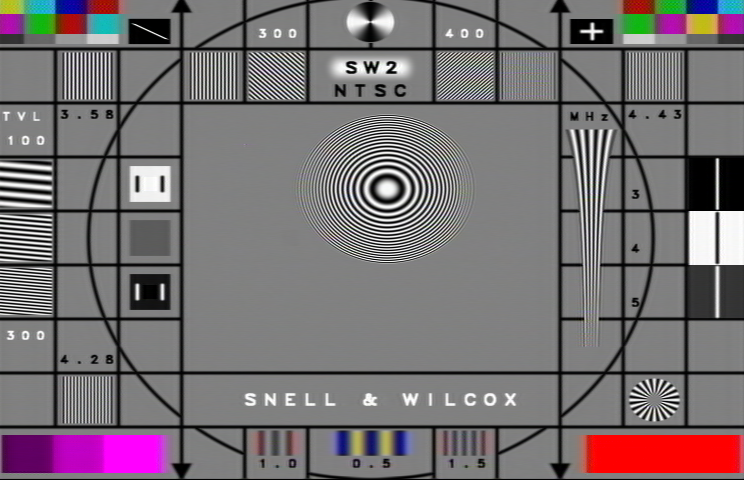

In [153]:
# run through comb-ntsc and png conversion.
# (NOTE:  motion detection isn't working right yet ;) )

fd = open('zone3d-27.png', 'rb')
image = fd.read()
IPython.display.Image(image)

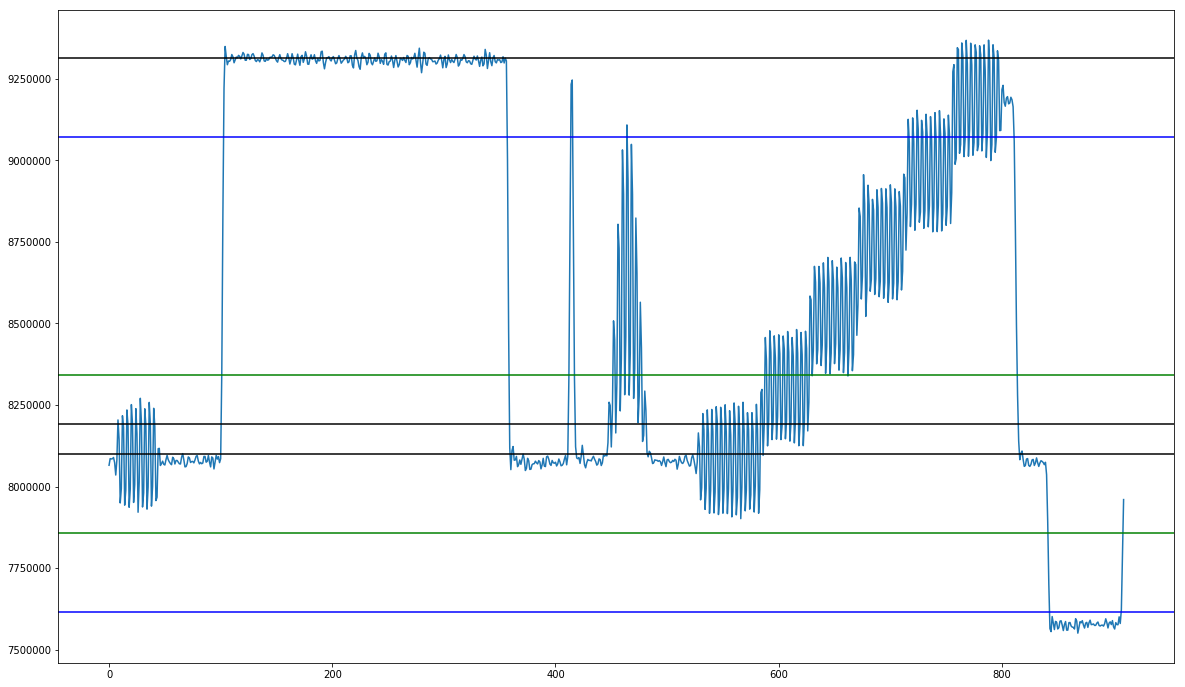

In [127]:
i = 20
lineplot(combined[i * outwidth:(i + 1) * outwidth], filterset)

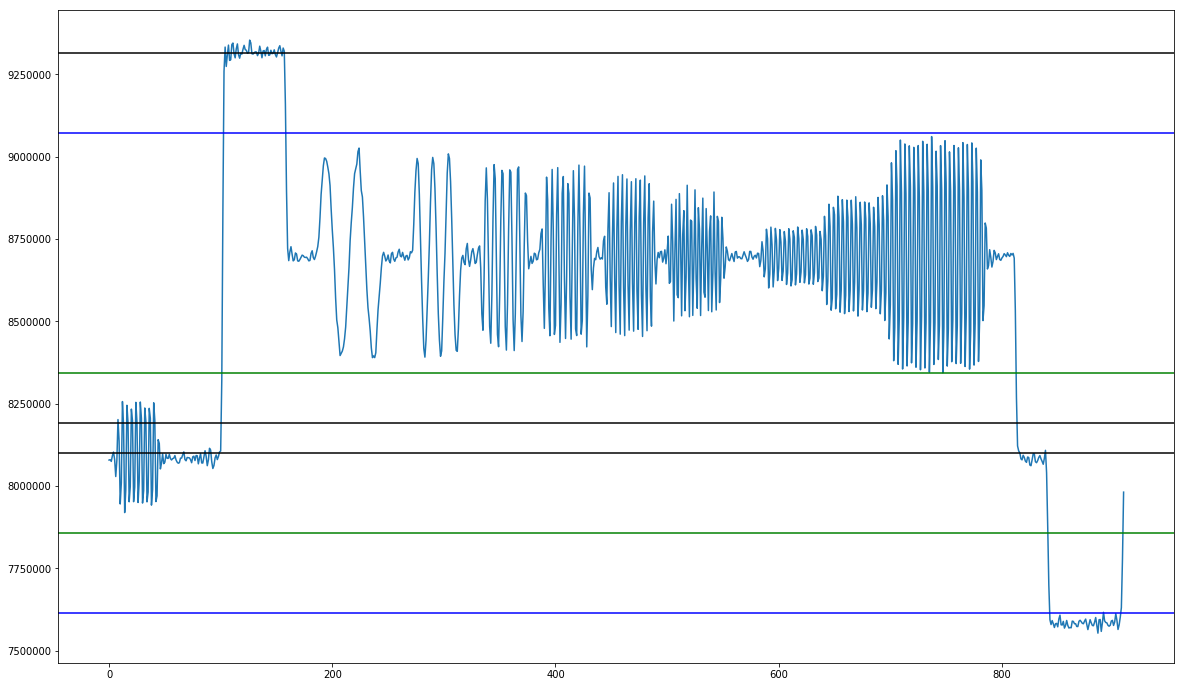

In [126]:
i = 21
lineplot(combined[i * outwidth:(i + 1) * outwidth], filterset)